# **Parametric LCA of an Aspen-Simulated Chemical Process**

**Ann-Joelle Minor**, Ruben Goldhahn, Caroline Ganzer, Michaël Lejeune, Liisa Rihko‑Struckmann, Kai Sundmacher  
*Max Planck Institute for Dynamics of Complex Technical Systems, Magdeburg, Germany*  
📧 [aminor@mpi-magdeburg.mpg.de](mailto:aminor@mpi-magdeburg.mpg.de)

---

# **Introduction**

This repository provides a **hands-on, end-to-end example** of how to perform a **transparent, parametric, and uncertainty-aware Life Cycle Assessment (LCA)** of a chemical process simulated in **Aspen Plus**, automated entirely from **Python**.

The tutorial case focuses on **ε-caprolactam (CL) purification from water** (functional unit: *1 kg purified CL*), comprising:
- one distillation column with reflux drum, condenser, and kettle reboiler,
- one evaporator,
- one pump, and
- one heat exchanger.


The workflow demonstrates how to:
1. Pull stream and utility data directly from Aspen Plus, 
2. Modify process parameters such as feed water amount from Python and re-run Aspen Plus 
3. Build a structured foreground inventory in Python, 
4. Define discrete and continuous parameters for scenario and sensitivity analyses, and 
5. Run the LCA using **Brightway2** and **lca-algebraic**, including parameter analysis, discrete/continuous choices, and Monte Carlo uncertainty propagation.

This codebase extends the **automation strategy developed in our Nylon-6 → caprolactam LCA study**, providing a **compact, reproducible exemplar** for others to learn, adapt, and extend toward their own process assessments.

---

### Key Features and Novelties

#### 1. Fully Automated Python ⇄ Aspen Plus Bridge
- Establishes a connection  
- Extracts detailed unit-operation data:
  - Mass and energy flows  
  - Utility duties (reboilers, condensers, pumps, exchangers)  
  - Stream compositions, temperatures, and pressures  
- Modifies parameters and re-runs Aspen Plus with updated inventories extracted for the LCA 
- Enables fully automated parametric regeneration of foreground inventories for process variants.


---

#### 2. Transparent Foreground–Background Coupling
- Merges Aspen-extracted inventories with **ecoinvent v3.9.1** background data.  
- Uses **Brightway2** and **lca-algebraic** for open-source LCA computation.  
- ISO 14040/44 compliance and applies the **EF 3.1** impact method.

---

#### 3. Structured LCA Workflow
The notebook walks through all LCA stages step by step.

---

#### 4. Parameterized Sensitivity Analysis
Includes both **discrete** and **continuous** parameters to illustrate uncertainty handling:

- **Discrete parameter:**  
  - Electricity source → switch between *German grid mix* and *wind power* datasets  

- **Continuous parameters:**  
  - Plant operating years  
  - Capacity factor / annual utilization  

All parameters are processed via lca-algebraic’s symbolic engine, allowing automated sensitivity and Monte-Carlo analyses.

---

#### 5. Modular Scenario Exploration
- Key assumptions (electricity mix, years, capacity factor, process water feed) can be modified directly in Python to generate new inventories and LCA results.
- Scenario loop varies the Aspen Plus water feed flowrate, triggering:
  - parameter back-substitution in Aspen,
  - re-simulation of process behavior,
  - regeneration of all stream and utility demands,
  - full recalculation of environmental impacts.

# **Installation**

https://docs.brightway.dev/en/legacy/content/installation/installation.html 

In the terminal, please run to create the environment bw2 and in the channel conda forge, there is brightway2 and jupyterlab installed which will be installed
```bash
    conda create -n bw2 -c conda-forge brightway2 jupyterlab
```
then
```bash
 conda activate bw2
 ```
then the package lca algebraic needs to be installed in the environment that was just created (called bw2): documentation 
https://github.com/oie-mines-paristech/lca_algebraic/tree/master
```bash
 pip install lca_algebraic==1.1.0
 ```
interface between brightway and ecoinvent such that brightway has access to ecoinvent
```bash
 conda install ecoinvent_interface

When the installation is done, please uncomment and run the cell below. You will need to replace bob and example by your ecoinvent username and password as shown. 
```python
from ecoinvent_interface import Settings, permanent_setting
permanent_setting("username", "putyourusername")
permanent_setting("password", "putyourpw")
```


You may need to restart VSCode and then on this notebook, make sure that the kernel is set to bw2. if there is any package missing, please install it by using the command `%pip install package_name` or `%conda install package_name` in a different cell.

# **Project initialisation**

### **Packages and Settings**

In [1]:
from dataclasses import dataclass
from matplotlib.colors import to_rgba

import numpy as np
import pickle
import math

import os                          # Import operating system interface
import win32com.client as win32    # Import COM
import matplotlib.pyplot as plt
import pandas as pd
import math

import re

from equipmentcosts import pumps_geometry, heatexchanger_geometry, fallingEVAPORATORS_geometry, refluxdrumDWSTU_geometry, condenserDWSTU_geometry, distillationDWSTU_geometry, kettleDWSTU_geometry, estimate_tube_number, calculate_baffle_spacing, calculate_shell_diameter, calculate_shelltubeexchanger_weight, vertical_towers_weight

# Brightway suite
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

# Algebraic_lca
from lca_algebraic import *
from lca_algebraic.stats import * 

# sympy functions
from sympy import init_printing, log, exp, N, Piecewise, symbols, simplify, Function, Eq, lambdify,symbols, diff,pprint
from sympy.plotting import plot, plot3d
from sympy.solvers import solve
from sympy.solvers.ode.systems import dsolve_system
from sympy import symbols, lambdify, latex
from scipy.stats import lognorm, linregress
from IPython.display import Markdown,display,HTML

%config InlineBackend.figure_format = 'retina'
pal = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', pal)
plt.rcParams['lines.linewidth'] = 1.5

### **Aspen Plus Python Connection** 

In [2]:
# 1. Specify file name
aspen_Path = 'CaseStudy.bkp'

# 2. Get path to Aspen Plus file
aspen_Path = os.path.abspath(aspen_Path)

# Initiate Aspen Plus application
print('\n Connecting to the Aspen Plus... Please wait ')
Application = win32.Dispatch('Apwn.Document') # Registered name of Aspen Plus
print('Connected!')

# Initiate Aspen Plus file
Application.InitFromArchive2(aspen_Path)    

# Make the files visible
Application.visible = 0
Application.Run()


 Connecting to the Aspen Plus... Please wait 
Connected!


### **Intialization LCA project**

In [3]:
Project_name= 'Poly-recycling1-cutoff' 
initProject(Project_name) 

Biosphere database already present!!! No setup is needed


C:\Users\kai\AppData\Local\Temp\ipykernel_11936\3746511654.py:2: DeprecationWarning: DEPRECATED : Use bw2io.import_ecoinvent_release() instead
  initProject(Project_name)


In [4]:
list_databases()


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
Construction,sqlite,7,foreground
Operation,sqlite,18,foreground


The following cell will install the ecoinvent database automatically. 

In [5]:
# define a function to check if we should import it
def database_import(ei_version,system_model):
    name="-".join(["ecoinvent",ei_version,system_model])
    if name not in bd.databases:
        bi.import_ecoinvent_release(version=ei_version,system_model=system_model,biosphere_name="biosphere3")
    else:
        print(f"{name} already imported")

ei_version="3.9.1"
system_model=Project_name.split('-')[-1] 
database_import(ei_version,system_model)

ecoinvent-3.9.1-cutoff already imported


Let's check if the import was successful

In [6]:
list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
Construction,sqlite,7,foreground
Operation,sqlite,18,foreground


We have now imported ecoinvent, and the biosphere to the project. Let's create some addtionnal databases

In [7]:
Construction_DB = "Construction"
Operation_DB = "Operation"

resetDb(Construction_DB)
resetDb(Operation_DB)
# creation of the database
setForeground(Construction_DB)
setForeground(Operation_DB)


[WARNING] Db Construction was here. Reseting it
[WARNING] Db Operation was here. Reseting it


In [8]:
list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
Construction,sqlite,0,foreground
Operation,sqlite,0,foreground


# **Parameters Definition** ### 

### **Years & Capacity factor**

In [9]:
#Operating year
hr_per_day = 24
day_per_year = 365

years = newFloatParam(                                  
            name='years',
            label="years of operation",
            description="life time of the plant",
            default= 15,  min=10, max=20, std=None, distrib=None,
            dbname=Operation_DB,
            unit='hours',
            )

capacity_factor = newFloatParam(                        
            name='Capacity_factor',
            label="Capacity factor",
            description="Capacity factor of the plant",
            default= 0.9,  min=0.5, max=0.95, std=None, distrib=None,
            dbname=Operation_DB,
            unit='hours',
            )

operation_hours = capacity_factor * day_per_year * hr_per_day
print(operation_hours)
lifetime = years*operation_hours # lifetime in hours

8760*Capacity_factor


### **Electricity**

Switch between wind energy and the electrical grid

In [10]:
electricity_medium_voltage_act = findTechAct("market for electricity, medium voltage",loc="DE")        
wind_elec_act = findTechAct("electricity production, wind, <1MW turbine, onshore", loc="DE")

elec_switch_param = newEnumParam(
        name='electricity_source',
        dbname=Operation_DB, 
        values=["mix","wind"], # If provided as list, all possibilities have te same probability
        default="mix", 
        description="Switch on electricty source between electrical grid and wind energy",
        unit="kWh")

electricity_mix = newSwitchAct(
            dbname=Operation_DB, 
            name="electricity mix", # Name
            paramDef= elec_switch_param, 
            acts_dict= { # Dictionnary of enum values / activities
                "mix" : electricity_medium_voltage_act, # By default associated amount is 1
                "wind" : wind_elec_act, #(eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
            })

# **Life cycle inventory: Construction**

### **Heat exhangers**

#### General Context

There is limited literature addressing the embedded carbon and life-cycle inventories (LCI) of **balance-of-plant (BoP)** unit operations such as heat exchangers or distillation columns.  

---

#### Sizing and Design Heuristics


**Key heuristics applied:**

| Design Aspect | Heuristic | Applied Choice |
|----------------|------------|----------------|
| Tube outer diameter | 3/4 in (19 mm) | 3/4 in |
| Tube length | 16 ft (4.88 m) | 16 ft |
| Tube layout | Triangular spacing | Yes |
| Baffle type | Segmental | Yes |
| Baffle cut | 25 % of shell ID | 25 % |
| Pitch factor | 1.1 (triangular layout) | 1.1 |
| Shell diameter | ≈ 30 % larger than tube bundle | used in sizing correlation |

**Heuristic notes:**
- Segmental baffles (25 % cut) are typical for general-purpose shell-and-tube exchangers.  
- Triangular pitch maximizes heat-transfer area per shell volume and gives the stated pitch factor.  
- Shell inside diameter accounts for ≈ 30 % clearance to allow maintenance and optimal flow.

**Example capacity reference (Seader):**
- 1 ft ID → ~ 27.9 m² area  
- 2 ft ID → ~ 123 m²  
- 3 ft ID → ~ 297 m²  

---

#### Material Selection (Steel Type)

The **material factor** determined in the CAPEX sub-model decides whether the exchanger is made of **carbon steel** or **stainless steel**.  
Selection follows *Heuristic 55* (Seader):

> “The tube side is used for corrosive, fouling, scaling, hazardous, high-temperature, high-pressure, or expensive fluids.  
> The shell side is used for more viscous, cleaner, lower-flow-rate, evaporating, and condensing fluids.”

**Therefore:**
- For **purely water systems**, shell and tubes are **carbon steel** → material factor = 1.0.  
- For **corrosive or organic systems**, tube side is **stainless steel**.

**Mapping to ecoinvent materials:**

| Material | ecoinvent process | Comment |
|-----------|------------------|----------|
| Stainless steel | *market for steel, chromium steel 18/8* | corresponds to 304/316 grades |
| Carbon steel | *market for steel, low-alloyed* | used as proxy for mild steel, following Blume |

---

#### Inclusion of Other Construction Materials

Beyond the primary steel structure, additional macro-components are included based on Castellanos-Beltran et al. (2023):

| Component | Function | Inclusion approach |
|------------|-----------|--------------------|
| Steel (carbon or stainless) | Structural frame | base mass reference |
| Glass wool (mineral) | Thermal insulation | included qualitatively |
| Concrete | Foundation / support | estimated via steel-to-concrete ratio |
| Aluminium | External casing | included qualitatively |
| Powering (cables) | Energizing / control systems | correlated by gravimetric factor |
| Electronics | Monitoring and control | correlated by gravimetric factor |



In [11]:
No_Heat_Exchanger = 1

num_tubes = np.zeros(No_Heat_Exchanger)
shell_diameter = np.zeros(No_Heat_Exchanger)
baffle_spacing = np.zeros(No_Heat_Exchanger)
num_baffles = np.zeros(No_Heat_Exchanger)
weight = np.zeros(No_Heat_Exchanger)
shell_weight = np.zeros(No_Heat_Exchanger)
tube_weight = np.zeros(No_Heat_Exchanger)
carbon_weight = np.zeros(No_Heat_Exchanger)
stainless_weight = np.zeros(No_Heat_Exchanger)
glasswool_weight = np.zeros(No_Heat_Exchanger)
aluminium_weight  = np.zeros(No_Heat_Exchanger)

#param
tube_OD = 0.01905                   #m, = 0.75 in
tube_length = 4.8768                #m, = 16 ft
stainless_steel_density = 7980      #kg/m3

#Heat Exchanger
#

fouling_factor = 0.9
E_FL = 1.05     #Tube length correction seader
cost_index_2019 = 607.5
cost_index_2006 = 500

E_Q, E_area, E_T, E_FM = heatexchanger_geometry(Application, No_Heat_Exchanger) 

#steel, glass wool, aluminium calculation: 
i=0
for i in range(0,No_Heat_Exchanger):

    if E_T[i] < 300+273.15:
        num_tubes[i] = estimate_tube_number(E_area[i], tube_OD, tube_length, 1000)
        shell_diameter[i]= calculate_shell_diameter(num_tubes[i], tube_OD)
        num_baffles[i], baffle_spacing[i] = calculate_baffle_spacing(shell_diameter[i], 25)
        
        glasswool_weight[i] = E_area[i]**0.488 * (39.1 - 13.08 * ((tube_OD*1000) / 19.05) + 1.707 * ((tube_OD*1000) / 19.05)**2 )

        aluminium_weight[i] = E_area[i]**0.3565 * (95.14 - 25.62 * ((tube_OD*1000) / 19.05) + 3.234 * ((tube_OD*1000) / 19.05)**2 )

        if E_FM[i] == 1:

            weight[i], shell_weight[i],tube_weight[i] = calculate_shelltubeexchanger_weight(shell_diameter[i], tube_length, tube_OD, num_tubes[i], baffle_spacing[i])
            carbon_weight[i] = shell_weight[i] + tube_weight[i]
            stainless_weight[i] = 0
    
        if E_FM[i] != 1:

            weight[i], shell_weight[i],tube_weight[i] = calculate_shelltubeexchanger_weight(shell_diameter[i], tube_length, tube_OD, num_tubes[i], baffle_spacing[i], shell_steel_density = stainless_steel_density)
            carbon_weight[i] = shell_weight[i] 
            stainless_weight[i] = tube_weight[i]

total_carbon_HE = np.sum(carbon_weight)
total_stainless_HE = np.sum(stainless_weight)
total_glasswool_HE = np.sum(glasswool_weight)
total_aluminium_HE = np.sum(aluminium_weight)

#concrete calculation
total_concrete_HE = (total_carbon_HE+total_stainless_HE) * 2.63

#Powering and electronics calculation:
total_powering_HE = (total_carbon_HE+total_stainless_HE) * 0.01

total_mass_HE = total_stainless_HE+total_carbon_HE+total_powering_HE+total_concrete_HE+total_glasswool_HE+total_aluminium_HE

In [12]:
stainless_steel = findTechAct("market for steel, chromium steel 18/8, hot rolled", loc="GLO")                #only GLO available, hot rolled according to Blume
carbon_steel = findTechAct("market for steel, low-alloyed, hot rolled", loc="GLO")                           #only GLO available, hot rolled according to Blume
concrete = findTechAct("market group for concrete, normal strength", loc="GLO")
powering = findTechAct("market for cable, unspecified", loc="GLO")
aluminium = findTechAct("market for sheet rolling, aluminium", loc="GLO") 
glasswool = findTechAct("market for glass wool mat", loc="GLO") 
hot_rolling = findTechAct("market for hot rolling, steel", loc="GLO")

# even though market for the whole SUB components of heat exchanger is there, we need to add transportation as manufactured heat exchanger also needs that market
transport_freight_EU_no_market = findTechAct("transport, freight, lorry 7.5-16 metric ton, EURO5", loc="RER")   
transport_freight_RER = findTechAct("market for transport, freight, lorry 7.5-16 metric ton, EURO5", loc="RER")
transport_freight_RER_32tplus= findTechAct("market for transport, freight, lorry >32 metric ton, EURO5", loc="RER")

The LCI model of the heat exchanger has been elaborated from the work of (Blume et al., 2022) and (Gerhardt-Mörsdorf et al., 2024) and Castellanos-Beltran (2023)

In [13]:
concrete_density = 2400         #kg/m3

Heat_exchangers = newActivity(
        db_name=Construction_DB,
        name="Production of Shell and Tube and Double Pipe Heat_exchangers",
        unit="unit",
        amount=1,
        description="total of heat exchangers not including reboiler or furnaces, market for included",
        comment="",
        location="DE",
        exchanges={
        #### inputs technosphere
            stainless_steel:total_stainless_HE,             #Stainless steel total
            carbon_steel:total_carbon_HE,                   #Carbon steel total
            concrete:total_concrete_HE/concrete_density,    #because concrete activity given in m3
            powering:total_powering_HE,
            aluminium:total_aluminium_HE,
            glasswool:total_glasswool_HE,
            transport_freight_EU_no_market:(total_mass_HE)/1000*200, #Transport of the heat exchanger 
            transport_freight_RER:(total_mass_HE)/1000*800, #Transport of the heat exchanger 
    })

printAct(Heat_exchangers)

Production of Shell and Tube and Double Pipe Heat_exchangers[DE] (1.000000 unit)  \
                                                                                                                              input   
market for cable, unspecified                                           market for cable, unspecified                                 
market for glass wool mat                                                   market for glass wool mat                                 
market for sheet rolling, aluminium                               market for sheet rolling, aluminium                                 
market for steel, chromium steel 18/8, hot rolled   market for steel, chromium steel 18/8, hot rolled                                 
market for steel, low-alloyed, hot rolled                   market for steel, low-alloyed, hot rolled                                 
market for transport, freight, lorry 7.5-16 met...  market for transport, freight, lorry 7.5-16 me...                                 
market group for concrete, normal strength                 market group for concrete, normal strength                                 
transport, freight, lorry 7.5-16 metric ton, EURO5  transport, freight, lorry 7.5-16 metric ton, E...                                 

                                                                            
                                                     amount           unit  
market for cable, unspecified                       2.99164       kilogram  
market for glass wool mat                           29.5407       kilogram  
market for sheet rolling, aluminium                 76.2009       kilogram  
market for steel, chromium steel 18/8, hot rolled   85.9766       kilogram  
market for steel, low-alloyed, hot rolled           213.188       kilogram  
market for transport, freight, lorry 7.5-16 met...   955.76  ton kilometer  
market group for concrete, normal strength         0.327834    cubic meter  
transport, freight, lorry 7.5-16 metric ton, EURO5   238.94  ton kilometer

### **Distillation Reboiler and Condenser**

In [14]:
no_towers = 1

#Fixed variables kettle
kettle_Q = np.zeros(no_towers)
kettle_area = np.zeros(no_towers)

#Fixed variables condenser
cond_Q = np.zeros(no_towers)
cond_area = np.zeros(no_towers)

i=0
for i in range(1,no_towers+1):
    
    nameDWSTU = f"DIST{i}"
    name_inputstream_DWSTU = f"DST{i}IN"
    name_distallestream_DWSTU = f"DIST{i}TOP"

    kettle_Q[i-1], kettle_area[i-1], _ = kettleDWSTU_geometry( Application, nameDWSTU, None, None, None)
    
    cond_Q[i-1], cond_area[i-1], _ = condenserDWSTU_geometry(Application, nameDWSTU, fouling_factor=0.9)

**Kettle:**

In [15]:
num_tubes_kettle = estimate_tube_number(kettle_area, tube_OD, tube_length, 2000)
shell_diameter_kettle= calculate_shell_diameter(num_tubes_kettle, tube_OD)
num_baffles_kettle, baffle_spacing_kettle = calculate_baffle_spacing(shell_diameter_kettle, 25)
weight_kettle, shell_weight_kettle,tube_weight_kettle = calculate_shelltubeexchanger_weight(shell_diameter_kettle, tube_length, tube_OD, num_tubes_kettle, baffle_spacing_kettle, shell_steel_density = stainless_steel_density)
carbon_weight_kettle = shell_weight_kettle
stainless_weight_kettle = tube_weight_kettle

glasswool_weight_kettle = kettle_area**0.488 * (39.1 - 13.08 * ((tube_OD*1000) / 19.05) + 1.707 * ((tube_OD*1000) / 19.05)**2 )

aluminium_weight_kettle = kettle_area**0.3565 * (95.14 - 25.62 * ((tube_OD*1000) / 19.05) + 3.234 * ((tube_OD*1000) / 19.05)**2 )

total_carbon_kettle = np.sum(carbon_weight_kettle)
total_stainless_kettle = np.sum(stainless_weight_kettle)
total_glasswool_kettle = np.sum(glasswool_weight_kettle)
total_aluminium_kettle = np.sum(aluminium_weight_kettle)

#concrete calculation
total_concrete_kettle = (total_carbon_kettle+total_stainless_kettle) * 2.63

#Powering and electronics calculation:
total_powering_kettle = (total_carbon_kettle+total_stainless_kettle) * 0.01

total_mass_kettle = total_stainless_kettle+total_carbon_kettle+total_powering_kettle+total_concrete_kettle+total_glasswool_kettle+total_aluminium_kettle

**Condenser:**

In [16]:
num_tubes_cond = estimate_tube_number(cond_area, tube_OD, tube_length, 2000)
shell_diameter_cond= calculate_shell_diameter(num_tubes_cond, tube_OD)
num_baffles_cond, baffle_spacing_cond = calculate_baffle_spacing(shell_diameter_cond, 25)
weight_cond, shell_weight_cond,tube_weight_cond = calculate_shelltubeexchanger_weight(shell_diameter_cond, tube_length, tube_OD, num_tubes_cond, baffle_spacing_cond, shell_steel_density = stainless_steel_density)
carbon_weight_cond = shell_weight_cond
stainless_weight_cond = tube_weight_cond

glasswool_weight_cond = cond_area**0.488 * (39.1 - 13.08 * ((tube_OD*1000) / 19.05) + 1.707 * ((tube_OD*1000) / 19.05)**2 )

aluminium_weight_cond = cond_area**0.3565 * (95.14 - 25.62 * ((tube_OD*1000) / 19.05) + 3.234 * ((tube_OD*1000) / 19.05)**2 )

total_carbon_cond = np.sum(carbon_weight_cond)
total_stainless_cond = np.sum(stainless_weight_cond)
total_glasswool_cond = np.sum(glasswool_weight_cond)
total_aluminium_cond = np.sum(aluminium_weight_cond)

#concrete calculation
total_concrete_cond = (total_carbon_cond+total_stainless_cond) * 2.63

#Powering and electronics calculation:
total_powering_cond = (total_carbon_cond+total_stainless_cond) * 0.01

total_mass_cond = total_stainless_cond+total_carbon_cond+total_powering_cond+total_concrete_cond+total_glasswool_cond+total_aluminium_cond

In [17]:
Distillation_Heat_Exchangers = newActivity(
        db_name=Construction_DB,
        name="Production of Kettle Reboiler and Distillation Condenser",
        unit="unit",
        description="Total Production of Kettle Reboiler and Distillation Condenser, market for included",
        comment="",
        location="DE",
        exchanges={
        #### inputs technosphere
            stainless_steel:total_stainless_kettle+total_stainless_cond,            #Stainless steel total
            carbon_steel:total_carbon_kettle+total_carbon_cond,                     #Carbon steel total
            concrete:(total_concrete_kettle+total_concrete_cond)/concrete_density,  #because concrete activity given in m3
            powering:total_powering_kettle+total_powering_cond,
            aluminium:total_aluminium_kettle+total_aluminium_cond,
            glasswool:total_glasswool_kettle+total_glasswool_cond,
            transport_freight_EU_no_market:(total_mass_cond+total_mass_kettle)/1000*200, #Transport of the heat exchanger 
            transport_freight_RER:(total_mass_cond+total_mass_kettle)/1000*800,      #Transport of the heat exchanger 
    })

printAct(Distillation_Heat_Exchangers)

Production of Kettle Reboiler and Distillation Condenser[DE] (1.000000 unit)  \
                                                                                                                          input   
market for cable, unspecified                                           market for cable, unspecified                             
market for glass wool mat                                                   market for glass wool mat                             
market for sheet rolling, aluminium                               market for sheet rolling, aluminium                             
market for steel, chromium steel 18/8, hot rolled   market for steel, chromium steel 18/8, hot rolled                             
market for steel, low-alloyed, hot rolled                   market for steel, low-alloyed, hot rolled                             
market for transport, freight, lorry 7.5-16 met...  market for transport, freight, lorry 7.5-16 me...                             
market group for concrete, normal strength                 market group for concrete, normal strength                             
transport, freight, lorry 7.5-16 metric ton, EURO5  transport, freight, lorry 7.5-16 metric ton, E...                             

                                                                            
                                                     amount           unit  
market for cable, unspecified                       66.1239       kilogram  
market for glass wool mat                           689.899       kilogram  
market for sheet rolling, aluminium                  914.06       kilogram  
market for steel, chromium steel 18/8, hot rolled  5,386.43       kilogram  
market for steel, low-alloyed, hot rolled          1,225.96       kilogram  
market for transport, freight, lorry 7.5-16 met... 20,538.5  ton kilometer  
market group for concrete, normal strength          7.24608    cubic meter  
transport, freight, lorry 7.5-16 metric ton, EURO5 5,134.61  ton kilometer

### **Pumps**

In [18]:
No_pumps = 1
pump_head, pump_flowrate, pump_size_factor, pump_break_horsepower, pump_electricity = pumps_geometry(Application, No_pumps)

The used pumps in the process are centrifugal pump and reciprocating plunder pumps. However, they are not availabe in the database. It is assumed that they are approximated by the water pump production.

In [19]:
pump_act = findTechAct("market for water pump, 22kW", loc="GLO")   
pump_weight = 2.47+148.3+30.9+113.7+3.3+0.47+0.86      #according to the activity

Scale according to pump electricity linear 

In [20]:
required_pumps = np.zeros(No_pumps)

i=0
for i in range(0,No_pumps):
    required_pumps[i] = pump_electricity[i] / 1000     

required_pumps_total = np.sum(required_pumps)


In [21]:
Pumps = newActivity(
        db_name=Construction_DB,
        name="Production of Pumps",
        unit="unit",
        description="total of pumps,market for included",
        comment="",
        location="DE",
        exchanges={
        #### inputs technosphere
            pump_act:required_pumps_total, 
        #### Emissions biosphere
    })
printAct(Pumps)

Production of Pumps[DE] (1.000000 unit)          \
                                                              input  amount   
market for water pump, 22kW             market for water pump, 22kW 119.836   

                                   
                             unit  
market for water pump, 22kW  unit

### **Towers**

Distillation Column and Reflux drum

In [22]:
#Fixed variables clolum
d_diamter = np.zeros(no_towers)
d_volume = np.zeros(no_towers)
d_height = np.zeros(no_towers)
d_weight = np.zeros(no_towers)
no_of_trays = np.zeros(no_towers)
d_tt_len = np.zeros(no_towers)


#Fixed variables reflux drum
drum_volume = np.zeros(no_towers)
drum_diameter = np.zeros(no_towers)
drum_length = np.zeros(no_towers)
drum_weight = np.zeros(no_towers)

i=0
for i in range(1,no_towers+1):
    
    nameDWSTU = f"DIST{i}"
    name_inputstream_DWSTU = f"DST{i}IN"
    name_distallestream_DWSTU = f"DIST{i}TOP"


    d_diamter[i-1], d_volume[i-1], d_height[i-1], d_weight[i-1], no_of_trays[i-1], d_tt_len[i-1] = distillationDWSTU_geometry(Application, nameDWSTU, name_inputstream_DWSTU, name_distallestream_DWSTU)

    drum_volume[i-1], drum_diameter[i-1], drum_length[i-1], drum_weight[i-1] = refluxdrumDWSTU_geometry(Application, nameDWSTU, name_distallestream_DWSTU)


In [23]:
d_weight_concrete = (d_weight[0]+drum_weight[0]) * 2.63
d_weight_powering = (d_weight[0]+drum_weight[0]) * 0.01
d_weight_glasswool = -26.9 * d_diamter[0] + no_of_trays[0] * 4.753 + 47.56 * d_diamter[0]**2 + 31.96 * (d_diamter[0]*no_of_trays[0]) + 24.53
d_aluminium = 30.67 * d_diamter[0] + no_of_trays[0] * 11.25 + 53.86 * d_diamter[0]**2 + 40.4 * (d_diamter[0]*no_of_trays[0]) + 4.367
d_total_weight = d_weight+drum_weight+d_weight_concrete+d_weight_glasswool+d_aluminium

In [24]:
Distillation = newActivity(
        db_name=Construction_DB,
        name="Construction of Distillation Column and Reflux Drum",
        unit="unit",
        description="Total Construction of Distillation Column and Reflux Drum, market for included",
        comment="geometry according to Seader et al.",
        location="DE",                                     
        exchanges={
        #### inputs technosphere
            stainless_steel:d_weight[0]+drum_weight[0],             #Stainless steel total
            concrete:(d_weight_concrete)/concrete_density,  #because concrete activity given in m3
            powering:d_weight_powering,
            aluminium:d_aluminium,
            glasswool:d_weight_glasswool,
            transport_freight_RER_32tplus: (d_total_weight[0])/1000*200, #metric ton km
            transport_freight_RER_32tplus: (d_total_weight[0])/1000*800, #metric ton km
        #### Emissions biosphere
    })
printAct(Distillation)


Construction of Distillation Column and Reflux Drum[DE] (1.000000 unit)  \
                                                                                                                     input   
market for cable, unspecified                                           market for cable, unspecified                        
market for glass wool mat                                                   market for glass wool mat                        
market for sheet rolling, aluminium                               market for sheet rolling, aluminium                        
market for steel, chromium steel 18/8, hot rolled   market for steel, chromium steel 18/8, hot rolled                        
market for transport, freight, lorry >32 metric...  market for transport, freight, lorry >32 metri...                        
market group for concrete, normal strength                 market group for concrete, normal strength                        

                                                                            
                                                     amount           unit  
market for cable, unspecified                      1,569.42       kilogram  
market for glass wool mat                          9,814.17       kilogram  
market for sheet rolling, aluminium                12,808.4       kilogram  
market for steel, chromium steel 18/8, hot rolled   156,942       kilogram  
market for transport, freight, lorry >32 metric...  473,856  ton kilometer  
market group for concrete, normal strength          171.982    cubic meter

### **Vessels: Evaporator**

In [25]:
No_Evaporators = 1
rho = 0.288         #lb/in3

evap_volume, evap_Q, evap_area, evap_diameter, evap_length = fallingEVAPORATORS_geometry(Application, No_Evaporators)  # uses defaults for K=0.35, L/D=2.5, U=850, fouling=0.9, LP steam temps

evap_lowest_pressure1 = Application.Tree.FindNode("\Data\Blocks\EVAP1\Output\B_PRES").Value * 0.001  #multipliziert da Aspen in N/sqm gibt, kPa

evap_temp1 = Application.Tree.FindNode("\Data\Blocks\EVAP1\Output\B_TEMP").Value      #K

evap_weight_steel1 = vertical_towers_weight(evap_lowest_pressure1, evap_temp1, evap_diameter, evap_length, rho/0.000036127298147753)

For the other components other equations Castellanos-Beltran et al. (2023)

In [26]:
evap_weight_concrete1 = evap_weight_steel1 * 2.63 
evap_weight_powering1 = evap_weight_steel1 * 0.01
evap_weight_glasswool1 = -1.011 * evap_diameter + 1.234 * evap_diameter**2.9715 + 6.127 * (evap_diameter**2.9715 * evap_length/evap_diameter) + 2.296 
evap_weight_aluminium1 = 2.392 * evap_diameter + 1.351 * evap_diameter**2 + 16.29 * evap_length
evap_total_weight1 = evap_weight_steel1 + evap_weight_concrete1 + evap_weight_powering1 + evap_weight_glasswool1 + evap_weight_aluminium1

In [27]:
Evaporators = newActivity(
        db_name=Construction_DB,
        name="Production of Flash Evaporators",
        unit="unit",
        description="total of evaporators",
        comment="market for included",
        location="DE",
        exchanges={
        #### inputs technosphere
            stainless_steel:evap_weight_steel1,             #Stainless steel total
            concrete:(evap_weight_concrete1)/concrete_density,    #because concrete activity given in m3
            powering:evap_weight_powering1,
            aluminium:evap_weight_aluminium1,
            glasswool:evap_weight_glasswool1,
            transport_freight_EU_no_market:(evap_total_weight1)/1000*200, #Transport of the heat exchanger 
            transport_freight_RER:(evap_total_weight1)/1000*800, #Transport of the heat exchanger 
})

printAct(Evaporators)

Production of Flash Evaporators[DE] (1.000000 unit)  \
                                                                                                 input   
market for cable, unspecified                                           market for cable, unspecified    
market for glass wool mat                                                   market for glass wool mat    
market for sheet rolling, aluminium                               market for sheet rolling, aluminium    
market for steel, chromium steel 18/8, hot rolled   market for steel, chromium steel 18/8, hot rolled    
market for transport, freight, lorry 7.5-16 met...  market for transport, freight, lorry 7.5-16 me...    
market group for concrete, normal strength                 market group for concrete, normal strength    
transport, freight, lorry 7.5-16 metric ton, EURO5  transport, freight, lorry 7.5-16 metric ton, E...    

                                                                             
                                                      amount           unit  
market for cable, unspecified                       0.525915       kilogram  
market for glass wool mat                            2.50579       kilogram  
market for sheet rolling, aluminium                  13.6457       kilogram  
market for steel, chromium steel 18/8, hot rolled    52.5915       kilogram  
market for transport, freight, lorry 7.5-16 met...   166.068  ton kilometer  
market group for concrete, normal strength         0.0576315    cubic meter  
transport, freight, lorry 7.5-16 metric ton, EURO5   41.5169  ton kilometer

### **Chemical Plant**

#### *Construction Materials*

To use in ecoinvent the chemical factory activity, where not only steel but also cables and land use are incorporated, the total weight of carbon and stainless steel is summed up. 

From this total weight, the activity can be scaled based on the weight of steel, such that the weight of the steel corresponds to the true calculated value, and all other components of this activity are within the same ratio

In [28]:
total_steel_weight_plant = total_carbon_HE+total_stainless_HE+total_carbon_kettle+total_stainless_kettle+total_carbon_cond+total_stainless_cond+113.72*required_pumps_total+d_weight[0]+drum_weight[0]+evap_weight_steel1

print(total_steel_weight_plant)

177533.53086611917


According to the activity "chemical factory construction | chemical factory | Cutoff, U", there is 0.249 kg of stainless steel, and 0.423 kg of carbon steel. This makes in total 0.672 kg of steel. Hence the activity is scaled such that we have the amount of chemical factory construction that we need.

In [29]:
w_activity=0.249+0.423
chemical_factory_construction_amount = total_steel_weight_plant / w_activity

However since we already incorporated the steel amount through all process equipment, the carbon and stainless steel needs to be substracted

In [30]:
carbon_steel_chemical_factory = 0.423 * chemical_factory_construction_amount
stainless_steel_chemical_factory = 0.249 * chemical_factory_construction_amount
concrete_chemical_factory_CH = (7.48622697937982E-5) * chemical_factory_construction_amount
concrete_chemical_factory_AT = (4.1137730206201795E-5) * chemical_factory_construction_amount

Furthermore, piping, instrumentation and control needs to be accounted for. Factor 1.57 needs to be applied (Seader book)

In [31]:
chemical_factory_construction_amount_piping = chemical_factory_construction_amount * 1.57
chemical_factory_construction_amount_piping

414773.27895804634

In [32]:
chemical_factory_construction = findTechAct("chemical factory construction", loc="RER")
concrete_CH = findTechAct("market for concrete, normal strength", loc="CH")
concrete_AT = findTechAct("market for concrete, normal strength", loc="AT")

In [33]:
chemical_plant_construction_materials = newActivity(
        db_name=Construction_DB,
        name="Production of chemical plant",
        unit="unit",
        description="Production of chemical plant including steel, electric cables etc for the CL production of 1.52 t/hr for 15 years",
        comment="",
        location="RER",
        exchanges={
        #### inputs technosphere
            chemical_factory_construction: chemical_factory_construction_amount_piping,  
            stainless_steel: -stainless_steel_chemical_factory, 
            carbon_steel: -carbon_steel_chemical_factory,
            concrete_CH: -concrete_chemical_factory_CH,
            concrete_AT: -concrete_chemical_factory_AT,
        #### Emissions biosphere
    })
printAct(chemical_plant_construction_materials)

Production of chemical plant[RER] (1.000000 unit)  \
                                                                                               input   
chemical factory construction                                     chemical factory construction[RER]   
market for concrete, normal strength                        market for concrete, normal strength[CH]   
market for concrete, normal strength#1                      market for concrete, normal strength[AT]   
market for steel, chromium steel 18/8, hot rolled  market for steel, chromium steel 18/8, hot rolled   
market for steel, low-alloyed, hot rolled                  market for steel, low-alloyed, hot rolled   

                                                                          
                                                     amount         unit  
chemical factory construction                       414,773     kilogram  
market for concrete, normal strength               -19.7776  cubic meter  
market for concrete, normal strength#1              -10.868  cubic meter  
market for steel, chromium steel 18/8, hot rolled -65,782.5     kilogram  
market for steel, low-alloyed, hot rolled          -111,751     kilogram

#### *Land Use*

"The building infrastructure of the producing factories also needs to be considered for a complete LCI. When there is no data available for the specific chemical factories where the substances are produced, a generic Ecoinvent infrastructure construction activity can be selected."

To incorporate for land use we need "chemical factory construction, organics | chemical factory, organics | Cutoff, U". There are various papers that assume 10e-4 as scale for the production of 1kg product. E.g. the IL prodcution process Baaqel et al. (2022) and the paper by Hischier et al. (2005): "The importance of the infrastructure of a production plant is assumed to be low and the general infrastructure dataset 'chemical plant, organics' is therefore used as an approximation. As this dataset is based on a production capacity of 50,000 t per year and a plant life time of 50 years, an amount of 4 * 10–10 units per kg of produced chemical is added to the unit process of the respective chemical."

In [34]:
chemical_factory_organics = findTechAct("chemical factory construction, organics", loc="RER")

chemical factory organics also includes the chemical factory construction with an input of 1.26E7, which needs to be substracted as it was already incorporated. 
chemical factory organics scaled such that we have exaclty the chemical factory that we need. 

In [35]:
chemical_factory_organics_amount = chemical_factory_construction_amount_piping / 1.26E7

chemical factory organics also includes the chemical factory construction with an input of 1.26E7, which needs to be substracted as it was already incorporated. 

In [36]:
chemical_plant_land_use = newActivity(
        db_name=Construction_DB,
        name="Land use of chemical plant",
        unit="unit",
        description="Land of chemical plant for the CL production of 1.52 t/hr for 15 years",
        comment="",
        location="RER",
        exchanges={
        #### inputs technosphere
            chemical_factory_organics: chemical_factory_organics_amount,
            stainless_steel: -stainless_steel_chemical_factory, 
            carbon_steel: -carbon_steel_chemical_factory,
            concrete_CH: -concrete_chemical_factory_CH,
            concrete_AT: -concrete_chemical_factory_AT,
    })
printAct(chemical_plant_land_use)


Land use of chemical plant[RER] (1.000000 unit)  \
                                                                                               input   
chemical factory construction, organics                 chemical factory construction, organics[RER]   
market for concrete, normal strength                        market for concrete, normal strength[CH]   
market for concrete, normal strength#1                      market for concrete, normal strength[AT]   
market for steel, chromium steel 18/8, hot rolled  market for steel, chromium steel 18/8, hot rolled   
market for steel, low-alloyed, hot rolled                  market for steel, low-alloyed, hot rolled   

                                                                          
                                                     amount         unit  
chemical factory construction, organics           0.0329185         unit  
market for concrete, normal strength               -19.7776  cubic meter  
market for concrete, normal strength#1              -10.868  cubic meter  
market for steel, chromium steel 18/8, hot rolled -65,782.5     kilogram  
market for steel, low-alloyed, hot rolled          -111,751     kilogram

### **Chemicals**

In [37]:
water_DI = findTechAct("market for water, deionised",loc="Europe without Switzerland")

# **Life cycle inventory: Operation**

### **Inputs and outputs of the process (mass, utilities) entire lifetime**

In [38]:
#constants 
he_LP = 2144        #kJ/kg (139.9 C)
he_MP = 1991        #kJ/kg (186 C)
he_dowtherm = 1014.8 - 808.7    #kJ/kg vapor - liquid enthalpy 400 C
rho_fuel_no2 = 900  #kg/m3
HHV_BTU_gal = 139000    #BTU/gal
gal_to_m3 = 0.00378541
BTU_to_J = 1055.06
HHV = HHV_BTU_gal / gal_to_m3 / rho_fuel_no2 * BTU_to_J / 1000
cp_CW = 4.2         #kj/kg/K
Tin_CW = 30         #C
Tout_CW = 45        #C
rho_CW = 997

#define in Aspen Utilities LP, MP, CW and Oil (Fuel oil No 2)
MP_usage_year = np.array(0)
LP_usage_year = np.array(0)
Electricity_usage_year = np.array(0)    # kW hr /  op year
CW_usage_year = np.array(0)
OIL_usage_year = np.array(0)
Waste_usage_year = np.array(0)                  #NON HAZ waste
dowtherm_usage_year = np.array(0)

MP_usage_product = np.array(0)
LP_usage_product = np.array(0)
Electricity_usage_product = np.array(0)
CW_usage_product = np.array(0)
OIL_usage_product = np.array(0)
Waste_usage_product = np.array(0)
dowtherm_usage_product = np.array(0)

E_T = np.zeros(No_Heat_Exchanger)
EE_Q = np.zeros(No_Heat_Exchanger)


product = Application.Tree.FindNode("\Data\Streams\EVAP1BOT\Output\STR_MAIN\MASSFLOW\MIXED\CL").Value     #kg/s
product_per_year = product / 1000 * 3600 * hr_per_day * day_per_year * capacity_factor    

water_per_year = (Application.Tree.FindNode("\Data\Streams\DST1IN\Output\STR_MAIN\MASSFLOW\MIXED\WATER").Value) * 3600 * hr_per_day * day_per_year * capacity_factor

#Heat exchanger utilities
i=0
for i in range(1,No_Heat_Exchanger+1):
    
    try:                #because paths a called differently for different type of heat exchangers
        E_T[i-1] = Application.Tree.FindNode("\\Data\\Blocks\\E0{}\\Output\\COLD_TEMP".format(i)).Value
    except: 
        print()
    
    try: 
        E_T[i-1] = Application.Tree.FindNode("\Data\Blocks\E0{}\Output\B_TEMP".format(i)).Value
    except: 
        print()
        
    
    if E_T[i-1] < 252+273.15 :        #Because else no heat exchanger but fired heater (for T above 252C)
        EE_Q[i-1] = Application.Tree.FindNode("\\Data\\Blocks\\E0{}\\Output\\HX_DUTY".format(i)).Value
        
        E_utility_type = Application.Tree.FindNode("\Data\Blocks\E0{}\Input\HOT_UTIL".format(i)).Value
    
        if E_utility_type == 'LP' or E_utility_type == 'MP':
                #E_utility_usage_year[i-1] = E_Q[i-1] / he_LP * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor     #tonne/op year 
                #E_utility_usage_product[i-1] = E_utility_usage_year[i-1] / product_per_year[k]       #ton/ton product
                globals()[f"{E_utility_type}_usage_year"] = np.append(globals()[f"{E_utility_type}_usage_year"], EE_Q[i-1] / globals()[f"he_{E_utility_type}"] * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor)      #ton/op year
                globals()[f"{E_utility_type}_usage_product"] = np.append(globals()[f"{E_utility_type}_usage_product"], globals()[f"{E_utility_type}_usage_year"][-1] / product_per_year)        #ton/ton product

        if E_utility_type == None:   #because in case of cooler it is none, because there is no hot utilty
            E_utility_type = Application.Tree.FindNode("\Data\Blocks\E0{}\Input\COLD_UTIL".format(i)).Value
            
            if E_utility_type == 'CW':    
                CW_usage_year = np.append(CW_usage_year, EE_Q[i-1] / cp_CW / (Tout_CW-Tin_CW) * 3600 / 1000 / rho_CW * hr_per_day * day_per_year * capacity_factor)     #m3/op year 
                CW_usage_product = np.append(CW_usage_product, CW_usage_year[-1] / product_per_year)       #ton/ton product
        

    elif E_T[i-1] >= 252+273.15:
        EE_Q[i-1] = Application.Tree.FindNode("\Data\Blocks\E0{}\Output\QCALC".format(i)).Value  #Aspen in W

        OIL_usage_year = np.append(OIL_usage_year, EE_Q[i-1] / HHV * 3600 / 1000 / rho_fuel_no2 * hr_per_day * day_per_year * capacity_factor)  #m3/op year
        OIL_usage_product = np.append(OIL_usage_product, OIL_usage_year[-1] / product_per_year)         #m3/ton product
        


#Distillation column 
i=0
for i in range(1,no_towers+1):
    
    nameDWSTU = "DIST{}".format(i)
    
    #kettle reboiler
    kettle_T = Application.Tree.FindNode("\Data\Blocks\\" + nameDWSTU + "\Output\BOTTOM_TEMP").Value 
    
    kettle_Q = Application.Tree.FindNode("\Data\Blocks\\" + nameDWSTU + "\Output\REB_DUTY").Value 
    cond_Q = Application.Tree.FindNode("\Data\Blocks\\" + nameDWSTU + "\Output\COND_DUTY").Value
    
    #utility kettle 
    if kettle_T <= 393.15:
        kettle_utility_type = 'LP'    #LP Steam
    
    if kettle_T <= 443.15 and kettle_T > 393.15:
        kettle_utility_type = 'MP'      #MP Steam
    
    globals()[f"{kettle_utility_type}_usage_year"] = np.append(globals()[f"{kettle_utility_type}_usage_year"], kettle_Q / globals()[f"he_{kettle_utility_type}"] * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor)      #ton/op year
    globals()[f"{kettle_utility_type}_usage_product"] = np.append(globals()[f"{kettle_utility_type}_usage_product"], globals()[f"{kettle_utility_type}_usage_year"][-1] / product_per_year)        #ton/ton product

    #Distillation column condenser
    cond_utility_type = 'CW'
    
    if cond_utility_type == 'CW':
        CW_usage_year = np.append(CW_usage_year, cond_Q / cp_CW / (Tout_CW-Tin_CW) * 3600 / 1000 / rho_CW * hr_per_day * day_per_year * capacity_factor)     #m3/op year 
        CW_usage_product = np.append(CW_usage_product, CW_usage_year[-1] / product_per_year )       #ton/ton product



#Electricity pumps 
i=0
for i in range(1,No_pumps+1):
    Electricity_usage_year = np.append(Electricity_usage_year, Application.Tree.FindNode("\Data\Blocks\P0{}\Output\ELEC_POWER".format(i)).Value / 0.6 / 1000 * hr_per_day * day_per_year * capacity_factor)    #from Aspen in W, return in kW hr / year, 60% efficiency
    Electricity_usage_product = np.append(Electricity_usage_product, Electricity_usage_year[-1] / product_per_year)



#Evaporators

#Evap1
evap1_utility_type = 'MP'
globals()[f"{evap1_utility_type}_usage_year"] = np.append(globals()[f"{evap1_utility_type}_usage_year"], evap_Q[0] / globals()[f"he_{evap1_utility_type}"] * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor)      #ton/op year
globals()[f"{evap1_utility_type}_usage_product"] = np.append(globals()[f"{evap1_utility_type}_usage_product"], globals()[f"{evap1_utility_type}_usage_year"][-1] / product_per_year)        #ton/ton product


#Summed up 
MP_total_product = np.sum(MP_usage_product)     
MP_total_year = np.sum(MP_usage_year)           #ton/ op year
LP_total_product = np.sum(LP_usage_product)
LP_total_year = np.sum(LP_usage_year)           #ton/ op year
Electricity_usage_product = Electricity_usage_year / product_per_year
Electricity_total_product = np.sum(Electricity_usage_product)       # kW hr /  ton product
Electricity_total_year = np.sum(Electricity_usage_year)             # kW hr /  op year
CW_total_product = np.sum(CW_usage_product)     #m3/ product
CW_total_year = np.sum(CW_usage_year)           #m3/ op year
OIL_total_product = np.sum(OIL_usage_product)   #m3/ product
OIL_total_year = np.sum(OIL_usage_year)         #m3/ op year
Waste_total_product = np.sum(Waste_usage_product)
Waste_total_year = np.sum(Waste_usage_year)
dowtherm_total_product = np.sum(dowtherm_usage_product)   #GJ/ product
dowtherm_total_year = np.sum(dowtherm_usage_year)         #GJ/ op year

In [39]:
#feedstock
mass_CL = product * 3600 * lifetime                                                                                         # kg
mass_water = water_per_year * years * capacity_factor                                                    # kg

#waste 
Process_waste = (Application.Tree.FindNode("\\Data\\Streams\\FF\\Output\\STR_MAIN\\MASSFLMX\\MIXED").Value) * (3600) *lifetime

#steam
steam_MP_requirement = MP_total_product * he_MP / 1000                                                                      #MJ / kg CL
steam_LP_requirement = LP_total_product * he_LP / 1000                                                                      #MJ / kg CL 
steam = steam_MP_requirement + steam_LP_requirement                                                                         #MJ / kg CL
steam_MJ = steam * mass_CL                                                                                                  #MJ

#electricty
electricity_requirement = Electricity_total_product / 1000                                                                  #kW hr / kg CL
electricity_kWh = electricity_requirement * mass_CL                                                                         #kWh

#cooling 
mass_cooling_water = CW_total_product / 1000 * mass_CL                                                                      #m3

#Oil
Oil_requirement =  OIL_total_product * HHV * rho_fuel_no2 / 1000                                                      # MJ / kg CL
Oil_MJ = Oil_requirement * mass_CL                                                              #MJ

### **Production of Caprolactam**

BOP

In [40]:
BOP_distillation = newActivity(
        db_name=Operation_DB,
        name="Distillation",
        unit="unit",
        description="This activity lists all the materials needs for distillation",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Balance of plant
            Distillation_Heat_Exchangers: 1/mass_CL, 
            Distillation: 1/mass_CL, 
        })


BOP_evaporation = newActivity(
        db_name=Operation_DB,
        name="Evaporation",
        unit="unit",
        description="This activity lists all the materials needs for evaporation",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            Evaporators: 1/mass_CL, 
        })



BOP_heatexchange = newActivity(
        db_name=Operation_DB,
        name="Heat Exchange",
        unit="unit",
        description="This activity lists all the materials needs for heat exchange",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            Heat_exchangers: 1/mass_CL, # unit
        })


BOP_pumping = newActivity(
        db_name=Operation_DB,
        name="Pumping",
        unit="unit",
        description="This activity lists all the materials needs for heat exchange",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            Pumps: 1/mass_CL, # unit
        })



BOP_land_infrastructure = newActivity(
        db_name=Operation_DB,
        name="Land and infrastructure",
        unit="unit",
        description="This activity lists all the materials needs for the land and infrastructure",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            chemical_plant_land_use: 1/mass_CL, 
        })

BOP= newActivity(
        db_name=Operation_DB,
        name="Balance of plant",
        unit="unit",
        description="This activity lists all the materials needs for the balance of plant inlcuding, heat exchangers, vessels, reactors, towers, pumps for the process of 1 kg CL production through chemical recycling using ILs",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            
            ### Balance of plant
            Distillation_Heat_Exchangers: 1/mass_CL, 
            Distillation: 1/mass_CL, 
            Evaporators: 1/mass_CL, 
            Heat_exchangers: 1/mass_CL, # unit
            Pumps: 1/mass_CL, # unit
            chemical_plant_land_use: 1/mass_CL, 
        })

printAct(BOP,Capacity_factor=0.9,years=15)


Balance of plant[DE] (1.000000 unit)  \
                                                                                                input   
Construction of Distillation Column and Reflux ...  Construction of Distillation Column and Reflux...   
Land use of chemical plant                                        Land use of chemical plant[RER]{FG}   
Production of Flash Evaporators                               Production of Flash Evaporators[DE]{FG}   
Production of Kettle Reboiler and Distillation ...  Production of Kettle Reboiler and Distillation...   
Production of Pumps                                                       Production of Pumps[DE]{FG}   
Production of Shell and Tube and Double Pipe He...  Production of Shell and Tube and Double Pipe H...   

                                                                               
                                                                 amount  unit  
Construction of Distillation Column and Reflux ...  4.88552663226927e-9  unit  
Land use of chemical plant                          4.88552663226927e-9  unit  
Production of Flash Evaporators                     4.88552663226927e-9  unit  
Production of Kettle Reboiler and Distillation ...  4.88552663226927e-9  unit  
Production of Pumps                                 4.88552663226927e-9  unit  
Production of Shell and Tube and Double Pipe He...  4.88552663226927e-9  unit

Waste streams

In [41]:
solvent_waste_act = findTechAct("market for spent solvent mixture",loc="Europe without Switzerland")

Waste_streams = newActivity(
        db_name=Operation_DB,
        name="Waste treatment",
        unit="kg",
        description="This activity lists all the waste streams for the process of 1 kg CL production",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            solvent_waste_act: -Process_waste / mass_CL,          #kg / kg CL
    })

Utilities

In [42]:
oil_light_act = findTechAct("heat production, light fuel oil, at boiler 100kW, non-modulating",loc="Europe without Switzerland") 
heat_steam = findTechAct("market for heat, from steam, in chemical industry", loc="RER") 
water_cooling = findBioAct("Water, cooling, unspecified natural origin")   

In [43]:
Utility_heat_steam = newActivity(
        db_name=Operation_DB,
        name="Steam requirements",
        unit="kg",
        description="This activity lists all the steam requirements for the process of 1 kg CL production through chemical recycling using ILs",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Energy
            heat_steam: (steam_MJ) / (mass_CL),             #MJ / kg CL       
    })

Utility_electricty_mix = newActivity(
        db_name=Operation_DB,
        name="Electricty requirements",
        unit="kg",
        description="This activity lists all the electricity requirements for the process of 1 kg CL production through chemical recycling using ILs",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Energy    
            electricity_mix: electricity_kWh / (mass_CL),   #kWh / kg CL
    })

Utility_water = newActivity(
        db_name=Operation_DB,
        name="Cooling water requirements",
        unit="kg",
        description="This activity lists all the cooling water requirements for the process of 1 kg CL production through chemical recycling using ILs",
        location="DE",
        comment="",
        exchanges={
        #### Natural ressources biosphere
            water_cooling: mass_cooling_water / (mass_CL),      #m3 / kg CL
    })



Utility_requirements = newActivity(
        db_name=Operation_DB,
        name="Utility requirements HTW amouunt",
        unit="kg",
        description="This activity lists all the utility requirements for the process of 1 kg CL production",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Energy
            heat_steam: (steam_MJ) / (mass_CL),             #MJ / kg CL       
            electricity_mix: electricity_kWh / (mass_CL),   #kWh / kg CL

        #### Natural ressources biosphere
            water_cooling: mass_cooling_water / (mass_CL),  #m3 / kg CL
    })



printAct(Utility_requirements,Capacity_factor=0.9,years=15)             


Utility requirements HTW amouunt[DE] (1.000000 kg)  \
                                                                                               input   
Water, cooling, unspecified natural origin                Water, cooling, unspecified natural origin   
electricity mix                                                                  electricity mix{FG}   
market for heat, from steam, in chemical industry  market for heat, from steam, in chemical indus...   

                                                                      \
                                                              amount   
Water, cooling, unspecified natural origin         0.235582883967408   
electricity mix                                    0.115395007732829   
market for heat, from steam, in chemical industry   15.8844672408356   

                                                                  
                                                            unit  
Water, cooling, unspecified natural origin           cubic meter  
electricity mix                                    kilowatt hour  
market for heat, from steam, in chemical industry      megajoule

Raw Materials

In [44]:


Raw_materials_distwater = newActivity(
        db_name=Operation_DB,
        name="Water requirements",
        unit="kg",
        description="This activity lists all the water requirements for the process of 1 kg CL production through chemical recycling using ILs",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Chemicals inputs
            water_DI: mass_water / (mass_CL),              #kg / kg CL
    })

Raw_materials_Sol = newActivity(
        db_name=Operation_DB,
        name="Solvent/catalyst requirements",
        unit="kg",
        description="This activity lists all the catalyst/solvent requirements for the process of 1 kg CL production through chemical recycling using H3PO4",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Chemicals inputs
            water_DI: mass_water / (mass_CL),                   #kg / kg CL
    })

Raw_materials = newActivity(
        db_name=Operation_DB,
        name="Raw material requirements water change",
        unit="kg",
        description="This activity lists all the raw material requirements for the process of 1 kg CL production",
        location="DE",
        comment="",
        exchanges={
        #### inputs technosphere
            ### Chemicals inputs
            water_DI: mass_water / (mass_CL),              #kg / kg CL
    })

printAct(Raw_materials,Capacity_factor=0.9,years=15)             

Raw material requirements water change[DE] (1.000000 kg)  \
                                                                               input   
market for water, deionised  market for water, deionised[Europe without Swi...         

                                                         
                                       amount      unit  
market for water, deionised  5.86349126424530  kilogram

CL Production Combined

In [45]:
Caprolactam = newActivity(
        db_name = Operation_DB,
        name="Production of Caprolactam from waste PA6",
        unit="kg",
        description="Recycled Caprolactam from waste PA6",
        comment="",
        location="DE",
        exchanges={
        #### inputs technosphere
            
            ### Balance of plant
            BOP: 1 ,                                        # unit / kg CL  

            ### Utilities
            Utility_requirements: 1,                        # unit / kg CL

            ### Chemicals inputs
            Raw_materials: 1,                               # unit / kg CL

        })

printAct(Caprolactam,Capacity_factor=0.9,years=15)         



Production of Caprolactam from waste PA6[DE] (1.000000 kg)  \
                                                                                            input   
Balance of plant                                                 Balance of plant[DE]{FG}           
Raw material requirements water change     Raw material requirements water change[DE]{FG}           
Utility requirements HTW amouunt                 Utility requirements HTW amouunt[DE]{FG}           

                                                     
                                       amount  unit  
Balance of plant                            1  unit  
Raw material requirements water change      1    kg  
Utility requirements HTW amouunt            1    kg

# **Life cycle impact assessment**

Definition of normalised model: already done by division by the total production of CL

### **Methods and Impact Category Definition**

Definition of methods for this assessment.

In [46]:
impacts_all = [m for m in bd.methods if 'EF v3.1'== m[0] if len(m)==3]
impacts = [impacts_all[i] for i in [1, 5, 9, 12, 16, 18, 19, 20, 24]]               #numbers through printing and counting

In [47]:
ind_norm = ['climate change - global warming potential (GWP100) [g CO2-Eq]',
       'ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe]',
       'eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P) [mg PO4-Eq]',
       'human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [10$^{-12}$ CTUh]',
       'human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [10$^{-12}$ CTUh]',
       'ionising radiation: human health - human exposure efficiency relative to u235 [Bq U235-Eq]',
       'land use - soil quality index [10$^{-3}$]',
       'material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves) [μg Sb-Eq]',
       'water use - user deprivation potential (deprivation-weighted water consumption) [l world eq. deprived]']
ind_norm = [ind.split(' - ')[0] for ind in ind_norm]


Rename the methods chosen so that it is more visible

In [48]:
ind_clean = [ind[0].upper() + ind[1:] for ind in ind_norm]
ind_clean

['Climate change',
 'Ecotoxicity: freshwater',
 'Eutrophication: freshwater',
 'Human toxicity: carcinogenic',
 'Human toxicity: non-carcinogenic',
 'Ionising radiation: human health',
 'Land use',
 'Material resources: metals/minerals',
 'Water use']

In [49]:
set_custom_impact_labels({impacts[0]: ind_clean[0],
                          impacts[1]: ind_clean[1],
                            impacts[2]: ind_clean[2],
                            impacts[3]: ind_clean[3],
                            impacts[4]: ind_clean[4],
                            impacts[5]: ind_clean[5],
                            impacts[6]: ind_clean[6],
                            impacts[7]: ind_clean[7],
                            impacts[8]: ind_clean[8]})

In [50]:
electricity_choice = "mix"#"wind"

In [51]:
freezeParams(Operation_DB)          

[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param '

Freezing 'Raw material requirements water change' (kg, DE, None) // market for water, deionised : 6.51499029360589*Capacity_factor => 5.86
Freezing 'Pumping' (unit, DE, None) // Production of Pumps : 6.59546095356352e-8/(Capacity_factor*years) => 0.00
Freezing 'Heat Exchange' (unit, DE, None) // Production of Shell and Tube and Double Pipe Heat_exchangers : 6.59546095356352e-8/(Capacity_factor*years) => 0.00
Freezing 'Steam requirements' (kg, DE, None) // market for heat, from steam, in chemical industry : 15.8844672408356 => 15.88
Freezing 'Evaporation' (unit, DE, None) // Production of Flash Evaporators : 6.59546095356352e-8/(Capacity_factor*years) => 0.00
Freezing 'Waste treatment' (kg, DE, None) // market for spent solvent mixture : -0.205664715298727 => -0.21
Freezing 'Electricty requirements' (kg, DE, None) // electricity mix : 0.115395007732829 => 0.12
Freezing 'Water requirements' (kg, DE, None) // market for water, deionised : 6.51499029360589*Capacity_factor => 5.86
Freezing 

[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'electricity_source' was missing, replacing by default value : mix
[INFO] Required param 'electricity_source' was missing, replacing by default value : mix
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'Capacity_factor' was missing, replacing by default value : 0.9


Freezing 'Balance of plant' (unit, DE, None) // Production of Pumps : 6.59546095356352e-8/(Capacity_factor*years) => 0.00
Freezing 'Balance of plant' (unit, DE, None) // Land use of chemical plant : 6.59546095356352e-8/(Capacity_factor*years) => 0.00
Freezing 'electricity mix' (kilowatt hour, GLO, None) // market for electricity, medium voltage : electricity_source_mix => 1.00
Freezing 'electricity mix' (kilowatt hour, GLO, None) // electricity production, wind, <1MW turbine, onshore : electricity_source_wind => 0.00
Freezing 'Solvent/catalyst requirements' (kg, DE, None) // market for water, deionised : 6.51499029360589*Capacity_factor => 5.86
Freezing 'Land and infrastructure' (unit, DE, None) // Land use of chemical plant : 6.59546095356352e-8/(Capacity_factor*years) => 0.00
Freezing 'Utility requirements HTW amouunt' (kg, DE, None) // market for heat, from steam, in chemical industry : 15.8844672408356 => 15.88
Freezing 'Utility requirements HTW amouunt' (kg, DE, None) // electrici

### **LCA for different Parameters**

In [52]:
lca_elecmix=compute_impacts(Caprolactam,                                               # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source="mix",                      # choose between "mix" or "wind"
                     )

lca_elecmix

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


,Climate change[kg CO2-Eq],Ecotoxicity: freshwater[CTUe],Eutrophication: freshwater[kg P-Eq],Human toxicity: carcinogenic[CTUh],Human toxicity: non-carcinogenic[CTUh],Ionising radiation: human health[kBq U235-Eq],Land use[dimensionless],Material resources: metals/minerals[kg Sb-Eq],Water use[m3 world eq. deprived]
Production of Caprolactam from waste PA6[DE],1.83544,4.74494,0.00030083,5.34525e-10,8.86844e-09,0.0600384,2.14199,4.14305e-06,0.0989133


In [53]:
lca_elecwind=compute_impacts(Caprolactam,                                               # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source="wind",                      # choose between "mix" or "wind"
                     )

lca_elecwind

[INFO] Db changed recently, clearing cache expr


,Climate change[kg CO2-Eq],Ecotoxicity: freshwater[CTUe],Eutrophication: freshwater[kg P-Eq],Human toxicity: carcinogenic[CTUh],Human toxicity: non-carcinogenic[CTUh],Ionising radiation: human health[kBq U235-Eq],Land use[dimensionless],Material resources: metals/minerals[kg Sb-Eq],Water use[m3 world eq. deprived]
Production of Caprolactam from waste PA6[DE],1.78321,4.58598,0.000223997,5.32383e-10,8.54013e-09,0.047267,2.09863,4.11771e-06,0.0901514


In [54]:
lca_elecmix["Climate change[kg CO2-Eq]"]

Production of Caprolactam from waste PA6[DE]   1.83544
Name: Climate change[kg CO2-Eq], dtype: float64

Text(0, 0.5, 'Impact score per kg of carprolactam')

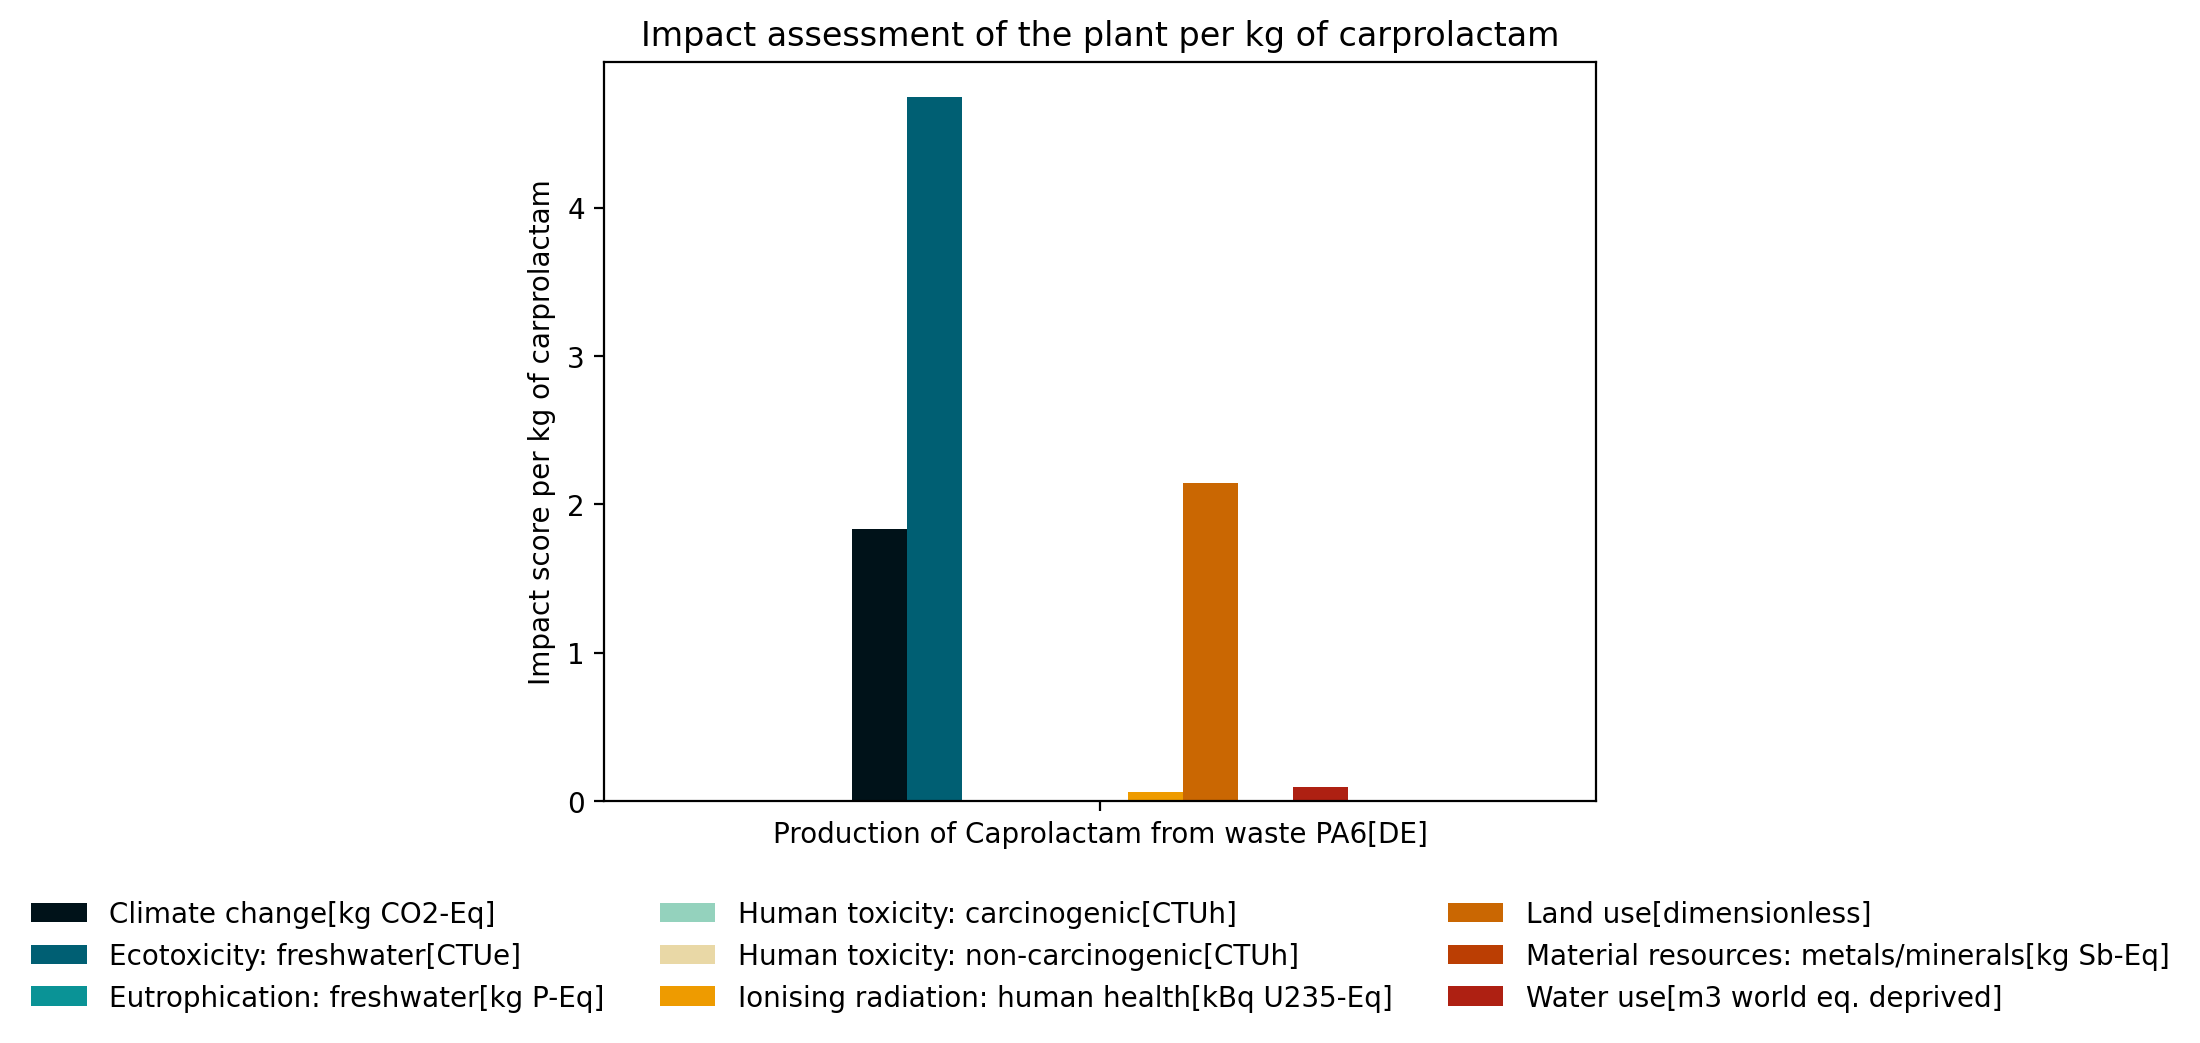

In [55]:
lca_elecmix.plot.bar(rot=0)
plt.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.1),
          fancybox=True,
          shadow=False,
          ncol=3,
          frameon=False)
plt.title("Impact assessment of the plant per kg of carprolactam")
plt.ylabel("Impact score per kg of carprolactam")

### **LCA Contributions of different Categories**

In [56]:
lca_contributions=compute_impacts([BOP,Utility_requirements,Raw_materials, Waste_streams],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice, 
                     )
lca_contributions

,Climate change[kg CO2-Eq],Ecotoxicity: freshwater[CTUe],Eutrophication: freshwater[kg P-Eq],Human toxicity: carcinogenic[CTUh],Human toxicity: non-carcinogenic[CTUh],Ionising radiation: human health[kBq U235-Eq],Land use[dimensionless],Material resources: metals/minerals[kg Sb-Eq],Water use[m3 world eq. deprived]
Balance of plant[DE],0.0244761,0.363714,2.52633e-05,8.54574e-11,2.59503e-09,0.00387011,0.365731,3.36996e-06,0.00997097
Utility requirements HTW amouunt[DE],1.80842,4.08422,0.000274654,4.46818e-10,6.22263e-09,0.055902,1.7661,7.22692e-07,0.0830798
Raw material requirements water change[DE],0.0025416,0.296997,9.11843e-07,2.24954e-12,5.07846e-11,0.000266289,0.0101596,5.04028e-08,0.00586253
Waste treatment[DE],0.312946,2.44132,4.40453e-05,3.4893e-11,4.42832e-10,0.00167031,0.0931832,2.33157e-07,0.0168628


In [57]:
lca_equipment_contrib=compute_impacts([BOP_distillation,BOP_evaporation,BOP_heatexchange,BOP_pumping],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice,                      # choose between "mix" or "wind"
                     )
lca_equipment_contrib.T

,Distillation[DE],Evaporation[DE],Heat Exchange[DE],Pumping[DE]
Climate change[kg CO2-Eq],0.00491613,1.7555e-06,7.10241e-06,0.000749114
Ecotoxicity: freshwater[CTUe],0.0239535,8.82937e-06,4.19514e-05,0.0139949
Eutrophication: freshwater[kg P-Eq],1.78734e-06,5.92585e-10,2.68508e-09,1.0066e-06
Human toxicity: carcinogenic[CTUh],2.75187e-11,8.92206e-15,3.45146e-14,6.16075e-12
Human toxicity: non-carcinogenic[CTUh],1.38882e-10,4.6239e-14,1.90899e-13,1.62432e-10
Ionising radiation: human health[kBq U235-Eq],0.000291622,9.94296e-08,3.31374e-07,4.94562e-05
Land use[dimensionless],0.0285115,9.72557e-06,3.53984e-05,0.00565418
Material resources: metals/minerals[kg Sb-Eq],1.43956e-07,4.68909e-11,1.54127e-10,1.38752e-07
Water use[m3 world eq. deprived],0.00148794,4.9349e-07,2.21375e-06,0.000271636


In [58]:
lca_BOP=compute_impacts([BOP],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice,                      # choose between "mix" or "wind"
                     )
lca_BOP.T

,Balance of plant[DE]
Climate change[kg CO2-Eq],0.0244761
Ecotoxicity: freshwater[CTUe],0.363714
Eutrophication: freshwater[kg P-Eq],2.52633e-05
Human toxicity: carcinogenic[CTUh],8.54574e-11
Human toxicity: non-carcinogenic[CTUh],2.59503e-09
Ionising radiation: human health[kBq U235-Eq],0.00387011
Land use[dimensionless],0.365731
Material resources: metals/minerals[kg Sb-Eq],3.36996e-06
Water use[m3 world eq. deprived],0.00997097


In [59]:
lca_energy = compute_impacts([Utility_heat_steam,Utility_electricty_mix],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice,                      # choose between "mix" or "wind"
                     )
lca_energy.T

,Steam requirements[DE],Electricty requirements[DE]
Climate change[kg CO2-Eq],1.75404,0.0543815
Ecotoxicity: freshwater[CTUe],3.91148,0.172749
Eutrophication: freshwater[kg P-Eq],0.00019682,7.78341e-05
Human toxicity: carcinogenic[CTUh],4.33665e-10,1.31537e-11
Human toxicity: non-carcinogenic[CTUh],5.80818e-09,4.14445e-10
Ionising radiation: human health[kBq U235-Eq],0.043032,0.01287
Land use[dimensionless],1.65098,0.115127
Material resources: metals/minerals[kg Sb-Eq],6.31937e-07,9.07546e-08
Water use[m3 world eq. deprived],0.0731854,0.00989438


In [60]:
lca_utility = compute_impacts([Utility_heat_steam,Utility_electricty_mix],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice,                      # choose between "mix" or "wind"
                     )
lca_utility.T

,Steam requirements[DE],Electricty requirements[DE]
Climate change[kg CO2-Eq],1.75404,0.0543815
Ecotoxicity: freshwater[CTUe],3.91148,0.172749
Eutrophication: freshwater[kg P-Eq],0.00019682,7.78341e-05
Human toxicity: carcinogenic[CTUh],4.33665e-10,1.31537e-11
Human toxicity: non-carcinogenic[CTUh],5.80818e-09,4.14445e-10
Ionising radiation: human health[kBq U235-Eq],0.043032,0.01287
Land use[dimensionless],1.65098,0.115127
Material resources: metals/minerals[kg Sb-Eq],6.31937e-07,9.07546e-08
Water use[m3 world eq. deprived],0.0731854,0.00989438


In [61]:
lca_rawmaterials = compute_impacts([Raw_materials_distwater],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice,                      # choose between "mix" or "wind"
                     )
lca_rawmaterials.T

,Water requirements[DE]
Climate change[kg CO2-Eq],0.0025416
Ecotoxicity: freshwater[CTUe],0.296997
Eutrophication: freshwater[kg P-Eq],9.11843e-07
Human toxicity: carcinogenic[CTUh],2.24954e-12
Human toxicity: non-carcinogenic[CTUh],5.07846e-11
Ionising radiation: human health[kBq U235-Eq],0.000266289
Land use[dimensionless],0.0101596
Material resources: metals/minerals[kg Sb-Eq],5.04028e-08
Water use[m3 world eq. deprived],0.00586253


In [62]:
lca_waste = compute_impacts([Waste_streams],                                                # Or compute several models e.g. [model1,model2]
                     impacts,
                     functional_unit=1, 
                     years = 15, 
                     Capacity_factor = 0.9,
                     electricity_source=electricity_choice,                      # choose between "mix" or "wind"
                     )
lca_waste.T

,Waste treatment[DE]
Climate change[kg CO2-Eq],0.312946
Ecotoxicity: freshwater[CTUe],2.44132
Eutrophication: freshwater[kg P-Eq],4.40453e-05
Human toxicity: carcinogenic[CTUh],3.4893e-11
Human toxicity: non-carcinogenic[CTUh],4.42832e-10
Ionising radiation: human health[kBq U235-Eq],0.00167031
Land use[dimensionless],0.0931832
Material resources: metals/minerals[kg Sb-Eq],2.33157e-07
Water use[m3 world eq. deprived],0.0168628


In [63]:
# Extract the 'Climate change' rows
cc_rawmaterials = lca_rawmaterials.T.loc['Climate change[kg CO2-Eq]']
cc_BOP = lca_BOP.T.loc['Climate change[kg CO2-Eq]']
cc_energy = lca_energy.T.loc['Climate change[kg CO2-Eq]']
cc_waste = lca_waste.T.loc['Climate change[kg CO2-Eq]']

# Combine these into a new DataFrame
climate_change_df = pd.DataFrame({
    'Energy': cc_energy,
    'Raw Materials': cc_rawmaterials,
    'BOP': cc_BOP,
    'Waste': cc_waste,
})

# Filling NaN with zeros if any
climate_change_df.fillna(0, inplace=True)

# Transpose the DataFrame to match the format for a stacked bar chart in Excel
climate_change_df = climate_change_df.T  # Categories are now rows, subcategories are columns

# Remove the last four characters '[DE]' from each subcategory name
climate_change_df.columns = [col[:-4] for col in climate_change_df.columns]

# Print the DataFrame to verify the changes
print(climate_change_df)

               Balance of plant  Electricty requirements  Steam requirements  \
Energy                        0                0.0543815             1.75404   
Raw Materials                 0                        0                   0   
BOP                   0.0244761                        0                   0   
Waste                         0                        0                   0   

               Waste treatment  Water requirements  
Energy                       0                   0  
Raw Materials                0           0.0025416  
BOP                          0                   0  
Waste                 0.312946                   0  


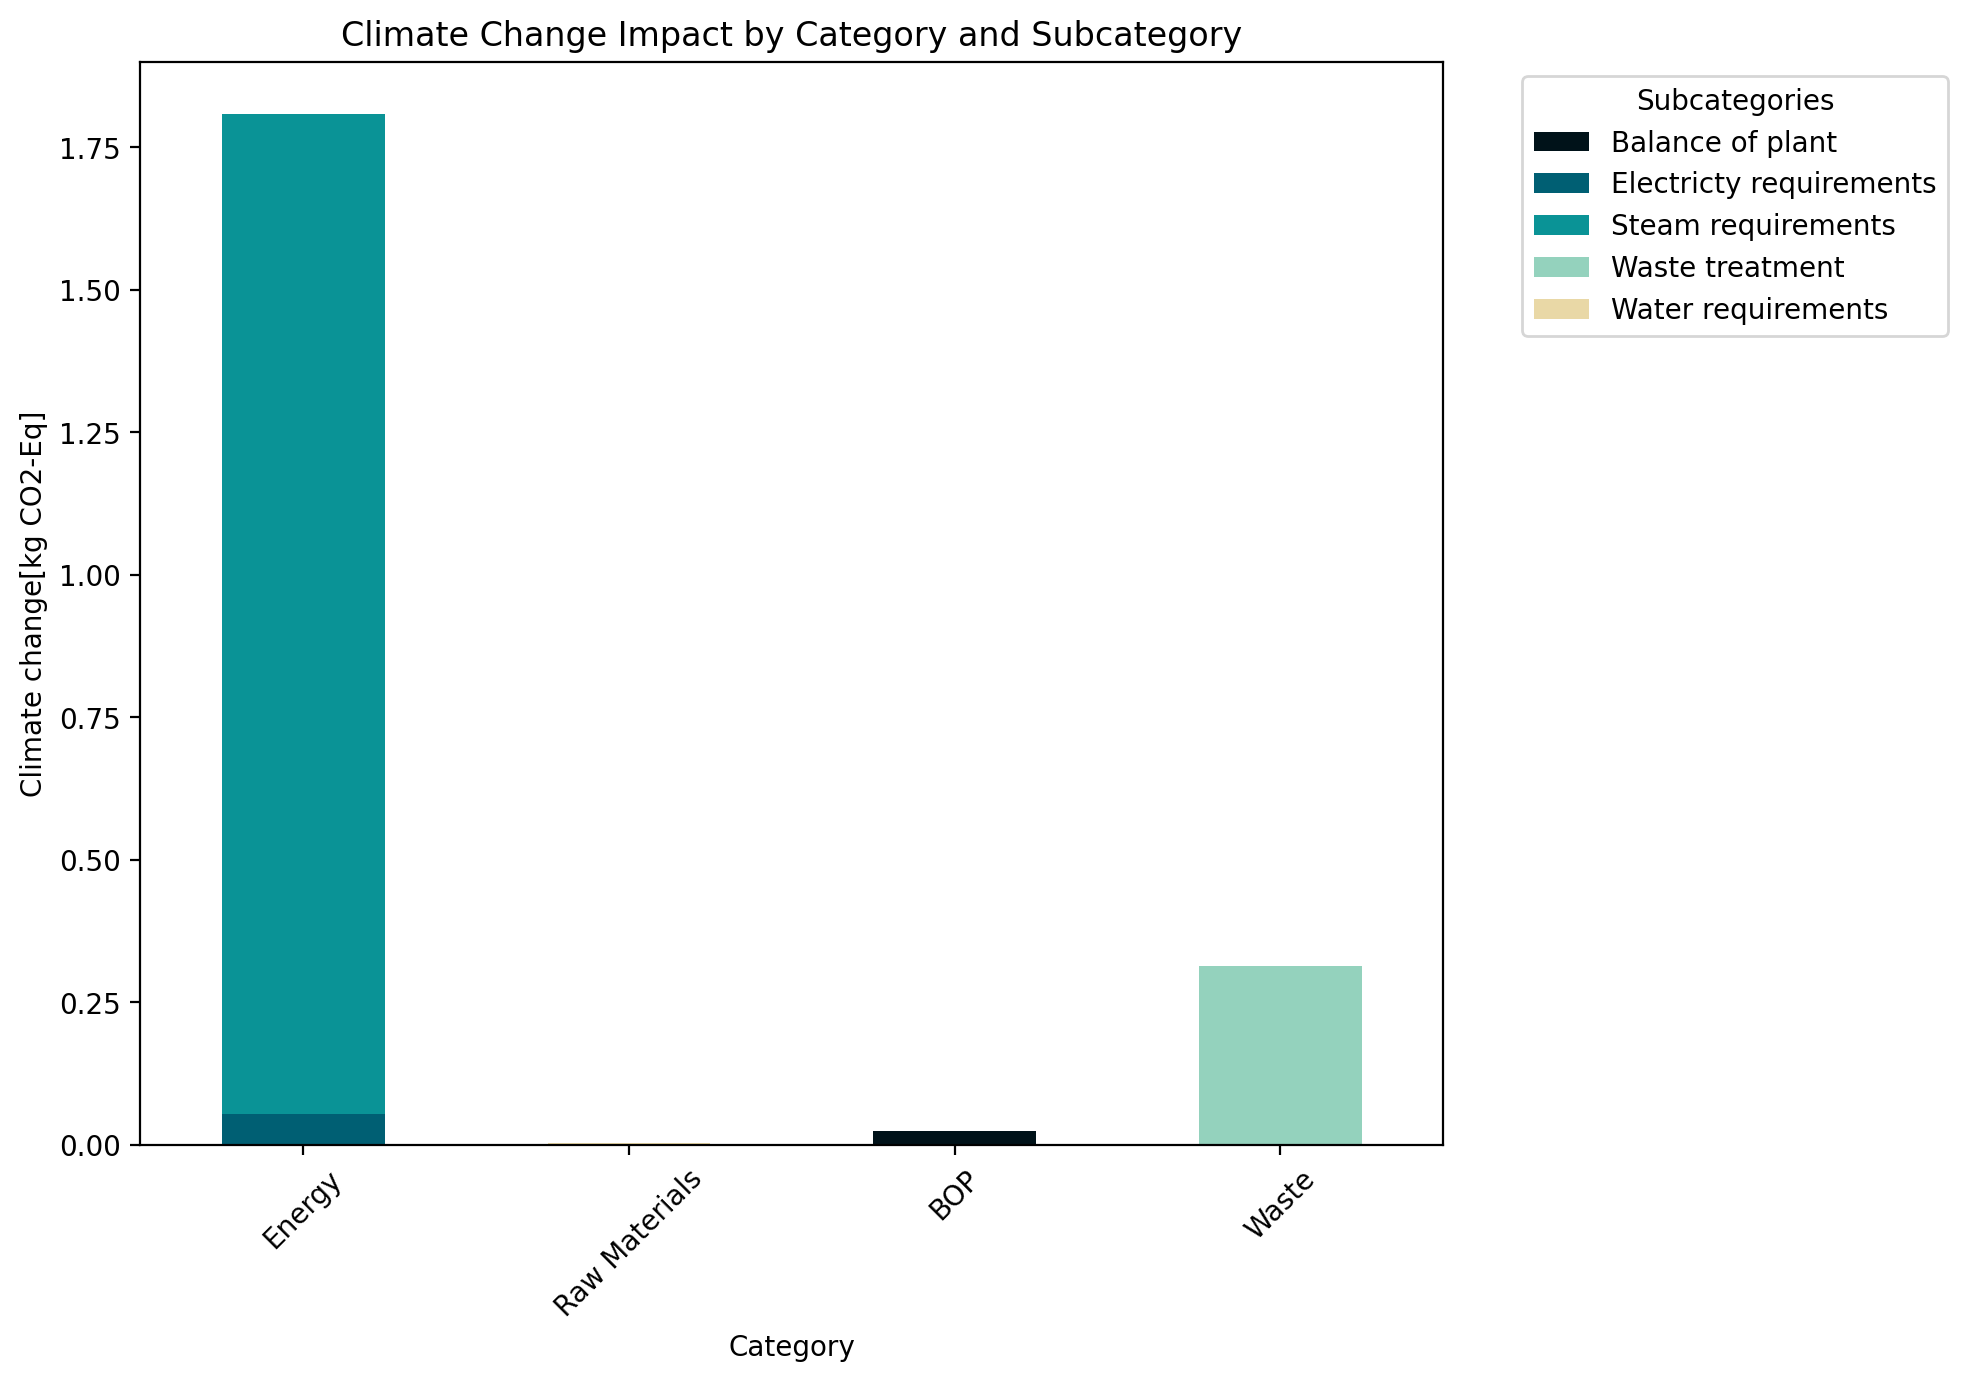

In [64]:
import matplotlib.pyplot as plt

# Assuming 'climate_change_df' is your DataFrame from the previous steps

# Create a stacked bar chart
climate_change_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# Add titles and labels
plt.title('Climate Change Impact by Category and Subcategory')
plt.xlabel('Category')
plt.ylabel('Climate change[kg CO2-Eq]')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Subcategories', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

Text(0, 0.5, '')

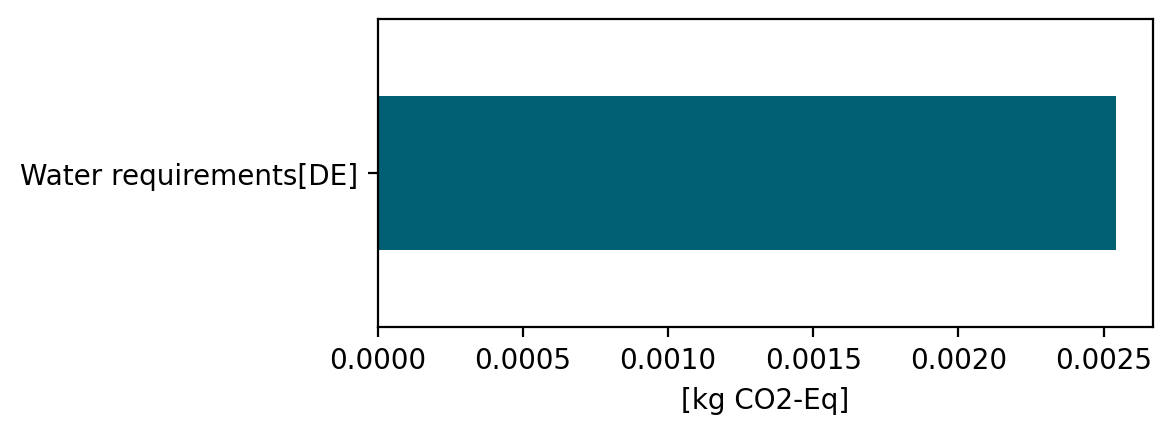

In [65]:
lca_rawmaterials["Climate change[kg CO2-Eq]"].plot.barh(subplots=False, figsize=(5, 2),color=pal[1])
plt.xlabel("[kg CO2-Eq]")
plt.ylabel(None)

Text(0, 0.5, '')

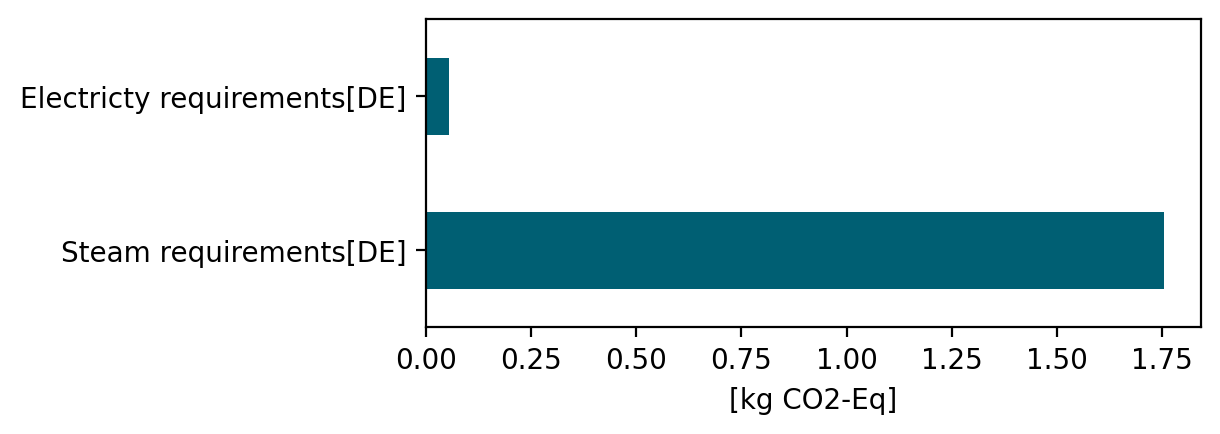

In [66]:
lca_utility["Climate change[kg CO2-Eq]"].plot.barh(subplots=False, figsize=(5, 2),color=pal[1])
plt.xlabel("[kg CO2-Eq]")
plt.ylabel(None)

Text(0, 0.5, '')

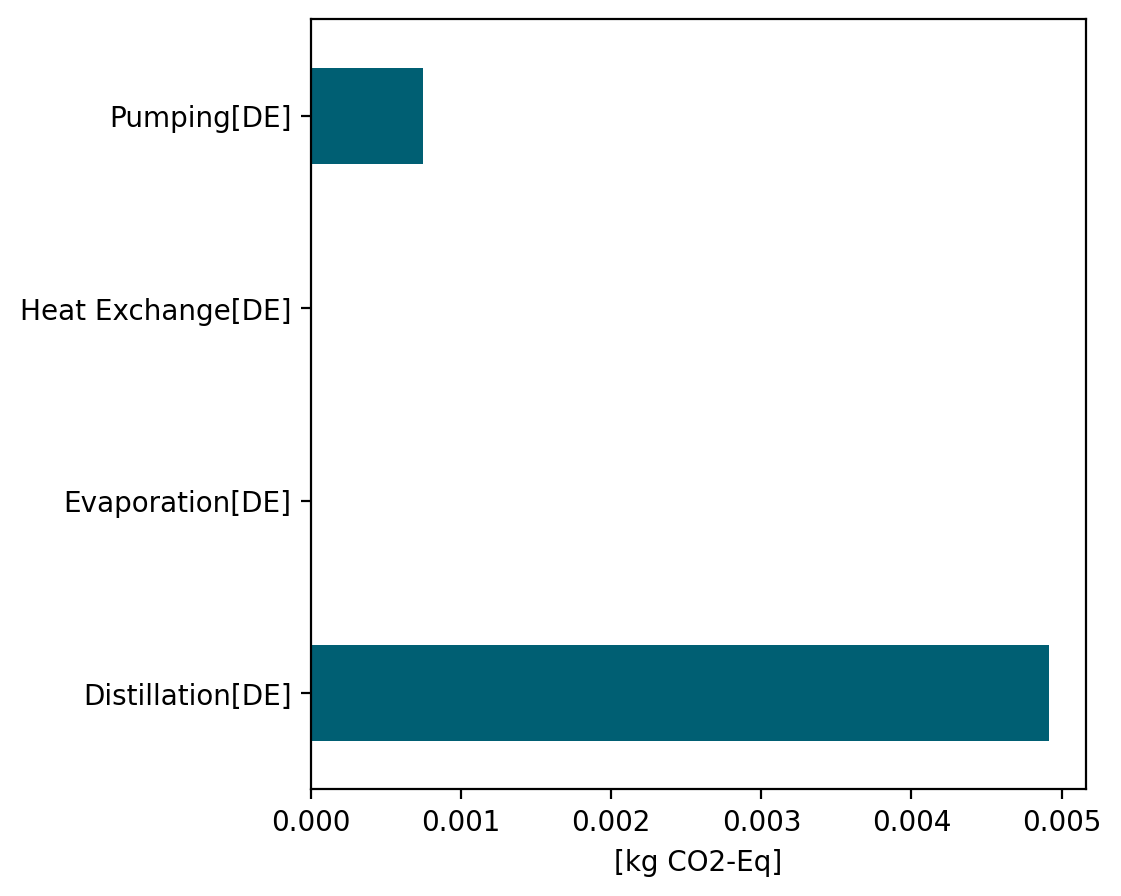

In [67]:
lca_equipment_contrib["Climate change[kg CO2-Eq]"].plot.barh(subplots=False, figsize=(5, 5),color=pal[1])
plt.xlabel("[kg CO2-Eq]")
plt.ylabel(None)

Text(0, 0.5, '')

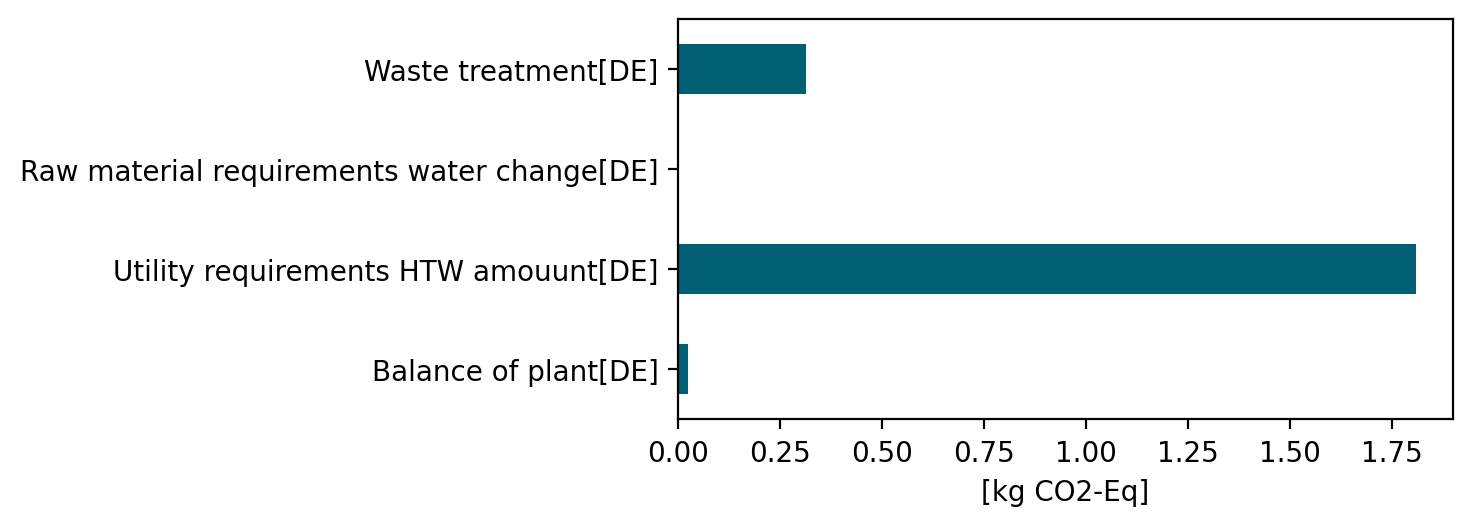

In [68]:
lca_contributions["Climate change[kg CO2-Eq]"].plot.barh(subplots=False, figsize=(5, 2.6),color=pal[1])
plt.xlabel("[kg CO2-Eq]")
plt.ylabel(None)

In [69]:
Contributions = pd.concat([lca_energy, lca_rawmaterials, lca_BOP]).T
Contributions

,Steam requirements[DE],Electricty requirements[DE],Water requirements[DE],Balance of plant[DE]
Climate change[kg CO2-Eq],1.75404,0.0543815,0.0025416,0.0244761
Ecotoxicity: freshwater[CTUe],3.91148,0.172749,0.296997,0.363714
Eutrophication: freshwater[kg P-Eq],0.00019682,7.78341e-05,9.11843e-07,2.52633e-05
Human toxicity: carcinogenic[CTUh],4.33665e-10,1.31537e-11,2.24954e-12,8.54574e-11
Human toxicity: non-carcinogenic[CTUh],5.80818e-09,4.14445e-10,5.07846e-11,2.59503e-09
Ionising radiation: human health[kBq U235-Eq],0.043032,0.01287,0.000266289,0.00387011
Land use[dimensionless],1.65098,0.115127,0.0101596,0.365731
Material resources: metals/minerals[kg Sb-Eq],6.31937e-07,9.07546e-08,5.04028e-08,3.36996e-06
Water use[m3 world eq. deprived],0.0731854,0.00989438,0.00586253,0.00997097


Text(0, 0.5, '')

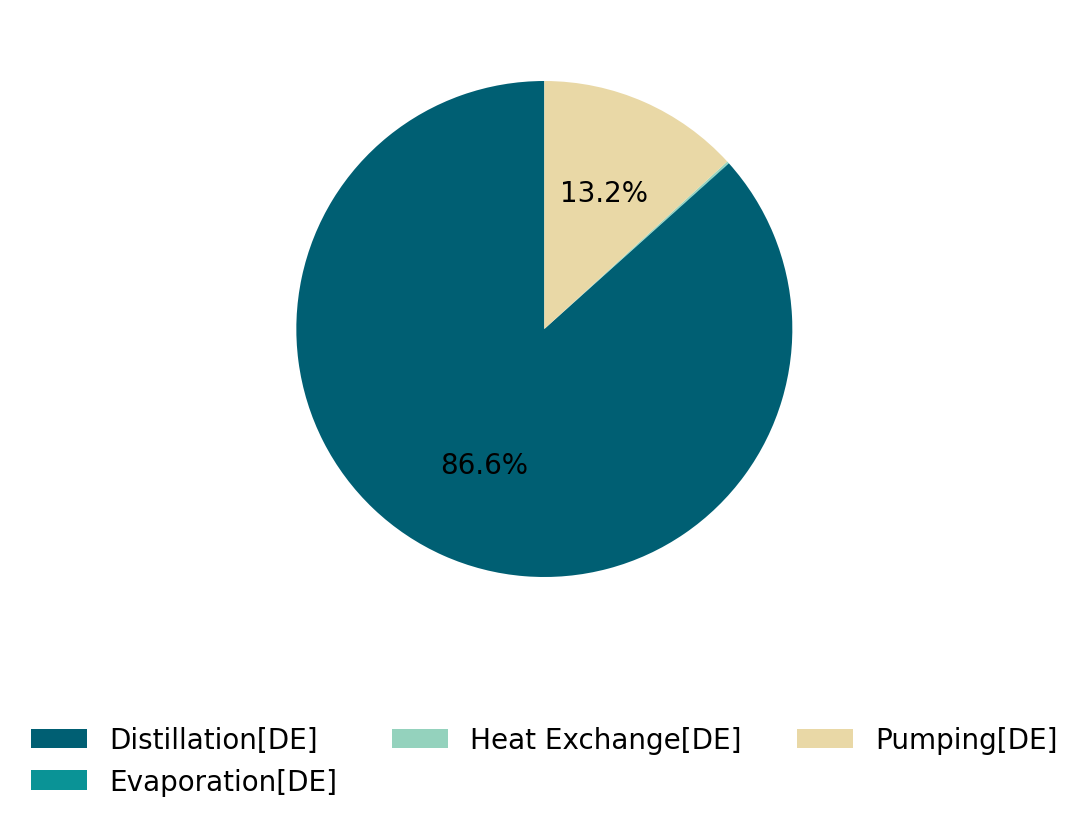

In [70]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if pct < 1:
            return ''
        else:
            return  '{p:.1f}%'.format(p=pct)
    return my_autopct

lca_equipment_contrib["Climate change[kg CO2-Eq]"].plot.pie(subplots=False, figsize=(4, 5), legend=False, startangle=90,labels=None,autopct=make_autopct(lca_equipment_contrib["Climate change[kg CO2-Eq]"]),colors=pal[1:])
labels= [str(a) for a in lca_equipment_contrib.index]
labels = [ind.split("(")[0] for ind in labels]
plt.legend(labels,loc='upper center',
          bbox_to_anchor=(0.5, -0.1),
          fancybox=True,
          shadow=False,
          ncol=3,
          frameon=False)
plt.xlabel(None)
plt.ylabel(None)

In [71]:
Contributions2 = pd.concat([lca_energy, lca_rawmaterials, lca_BOP,lca_waste]).T
Contributions2

Contributions=Contributions2.T.copy()

In [72]:
Contributions

,Climate change[kg CO2-Eq],Ecotoxicity: freshwater[CTUe],Eutrophication: freshwater[kg P-Eq],Human toxicity: carcinogenic[CTUh],Human toxicity: non-carcinogenic[CTUh],Ionising radiation: human health[kBq U235-Eq],Land use[dimensionless],Material resources: metals/minerals[kg Sb-Eq],Water use[m3 world eq. deprived]
Steam requirements[DE],1.75404,3.91148,0.00019682,4.33665e-10,5.80818e-09,0.043032,1.65098,6.31937e-07,0.0731854
Electricty requirements[DE],0.0543815,0.172749,7.78341e-05,1.31537e-11,4.14445e-10,0.01287,0.115127,9.07546e-08,0.00989438
Water requirements[DE],0.0025416,0.296997,9.11843e-07,2.24954e-12,5.07846e-11,0.000266289,0.0101596,5.04028e-08,0.00586253
Balance of plant[DE],0.0244761,0.363714,2.52633e-05,8.54574e-11,2.59503e-09,0.00387011,0.365731,3.36996e-06,0.00997097
Waste treatment[DE],0.312946,2.44132,4.40453e-05,3.4893e-11,4.42832e-10,0.00167031,0.0931832,2.33157e-07,0.0168628


In [73]:
contr_perc = Contributions.T.div(Contributions.T.sum(1),axis=0)
print(contr_perc)
contr_perc.index= ind_clean
def change_units(scores,method_units):
    label_list = []
    for i in range(len(scores)):
        if method_units[i] == "kg CO2-Eq":
            score = scores.iloc[i]*1000
            if score<1000:
                label = "{:.3g}".format(score) + " g CO$_{2}$ eq."
            else:
                label = "{:.1f}".format(score) + " g CO2-Eq"
            label_list.append(label)
        if method_units[i] in ["kg P-Eq", "kg PO4-Eq"] :
            score = scores.iloc[i]*1000000
            label = "{:.3g}".format(score) + " mg PO$_{4}^{3-}$ eq."
            label_list.append(label)
        if method_units[i] in ["kg U235-Eq", "kBq U235-Eq"]:
            score = scores.iloc[i]*1000
            label = "{:.3g}".format(score) + " g $^{235}$U eq."
            label_list.append(label)
        if method_units[i] == "CTUe":
            score = scores.iloc[i]*1000
            label = "{:.3g}".format(score) + " mCTUe"
            label_list.append(label)
        if method_units[i] == "CTUh":
            score = scores.iloc[i]*1000000000
            label = "{:.3g}".format(score) + " nCTUh"
            label_list.append(label)
        if method_units[i] in ["points", "dimensionless"]:
            score = scores.iloc[i]
            label = "{:.3g}".format(score) + " points"
            label_list.append(label)
        if method_units[i] in ["m3 water-.", "m3 world eq. deprived"]:
            score = scores.iloc[i]*1000
            label = "{:.3g}".format(score/42.95) + " l water"
            label_list.append(label)
        if method_units[i] == "kg Sb-Eq":
            score = scores.iloc[i]*1000000
            label = "{:.3g}".format(score) + " mg Sb eq."
            label_list.append(label)
    return label_list

def get_human_methods(ca_methods):
    method_units = []
    method_names = []
    for method in ca_methods:
        method_unit = bd.methods.get(method).get('unit')
        method_names.append(method[-1][0].upper() + method[-1][1:])
        method_units.append(method_unit)
    return method_units, method_names

method_units, _ = get_human_methods(impacts)

                                               Steam requirements[DE]  \
Climate change[kg CO2-Eq]                                    0.816446   
Ecotoxicity: freshwater[CTUe]                                  0.5443   
Eutrophication: freshwater[kg P-Eq]                          0.570701   
Human toxicity: carcinogenic[CTUh]                           0.761592   
Human toxicity: non-carcinogenic[CTUh]                       0.623779   
Ionising radiation: human health[kBq U235-Eq]                0.697341   
Land use[dimensionless]                                      0.738633   
Material resources: metals/minerals[kg Sb-Eq]                0.144403   
Water use[m3 world eq. deprived]                             0.632129   

                                               Electricty requirements[DE]  \
Climate change[kg CO2-Eq]                                        0.0253127   
Ecotoxicity: freshwater[CTUe]                                    0.0240388   
Eutrophication: freshwater[kg P-Eq]

In [74]:
abbreviations = {
    'Climate change': 'GWP',
    'Ecotoxicity: freshwater': 'FET',
    'Eutrophication: freshwater': 'EP',
    'Human toxicity: carcinogenic': 'HTC',
    'Human toxicity: non-carcinogenic': 'HTNC',
    'Ionising radiation: human health': 'IR',
    'Land use': 'LU',
    'Material resources: metals/minerals': 'ADP',
    'Water use': 'WDP'
}

# Replace full names in contr_perc.index with abbreviations
contr_perc.index = contr_perc.index.map(abbreviations)

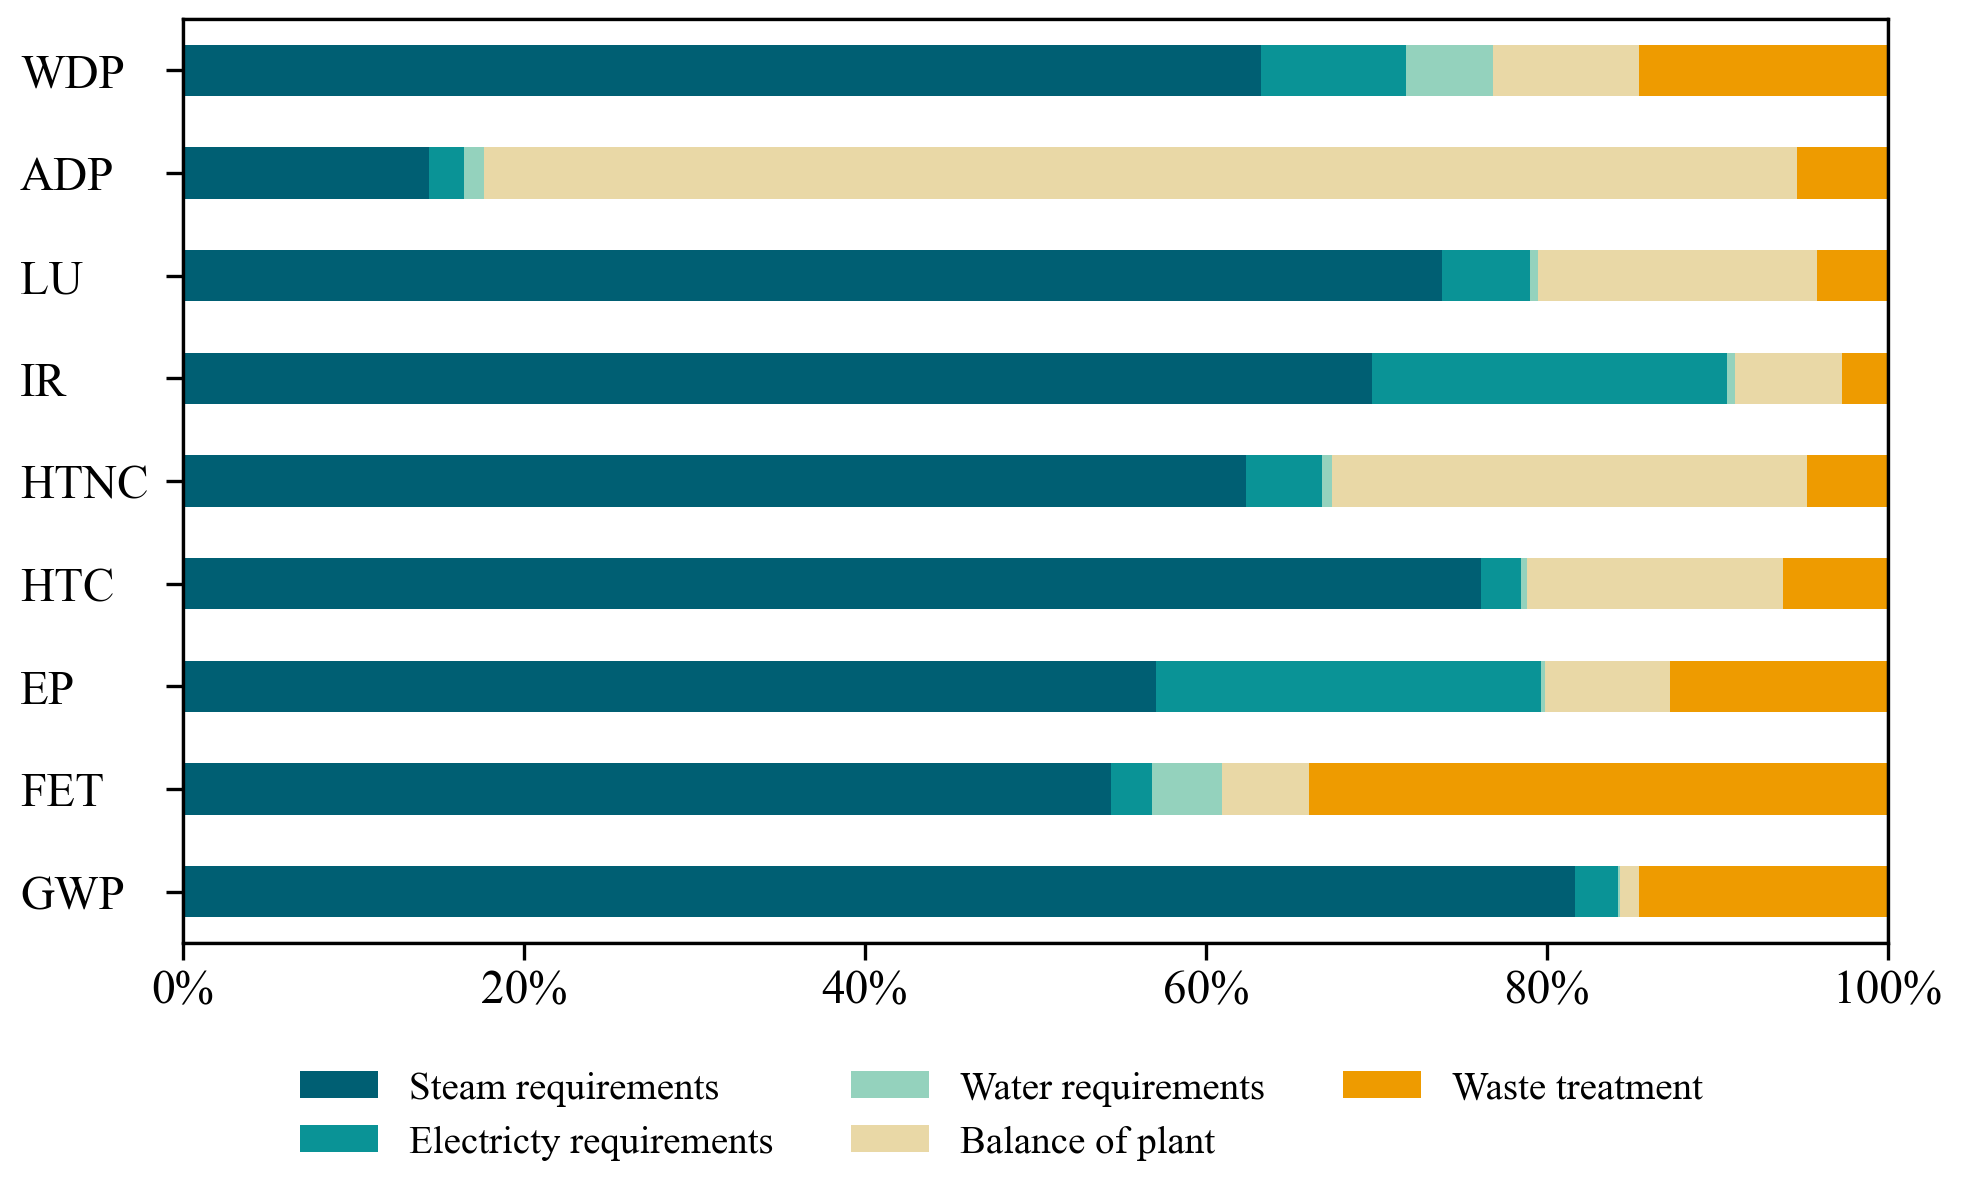

In [75]:
pal = ["#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#bb3e03","#9b2226"]

# Set Times New Roman as the font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', pal)
plt.rcParams['lines.linewidth'] = 1.5

# Plot with the updated index
ax = contr_perc.plot(kind='barh',
                     stacked=True,
                     figsize=(11,6),
                     mark_right=True,
                     xlim=(0,1),
                     edgecolor='black',  # Add black edges
                     linewidth=0.0)

# Set y-axis labels with increased font size
ax.set_yticklabels(contr_perc.index, ha='left', position=(-0.08, 0), fontsize=17)  # Adjust 'fontsize' as needed

# Set x-axis tick labels with increased font size
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=17)  # Adjust 'fontsize' as needed

# Make outer box lines thicker
for spine in ax.spines.values():
    spine.set_linewidth(1.2)  # Set width for plot box

# Adjust tick parameters for consistent thickness with the outer box
ax.tick_params(axis='both',  # Applies to both x and y axes
               which='major',  # Major ticks
               width=1.2,      # Match the line width of spines
               length=6,       # Length of tick marks (adjust as needed)
               labelsize=17)   # Font size for tick labels

# Adjust legend font size
labels2 = [str(a).replace("[DE]", "").strip() for a in Contributions.index]
labels2 = [ind.split("(")[0] for ind in labels2]
ax.legend(labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=3, frameon=False, fontsize=15)  # Adjust 'fontsize' as needed

# Remove twin axis labels from the right side
ax_values = ax.twinx()
ax_values.set_ylim(ax.get_ylim())
ax_values.set_yticks([])  # Remove tick marks
ax_values.set_yticklabels([])  # Remove labels

ax.legend(labels2,loc='upper center',
          bbox_to_anchor=(0.48, -0.1),
          fancybox=True,
          shadow=False,
          ncol=3,
          frameon=False,
          fontsize=14)

plt.show()

In [76]:
units=["[kg CO2-Eq]","[CTUe]", "[kg P-Eq]", "[CTUh]", "[CTUh]", "[kBq U235-Eq]", "[dimensionless]", "[kg Sb-Eq]", "[m3 world eq. deprived]"]
column_labels= [ind_clean[i] + " " + units[i] for i in range(len(ind_clean))]
Contributions.columns = [column_labels]

### **Functions**

Capacity Factor Dependency

In [77]:
cap_factor = np.linspace(0.01, 1, 100).tolist()
result=[multiLCAAlgebric(Caprolactam, # Or compute several models e.g. [model1,model2]
                        methods= impacts,
                        Capacity_factor=cap_factor,
                        electricity_source=i
                        ) for i in ["mix","wind"]]          
result

[WARNING] multiLCAAlgebric is deprecated, use compute_impacts instead
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[WARNING] multiLCAAlgebric is deprecated, use compute_impacts instead
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was missing, replacing by default value : 15
[INFO] Required param 'years' was m

[                 Climate change[kg CO2-Eq]  Ecotoxicity: freshwater[CTUe]  \
 Capacity_factor                                                             
 0.01                                4.0113                        36.8218   
 0.02                                2.9099                        20.4579   
 0.03                               2.54279                        15.0055   
 0.04                               2.35925                         12.281   
 0.05                               2.24913                        10.6476   
 ...                                    ...                            ...   
 0.96                               1.83408                          4.742   
 0.97                               1.83387                        4.74179   
 0.98                               1.83367                        4.74164   
 0.99                               1.83347                        4.74157   
 1                                  1.83327                     

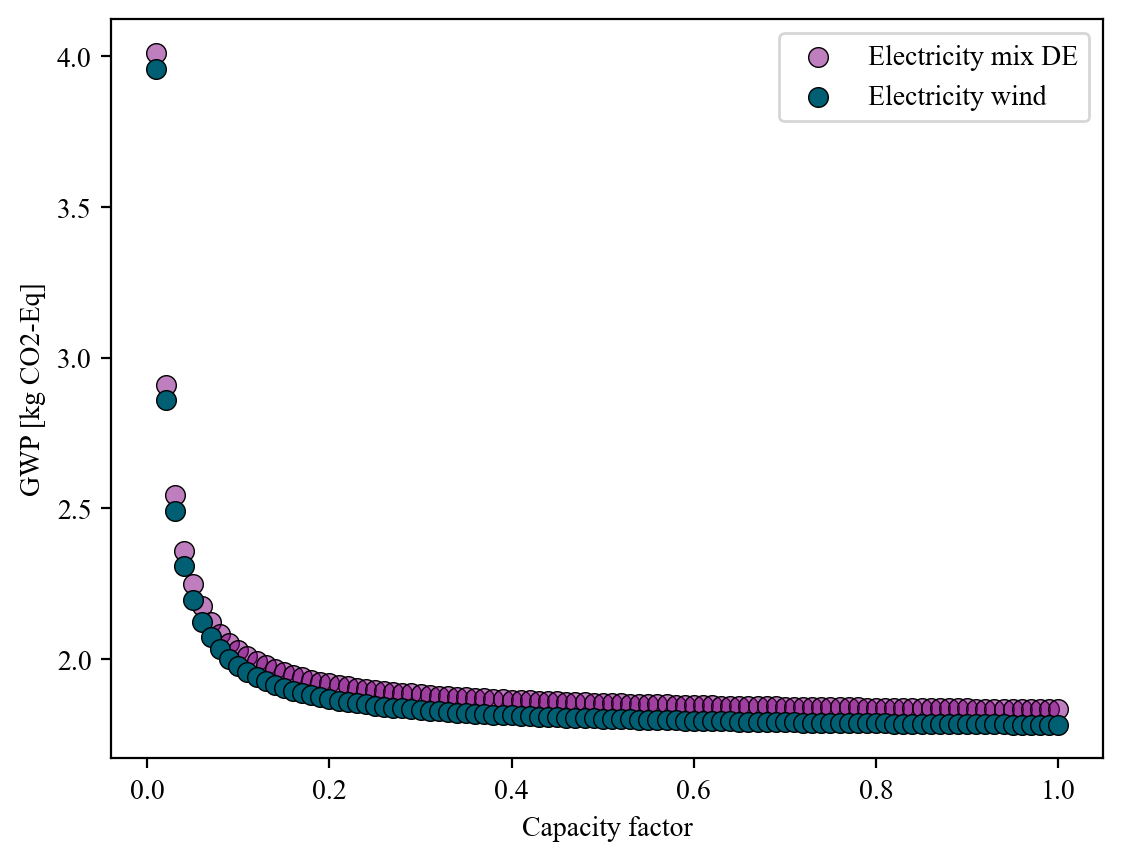

In [78]:
GWP_mix = result[0]["Climate change[kg CO2-Eq]"]
GWP_wind = result[1]["Climate change[kg CO2-Eq]"]

pal1_alpha = to_rgba("purple", alpha=0.5)

plt.scatter(cap_factor, GWP_mix, label="Electricity mix DE", marker="o",facecolor=pal1_alpha, edgecolor="k",linewidth=0.5,s=50)
plt.scatter(cap_factor, GWP_wind, label="Electricity wind", marker="o", edgecolor="k",linewidth=0.5,s=50)
plt.xlabel("Capacity factor")
plt.ylabel("GWP [kg CO2-Eq]")
plt.legend()


#### *Impact Functions in terms of the Parameters*

Create some functions based on the sobol indices and using a montecarlo simulation

In [79]:
simplified = sobol_simplify_model(
    Caprolactam, # The model
    impacts, # Impacts to consider
    n=2**12, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.99999, # Min ratio of variability to explain
    num_digits=3,
    simple_sums=False,
    simple_products=False)

Generating samples ...
Transforming samples ...
Processing sobol for ('EF v3.1', 'climate change', 'global warming potential (GWP100)')


c:\Users\kai\anaconda3\envs\bw2\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)')
Processing sobol for ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)')
Processing sobol for ('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)')
Processing sobol for ('EF v3.1', 'human toxicity: non-carcinogenic, inorganics', 'comparative toxic unit for human (CTUh)')
Processing sobol for ('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235')
Processing sobol for ('EF v3.1', 'land use', 'soil quality index')
Processing sobol for ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
Processing sobol for ('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')
> Method :  Climate change
S1:  0.9980104032148089
S2:  0.0019868510954986277
ST:  1.001991452

0.00282*CapacityFactor + Piecewise((0.0544, Eq(ElectricitySource, Mix)), (0.00215, Eq(ElectricitySource, Wind))) + 1.75 + 0.33/(CapacityFactor*Years)

> Method :  Ecotoxicity: freshwater
S1:  0.9821198986160684
S2:  0.017910520744706226
ST:  1.0179356178720655
Selected params :  ['years', 'electricity_source', 'Capacity_factor'] explains:  0.9821198986160684


0.33*CapacityFactor + Piecewise((0.0138, Eq(ElectricitySource, Wind)), (0.173, Eq(ElectricitySource, Mix))) + 3.91 + 4.91/(CapacityFactor*Years)

> Method :  Eutrophication: freshwater
S1:  0.9989671667415542
S2:  0.0010298128506066387
ST:  1.0010321601139804
Selected params :  ['electricity_source', 'years', 'Capacity_factor'] explains:  0.9989671667415542


1.01e-6*CapacityFactor + Piecewise((1.0e-6, Eq(ElectricitySource, Wind)), (7.78e-5, Eq(ElectricitySource, Mix))) + 0.000197 + 0.000341/(CapacityFactor*Years)

> Method :  Human toxicity: carcinogenic
S1:  0.9814253016053256
S2:  0.018614737373963443
ST:  1.018666787715429
Selected params :  ['years', 'Capacity_factor', 'electricity_source'] explains:  0.9814253016053256


2.5e-12*CapacityFactor + Piecewise((1.1e-11, Eq(ElectricitySource, Wind)), (1.32e-11, Eq(ElectricitySource, Mix))) + 4.34e-10 + 1.15e-9/(CapacityFactor*Years)

> Method :  Human toxicity: non-carcinogenic
S1:  0.9819963510693035
S2:  0.018039325336156452
ST:  1.0180896676360365
Selected params :  ['years', 'Capacity_factor', 'electricity_source'] explains:  0.9819963510693035


5.64e-11*CapacityFactor + Piecewise((8.61e-11, Eq(ElectricitySource, Wind)), (4.14e-10, Eq(ElectricitySource, Mix))) + 5.81e-9 + 3.5e-8/(CapacityFactor*Years)

> Method :  Ionising radiation: human health
S1:  0.9991143443836844
S2:  0.0008826906317664501
ST:  1.0008846161953766
Selected params :  ['electricity_source', 'years', 'Capacity_factor'] explains:  0.9991143443836844


0.000296*CapacityFactor + Piecewise((9.85e-5, Eq(ElectricitySource, Wind)), (0.0129, Eq(ElectricitySource, Mix))) + 0.043 + 0.0522/(CapacityFactor*Years)

> Method :  Land use
S1:  0.9818586076899166
S2:  0.01817763197068383
ST:  1.0182281335395826
Selected params :  ['years', 'Capacity_factor', 'electricity_source'] explains:  0.9818586076899166


0.0113*CapacityFactor + Piecewise((0.0718, Eq(ElectricitySource, Wind)), (0.115, Eq(ElectricitySource, Mix))) + 1.65 + 4.94/(CapacityFactor*Years)

> Method :  Material resources: metals/minerals
S1:  0.9815152715566677
S2:  0.018525058586857317
ST:  1.0185772659392576
Selected params :  ['years', 'Capacity_factor', 'electricity_source'] explains:  0.9815152715566677


5.6e-8*CapacityFactor + Piecewise((6.54e-8, Eq(ElectricitySource, Wind)), (9.08e-8, Eq(ElectricitySource, Mix))) + 6.32e-7 + 4.55e-5/(CapacityFactor*Years)

> Method :  Water use
S1:  0.9914800609042589
S2:  0.00852747371228424
ST:  1.0085420691678717
Selected params :  ['electricity_source', 'years', 'Capacity_factor'] explains:  0.9914800609042589


0.00651*CapacityFactor + Piecewise((0.0099, Eq(ElectricitySource, Mix)), (0.00113, Eq(ElectricitySource, Wind))) + 0.0732 + 0.135/(CapacityFactor*Years)

In [80]:
for i,s in zip(impacts,simplified):
    print(i)
    display(simplify(s.expr.evalf(n=3)))
    print('-'*80)


('EF v3.1', 'climate change', 'global warming potential (GWP100)')


0.00282*Capacity_factor + 0.0544*electricity_source_mix + 0.00215*electricity_source_wind + 1.75 + 0.33/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)')


0.33*Capacity_factor + 0.173*electricity_source_mix + 0.0138*electricity_source_wind + 3.91 + 4.91/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)')


1.01e-6*Capacity_factor + 7.78e-5*electricity_source_mix + 1.0e-6*electricity_source_wind + 0.000197 + 0.000341/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)')


2.5e-12*Capacity_factor + 1.32e-11*electricity_source_mix + 1.1e-11*electricity_source_wind + 4.34e-10 + 1.15e-9/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'human toxicity: non-carcinogenic, inorganics', 'comparative toxic unit for human (CTUh)')


5.64e-11*Capacity_factor + 4.14e-10*electricity_source_mix + 8.61e-11*electricity_source_wind + 5.81e-9 + 3.5e-8/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235')


0.000296*Capacity_factor + 0.0129*electricity_source_mix + 9.85e-5*electricity_source_wind + 0.043 + 0.0522/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'land use', 'soil quality index')


0.0113*Capacity_factor + 0.115*electricity_source_mix + 0.0718*electricity_source_wind + 1.65 + 4.94/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')


5.6e-8*Capacity_factor + 9.08e-8*electricity_source_mix + 6.54e-8*electricity_source_wind + 6.32e-7 + 4.55e-5/(Capacity_factor*years)

--------------------------------------------------------------------------------
('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')


0.00651*Capacity_factor + 0.0099*electricity_source_mix + 0.00113*electricity_source_wind + 0.0732 + 0.135/(Capacity_factor*years)

--------------------------------------------------------------------------------


In [81]:
pal = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

#### *Graphs*

In [82]:
# Define the symbols if they are not yet defined
electricity_source_mix, electricity_source_wind= symbols('electricity_source_mix electricity_source_wind')
Capacity_factor = symbols("Capacity_factor")
x = symbols("x")  # Define 'x' as the new variable

In [83]:
results_electricity_wind_in_terms_of_capacity_factor = simplified[0].expr.subs({years: 15, 
                            electricity_source_mix: 0, electricity_source_wind: 1})

results_electricity_wind_in_terms_of_capacity_factor

0.00282*Capacity_factor + 1.76 + 0.022/Capacity_factor

In [84]:
# Convert the symbolic expression into a function
function_wind_in_terms_of_capacity_factor = lambdify(Capacity_factor, results_electricity_wind_in_terms_of_capacity_factor)

# Now you can evaluate it
print(function_wind_in_terms_of_capacity_factor(0.9))  # Example evaluation

1.7869824444444444


In [85]:
results_electricity_mix_in_terms_of_capacity_factor = simplified[0].expr.subs({years: 15, 
                            electricity_source_mix: 1, electricity_source_wind: 0})

results_electricity_mix_in_terms_of_capacity_factor

0.00282*Capacity_factor + 1.81 + 0.022/Capacity_factor

In [86]:
# Convert the symbolic expression into a function
function_mix_in_terms_of_capacity_factor = lambdify(Capacity_factor, results_electricity_mix_in_terms_of_capacity_factor)

# Now you can evaluate it
print(function_mix_in_terms_of_capacity_factor(0.9))  # Example evaluation

1.8369824444444445


In [87]:
pal = ["#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#bb3e03","#9b2226"]

# Set Times New Roman as the font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', pal)
plt.rcParams['lines.linewidth'] = 1.5

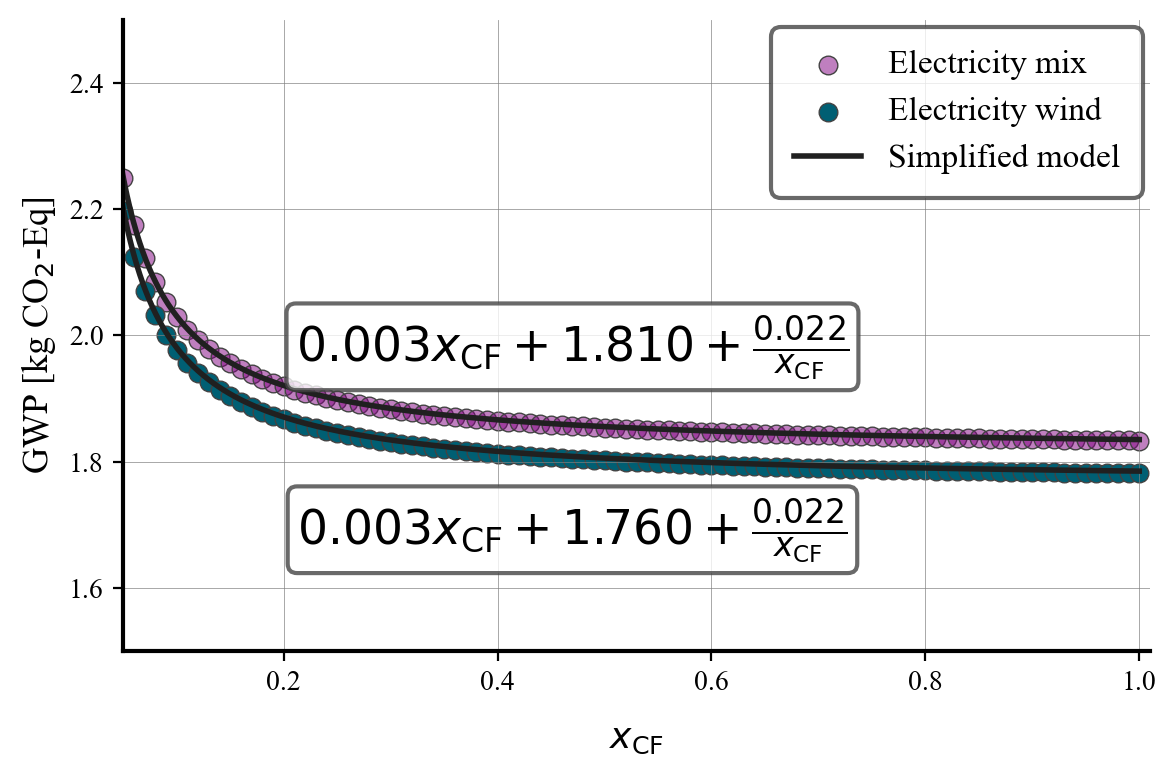

In [88]:
CF=np.linspace(0.0068, 1, 1000) 

GWP_mix = result[0]["Climate change[kg CO2-Eq]"]
GWP_wind = result[1]["Climate change[kg CO2-Eq]"]
plt.figure(figsize=(6,4))

plt.scatter(cap_factor, GWP_mix, label="Electricity mix", marker="o", facecolor=pal1_alpha, edgecolor="#434343",linewidth=0.5,s=45)
plt.scatter(cap_factor, GWP_wind, label="Electricity wind", marker="o", edgecolor="#434343",linewidth=0.5,s=45)

plt.plot(CF, function_wind_in_terms_of_capacity_factor(CF), color="#202020", label="Simplified model", alpha=1, linewidth=2)
plt.plot(CF, function_mix_in_terms_of_capacity_factor(CF), color="#202020", alpha=1, linewidth=2)


plt.xlim(0.05, 1.01)
plt.ylim(1.5, 2.5)
plt.grid(True, which='both', linestyle='-', linewidth=0.3, color='gray', zorder=0, alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.ylabel(r"GWP [kg CO$_2$-Eq]", fontsize=13)
plt.xlabel(r"$x_{\mathrm{CF}}$", fontsize=13, fontweight='bold', labelpad=10)

def latex_format_3decimals(latex_string):
    def repl(match):
        num = float(match.group())
        return f"{num:.3f}"
    return re.sub(r"\d+\.\d+", repl, latex_string)

def replace_x_with_xCF(latex_string):
    return latex_string.replace('x', r'x_{\mathrm{CF}}')

latex_wind = latex(function_wind_in_terms_of_capacity_factor(Capacity_factor).subs(Capacity_factor, x).evalf(7))
equation_wind = r"$" + replace_x_with_xCF(latex_format_3decimals(latex_wind)) + r"$"
latex_mix = latex(function_mix_in_terms_of_capacity_factor(Capacity_factor).subs(Capacity_factor, x).evalf(7))
equation_mix = r"$" + replace_x_with_xCF(latex_format_3decimals(latex_mix)) + r"$"

x_box = 0.47  # adjust as you like!
y_range = plt.ylim()[1] - plt.ylim()[0]
offset = -0.17 * y_range

plt.text(
    x_box, function_wind_in_terms_of_capacity_factor(x_box) + offset,
    equation_wind,
    fontsize=17, fontweight='bold', ha='center', va='bottom',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='#434343', boxstyle="round,pad=0.2", linewidth=1.5),
    zorder=10, clip_on=False, transform=plt.gca().transData
)

offset = 0.07 * y_range
plt.text(
    x_box, function_mix_in_terms_of_capacity_factor(x_box) + offset,
    equation_mix,
    fontsize=17, fontweight='bold', ha='center', va='bottom',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='#434343', boxstyle="round,pad=0.2", linewidth=1.5),
    zorder=10, clip_on=False, transform=plt.gca().transData
)

leg = plt.legend(
    fontsize=12,
    frameon=True,
    framealpha=0.8,
    edgecolor='#434343',
    loc="upper right"
)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_boxstyle("round,pad=0.3")

plt.tight_layout()


#### *Functions*

In [89]:
results_electricity_wind_withprepuri_in_terms_of_years_cap_conv_water = simplified[0].expr.subs({
                            electricity_source_mix: 0, electricity_source_wind: 1})

results_electricity_wind_withprepuri_in_terms_of_years_cap_conv_water

0.00282*Capacity_factor + 1.76 + 0.33/(Capacity_factor*years)

In [90]:
# Convert the symbolic expression into a function
function_electricity_wind_withprepuri_in_terms_of_years_cap_conv_water = lambdify(
    [Capacity_factor, years], results_electricity_wind_withprepuri_in_terms_of_years_cap_conv_water)

# Now you can evaluate it
print(function_electricity_wind_withprepuri_in_terms_of_years_cap_conv_water(0.9,15))  # Example evaluation

latex_str = latex(results_electricity_wind_withprepuri_in_terms_of_years_cap_conv_water)
print(latex_str)


1.7869824444444444
0.00282 Capacity_{factor} + 1.76 + \frac{0.33}{Capacity_{factor} years}


### **Sensitivity and Statistical Analysis (Monte Carlo)**

#### *Parameter Sensitivity*

It is the stochastic analysis. It runs several LCA calculations with random values for the parameters given the defined bound and distribution types. this entire part is for the sensitivity analysis of parameters.

Allows to see which parameter is the most sensitive to the results. a more detailed analysis on that parameter can be perfomed then. the functions in dependence of parameters (below), are using the most sensitive parameters and other small impact parameters are neglected. That graph is to see which parameter is the most sensitive.

In [91]:
problem, _, X = stats._stochastics(Caprolactam, impacts, 2**15, var_params=["years", "Capacity_factor", "electricity_source"])

Generating samples ...
Transforming samples ...


In [92]:
problem

{'num_vars': 3,
 'names': ['years', 'Capacity_factor', 'electricity_source'],
 'bounds': [[0, 1], [0, 1], [0, 1]],
 'sample_scaled': True}

In [93]:
X

Climate change[kg CO2-Eq]  \
years   Capacity_factor electricity_source                              
10.083  0.94799         wind                                  1.79344   
12.3011 0.94799         wind                                  1.78721   
10.083  0.763617        wind                                  1.80127   
        0.94799         mix                                   1.84567   
        0.763617        mix                                   1.85349   
...                                                               ...   
10.0833 0.503248        wind                                  1.82273   
        0.630697        wind                                  1.80993   
18.9014 0.503248        wind                                  1.79235   
        0.630697        wind                                  1.78569   
                        wind                                  1.78569   

                                            Ecotoxicity: freshwater[CTUe]  \
years   Capacity_factor electricity_source                                  
10.083  0.94799         wind                                      4.75179   
12.3011 0.94799         wind                                      4.65916   
10.083  0.763617        wind                                      4.81498   
        0.94799         mix                                       4.91074   
        0.763617        mix                                       4.97393   
...                                                                   ...   
10.0833 0.503248        wind                                      5.05896   
        0.630697        wind                                      4.90549   
18.9014 0.503248        wind                                      4.60754   
        0.630697        wind                                      4.54529   
                        wind                                      4.54529   

                                            Eutrophication: freshwater[kg P-Eq]  \
years   Capacity_factor electricity_source                                        
10.083  0.94799         wind                                        0.000234463   
12.3011 0.94799         wind                                        0.000228029   
10.083  0.763617        wind                                        0.000242891   
        0.94799         mix                                         0.000311295   
        0.763617        mix                                         0.000319723   
...                                                                         ...   
10.0833 0.503248        wind                                        0.000265543   
        0.630697        wind                                         0.00025209   
18.9014 0.503248        wind                                        0.000234187   
        0.630697        wind                                        0.000227071   
                        wind                                        0.000227071   

                                            Human toxicity: carcinogenic[CTUh]  \
years   Capacity_factor electricity_source                                       
10.083  0.94799         wind                                        5.6774e-10   
12.3011 0.94799         wind                                       5.45977e-10   
10.083  0.763617        wind                                       5.96421e-10   
        0.94799         mix                                        5.69883e-10   
        0.763617        mix                                        5.98563e-10   
...                                                                        ...   
10.0833 0.503248        wind                                       6.73285e-10   
        0.630697        wind                                       6.27661e-10   
18.9014 0.503248        wind                                       5.67219e-10   
        0.630697        wind                                       5.43029e-10   
                        wind

In [94]:

sob = stats._sobols(impacts, problem, X)

Processing sobol for ('EF v3.1', 'climate change', 'global warming potential (GWP100)')


c:\Users\kai\anaconda3\envs\bw2\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)')
Processing sobol for ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)')
Processing sobol for ('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)')
Processing sobol for ('EF v3.1', 'human toxicity: non-carcinogenic, inorganics', 'comparative toxic unit for human (CTUh)')
Processing sobol for ('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235')
Processing sobol for ('EF v3.1', 'land use', 'soil quality index')
Processing sobol for ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
Processing sobol for ('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')


In [95]:
stats._incer_stochastic_matrix(impacts, problem['names'], X, sob, save=True, filename="HTWSensitivity")

interactive(children=(Dropdown(description='indice', index=1, options=('s1', 'st'), value='st'), Dropdown(desc…

#### *LCA Distributions*

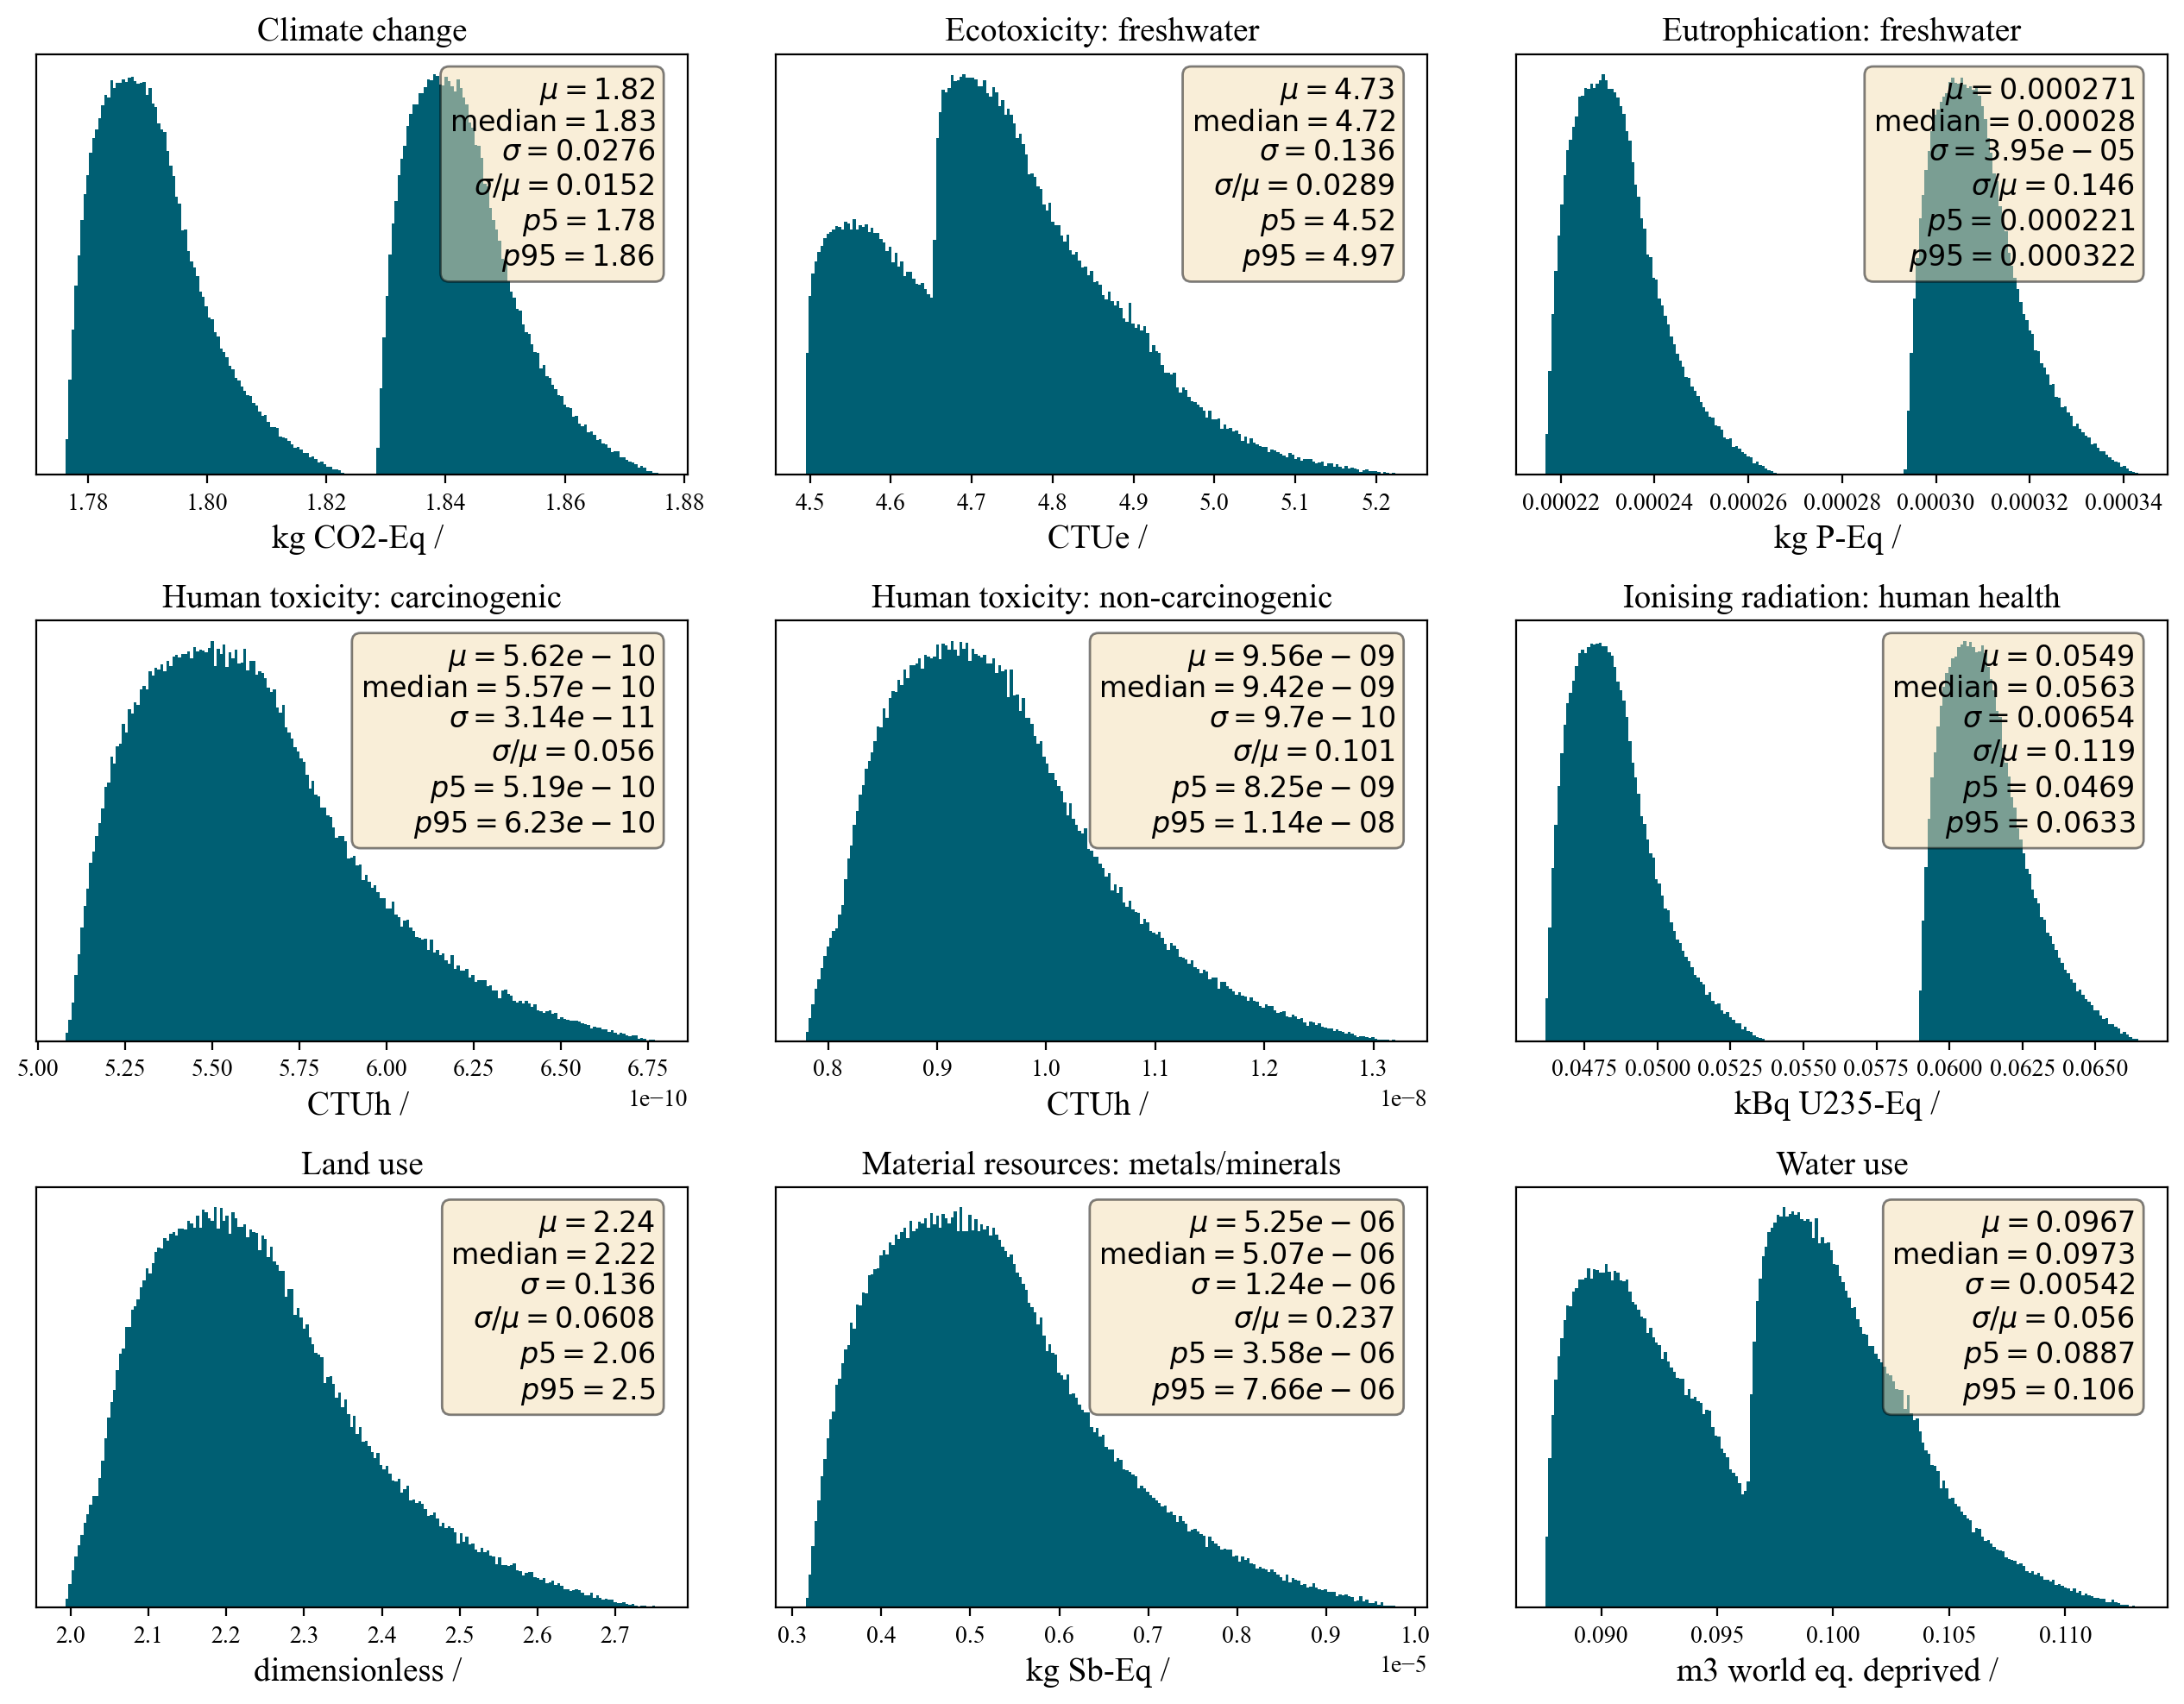

In [96]:
pal = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

problem_X_sob = {'problem':problem, 'Y':X, 'sob':sob}
with open('problem_Y_sob.pickle','wb') as f:
    pickle.dump(problem_X_sob, f)


plt.rcParams["axes.prop_cycle"] = plt.cycler('color', pal[1:])

fig, axes = plt.subplots(3,3,figsize=(13,10))


d = distrib(
    Caprolactam,
    impacts,
    Y=X,
    
    # Optional layout parameters
    axes=axes,
    percentiles=[5, 95])

for ax in axes.flatten():
    ax.set_title(ax.get_title().replace(' - ','\n'), fontsize=14)

# Adjust layout and spacing between subplots
plt.subplots_adjust(left=None, right=None, top=None, bottom=None, wspace=2, hspace=2)

plt.tight_layout()


 violin graphs : the exact probabilistic distribution for each impact. Together with medians of the impacts.

Generating samples ...
Transforming samples ...


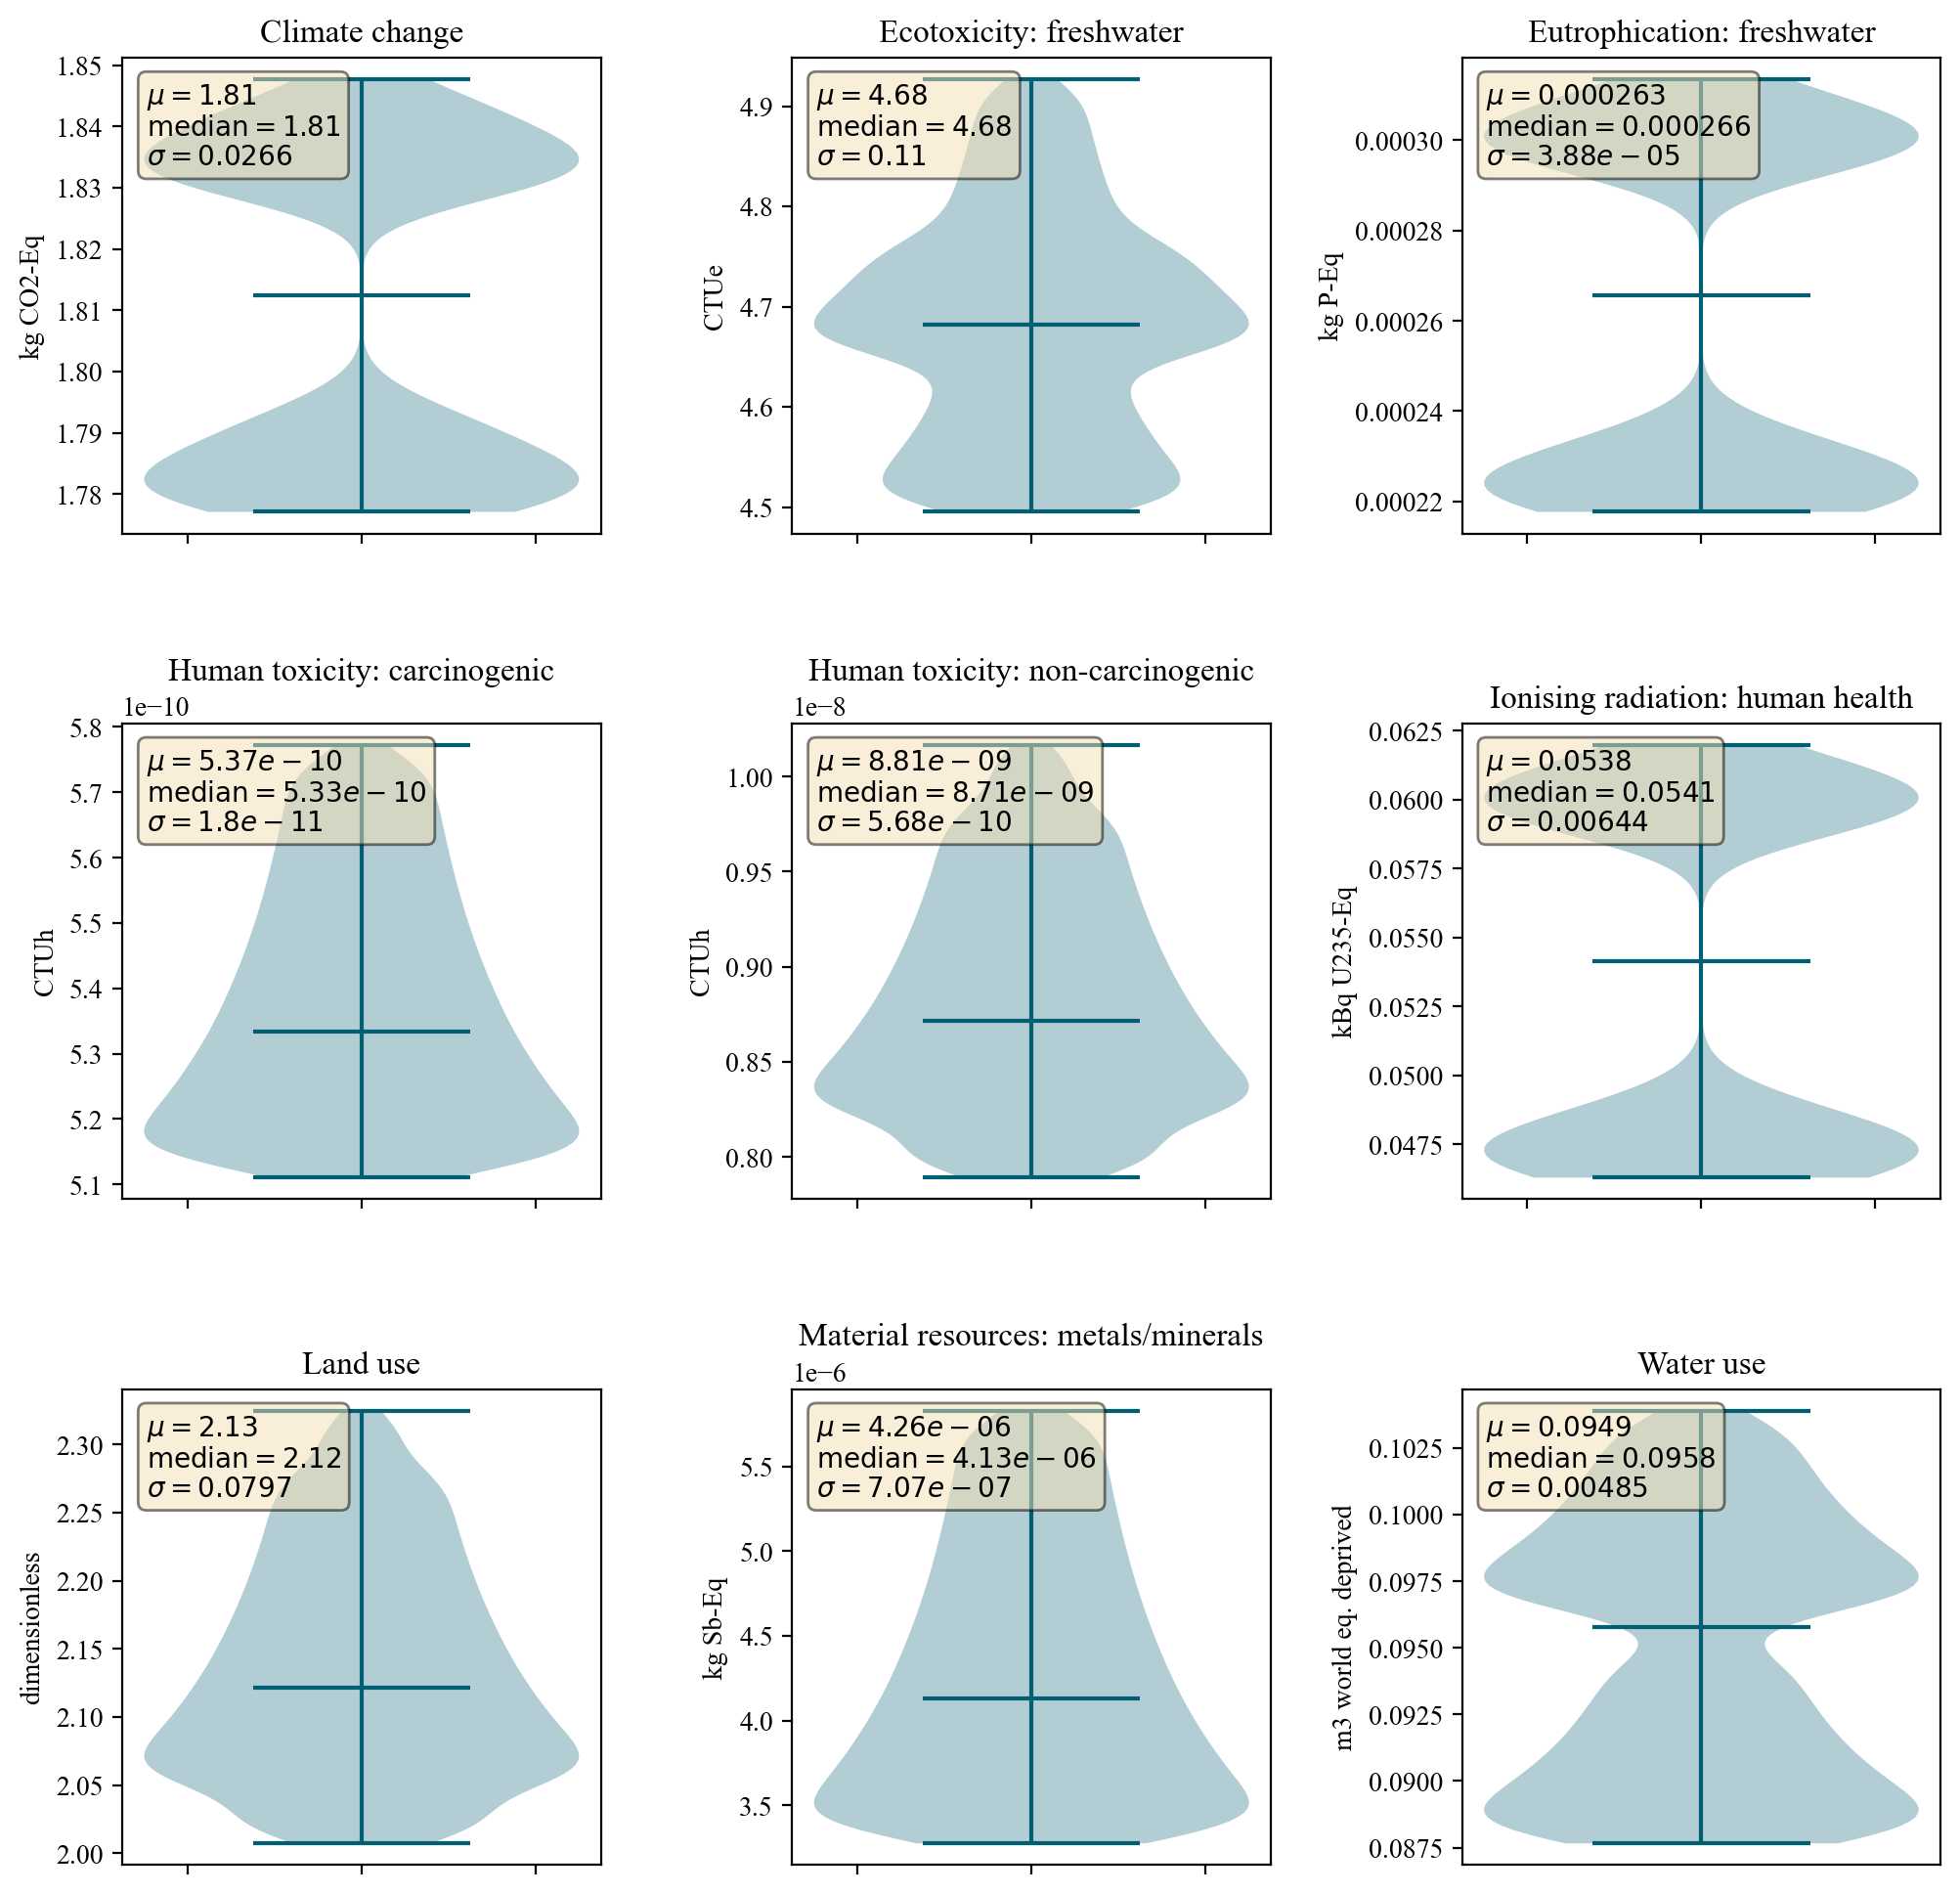

In [97]:
incer_stochastic_violin(
    Caprolactam, impacts,
    functional_unit=1,
    var_params=["years","electricity_source"],
    
    # Optionnal layout parameters
    figspace=(0.4,0.4),
    figsize=(12, 12),
    sharex=True,
    nb_cols=3,
    save=True, 
)

In [98]:
incer_stochastic_dashboard(
    Caprolactam,
    methods=impacts,
    functional_unit=1,
    var_params=["years","electricity_source"],
    )

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)')
Processing sobol for ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)')
Processing sobol for ('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)')
Processing sobol for ('EF v3.1', 'human toxicity: non-carcinogenic, inorganics', 'comparative toxic unit for human (CTUh)')
Processing sobol for ('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235')


c:\Users\kai\anaconda3\envs\bw2\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.1', 'land use', 'soil quality index')
Processing sobol for ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
Processing sobol for ('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')


In [99]:
# Extract lower and upper bounds from the 'p' row
lower_bounds = [interval[0] for interval in d.loc['p']]
upper_bounds = [interval[1] for interval in d.loc['p']]

# Add lower and upper bounds as new rows in the DataFrame `d`
d.loc['Lower Bound'] = lower_bounds
d.loc['Upper Bound'] = upper_bounds

In [100]:
# Delete the 'p' row
d = d.drop('p')

In [101]:
abbreviations = {
    'Climate change [kg CO2-Eq / ]': 'GWP',
    'Ecotoxicity: freshwater [CTUe / ]': 'FET',
    'Eutrophication: freshwater [kg P-Eq / ]': 'EP',
    'Human toxicity: carcinogenic [CTUh / ]': 'HTC',
    'Human toxicity: non-carcinogenic [CTUh / ]': 'HTNC',
    'Ionising radiation: human health [kBq U235-Eq / ]': 'IR',
    'Land use [dimensionless / ]': 'LU',
    'Material resources: metals/minerals [kg Sb-Eq / ]': 'ADP',
    'Water use [m3 world eq. deprived / ]': 'WDP'
}

# Rename columns in both DataFrames

d.rename(columns=abbreviations, inplace=True)

In [102]:
d

,GWP,FET,EP,HTC,HTNC,IR,LU,ADP,WDP
median,1.82595,4.71986,0.000279905,5.57008e-10,9.42497e-09,0.0563077,2.22127,5.06714e-06,0.0973273
std,0.0275629,0.136451,3.95173e-05,3.14349e-11,9.6967e-10,0.00653895,0.13614,1.2426e-06,0.00542077
mean,1.81702,4.72944,0.000270692,5.61619e-10,9.56296e-09,0.0548962,2.24075,5.2485e-06,0.0967297
var,0.0151692,0.0288513,0.145986,0.0559719,0.101399,0.119115,0.0607566,0.236754,0.0560403
Lower Bound,1.78058,4.5241,0.000221386,5.19337e-10,8.24708e-09,0.0468595,2.05639,3.57548e-06,0.0886989
Upper Bound,1.85561,4.97284,0.000322195,6.22685e-10,1.14346e-08,0.0632699,2.5037,7.66339e-06,0.105619


In [103]:
list_parameters()


group,name,label,default,min,max,std,distrib,unit,db
,Capacity_factor,Capacity factor,0.9,0.5,0.95,,linear,hours,Operation
,electricity_source,electricity source,mix,,,,,kWh,Operation
,years,years of operation,15,10,20,,linear,hours,Operation


In [104]:
list_databases()


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
Construction,sqlite,7,foreground
Operation,sqlite,17,foreground


### **Parameter Analysis: Varying Water Amount**

In [105]:
import logging

logging.basicConfig(level=logging.ERROR)

for name in ("lca_algebraic", "bw2data", "bw2calc", "bw2io"):
    logging.getLogger(name).setLevel(logging.ERROR)

water_amount = []

BOPlca_df = pd.DataFrame()
Utility_requirementslca_df = pd.DataFrame()
Raw_materialslca_df = pd.DataFrame()
lca_elecmix_df = pd.DataFrame()
wastelca_df = pd.DataFrame()

wateramount_change = Application.Tree.FindNode("\Data\Streams\DST1IN\Output\STR_MAIN\MASSFLOW\MIXED\WATER").Value          #kg/s

procentual_change = np.arange(-0.60, 1.5, 0.1)

k = 0
for x in procentual_change:
    
    
    water_amount.append(wateramount_change * x + wateramount_change)
    
    Application.Tree.FindNode("\Data\Streams\WATER\Input\TOTFLOW\MIXED").Value = water_amount[k]             #kg/s
    
    Application.Engine.Run2()
    
    No_Heat_Exchanger = 1
    
    num_tubes = np.zeros(No_Heat_Exchanger)
    shell_diameter = np.zeros(No_Heat_Exchanger)
    baffle_spacing = np.zeros(No_Heat_Exchanger)
    num_baffles = np.zeros(No_Heat_Exchanger)
    weight = np.zeros(No_Heat_Exchanger)
    shell_weight = np.zeros(No_Heat_Exchanger)
    tube_weight = np.zeros(No_Heat_Exchanger)
    carbon_weight = np.zeros(No_Heat_Exchanger)
    stainless_weight = np.zeros(No_Heat_Exchanger)
    glasswool_weight = np.zeros(No_Heat_Exchanger)
    aluminium_weight  = np.zeros(No_Heat_Exchanger)
    
    #param
    tube_OD = 0.01905                   #m, = 0.75 in
    tube_length = 4.8768                #m, = 16 ft
    stainless_steel_density = 7980      #kg/m3
    
    #Heat Exchanger
    fouling_factor = 0.9
    E_FL = 1.05     #Tube length correction seader
    cost_index_2019 = 607.5
    cost_index_2006 = 500

    E_Q, E_area, E_T, E_FM = heatexchanger_geometry(Application, No_Heat_Exchanger) 
    
    #steel, glass wool, aluminium calculation: 
    i=0
    for i in range(0,No_Heat_Exchanger):
    
        if E_T[i] < 300+273.15:
            num_tubes[i] = estimate_tube_number(E_area[i], tube_OD, tube_length, 1000)
            shell_diameter[i]= calculate_shell_diameter(num_tubes[i], tube_OD)
            num_baffles[i], baffle_spacing[i] = calculate_baffle_spacing(shell_diameter[i], 25)
            
            glasswool_weight[i] = E_area[i]**0.488 * (39.1 - 13.08 * ((tube_OD*1000) / 19.05) + 1.707 * ((tube_OD*1000) / 19.05)**2 )
    
            aluminium_weight[i] = E_area[i]**0.3565 * (95.14 - 25.62 * ((tube_OD*1000) / 19.05) + 3.234 * ((tube_OD*1000) / 19.05)**2 )
    
            if E_FM[i] == 1:
    
                weight[i], shell_weight[i],tube_weight[i] = calculate_shelltubeexchanger_weight(shell_diameter[i], tube_length, tube_OD, num_tubes[i], baffle_spacing[i])
                carbon_weight[i] = shell_weight[i] + tube_weight[i]
                stainless_weight[i] = 0
        
            if E_FM[i] != 1:
    
                weight[i], shell_weight[i],tube_weight[i] = calculate_shelltubeexchanger_weight(shell_diameter[i], tube_length, tube_OD, num_tubes[i], baffle_spacing[i], shell_steel_density = stainless_steel_density)
                carbon_weight[i] = shell_weight[i] 
                stainless_weight[i] = tube_weight[i]
    
    total_carbon_HE = np.sum(carbon_weight)
    total_stainless_HE = np.sum(stainless_weight)
    total_glasswool_HE = np.sum(glasswool_weight)
    total_aluminium_HE = np.sum(aluminium_weight)
    
    total_concrete_HE = (total_carbon_HE+total_stainless_HE) * 2.63
    total_powering_HE = (total_carbon_HE+total_stainless_HE) * 0.01
    total_mass_HE = total_stainless_HE+total_carbon_HE+total_powering_HE+total_concrete_HE+total_glasswool_HE+total_aluminium_HE
    
    stainless_steel = findTechAct("market for steel, chromium steel 18/8, hot rolled", loc="GLO")                #only GLO available, hot rolled according to Blume
    carbon_steel = findTechAct("market for steel, low-alloyed, hot rolled", loc="GLO")                           #only GLO available, hot rolled according to Blume
    concrete = findTechAct("market group for concrete, normal strength", loc="GLO")
    powering = findTechAct("market for cable, unspecified", loc="GLO")
    aluminium = findTechAct("market for sheet rolling, aluminium", loc="GLO") 
    glasswool = findTechAct("market for glass wool mat", loc="GLO") 
    hot_rolling = findTechAct("market for hot rolling, steel", loc="GLO")
    
    transport_freight_EU_no_market = findTechAct("transport, freight, lorry 7.5-16 metric ton, EURO5", loc="RER")   
    transport_freight_RER = findTechAct("market for transport, freight, lorry 7.5-16 metric ton, EURO5", loc="RER")
    transport_freight_RER_32tplus= findTechAct("market for transport, freight, lorry >32 metric ton, EURO5", loc="RER")
    
    concrete_density = 2400         #kg/m3
    
    Heat_exchangers = newActivity(
            db_name=Construction_DB,
            name="Production of Shell and Tube and Double Pipe Heat_exchangers",
            unit="unit",
            amount=1,
            description="total of heat exchangers not including reboiler or furnaces, market for included",
            comment="",
            location="DE",
            exchanges={
            #### inputs technosphere
                stainless_steel:total_stainless_HE,             #Stainless steel total
                carbon_steel:total_carbon_HE,                   #Carbon steel total
                concrete:total_concrete_HE/concrete_density,    #because concrete activity given in m3
                powering:total_powering_HE,
                aluminium:total_aluminium_HE,
                glasswool:total_glasswool_HE,
                transport_freight_EU_no_market:(total_mass_HE)/1000*200, #Transport of the heat exchanger 
                transport_freight_RER:(total_mass_HE)/1000*800, #Transport of the heat exchanger 
        })
       
    no_towers = 1
    
    kettle_Q = np.zeros(no_towers)
    kettle_area = np.zeros(no_towers)
    
    cond_Q = np.zeros(no_towers)
    cond_area = np.zeros(no_towers)
    
    i=0
    for i in range(1,no_towers+1):
        
        nameDWSTU = f"DIST{i}"
        name_inputstream_DWSTU = f"DST{i}IN"
        name_distallestream_DWSTU = f"DIST{i}TOP"
    
        kettle_Q[i-1], kettle_area[i-1], _ = kettleDWSTU_geometry( Application, nameDWSTU, None, None, None)
        
        cond_Q[i-1], cond_area[i-1], _ = condenserDWSTU_geometry(Application, nameDWSTU, fouling_factor=0.9)
    
    num_tubes_kettle = estimate_tube_number(kettle_area, tube_OD, tube_length, 2000)
    shell_diameter_kettle= calculate_shell_diameter(num_tubes_kettle, tube_OD)
    num_baffles_kettle, baffle_spacing_kettle = calculate_baffle_spacing(shell_diameter_kettle, 25)
    weight_kettle, shell_weight_kettle,tube_weight_kettle = calculate_shelltubeexchanger_weight(shell_diameter_kettle, tube_length, tube_OD, num_tubes_kettle, baffle_spacing_kettle, shell_steel_density = stainless_steel_density)
    carbon_weight_kettle = shell_weight_kettle
    stainless_weight_kettle = tube_weight_kettle
    
    glasswool_weight_kettle = kettle_area**0.488 * (39.1 - 13.08 * ((tube_OD*1000) / 19.05) + 1.707 * ((tube_OD*1000) / 19.05)**2 )
    
    aluminium_weight_kettle = kettle_area**0.3565 * (95.14 - 25.62 * ((tube_OD*1000) / 19.05) + 3.234 * ((tube_OD*1000) / 19.05)**2 )
    
    total_carbon_kettle = np.sum(carbon_weight_kettle)
    total_stainless_kettle = np.sum(stainless_weight_kettle)
    total_glasswool_kettle = np.sum(glasswool_weight_kettle)
    total_aluminium_kettle = np.sum(aluminium_weight_kettle)
    
    total_concrete_kettle = (total_carbon_kettle+total_stainless_kettle) * 2.63
    total_powering_kettle = (total_carbon_kettle+total_stainless_kettle) * 0.01
    total_mass_kettle = total_stainless_kettle+total_carbon_kettle+total_powering_kettle+total_concrete_kettle+total_glasswool_kettle+total_aluminium_kettle
    
    
    num_tubes_cond = estimate_tube_number(cond_area, tube_OD, tube_length, 2000)
    shell_diameter_cond= calculate_shell_diameter(num_tubes_cond, tube_OD)
    num_baffles_cond, baffle_spacing_cond = calculate_baffle_spacing(shell_diameter_cond, 25)
    weight_cond, shell_weight_cond,tube_weight_cond = calculate_shelltubeexchanger_weight(shell_diameter_cond, tube_length, tube_OD, num_tubes_cond, baffle_spacing_cond, shell_steel_density = stainless_steel_density)
    carbon_weight_cond = shell_weight_cond
    stainless_weight_cond = tube_weight_cond
    
    glasswool_weight_cond = cond_area**0.488 * (39.1 - 13.08 * ((tube_OD*1000) / 19.05) + 1.707 * ((tube_OD*1000) / 19.05)**2 )
    
    aluminium_weight_cond = cond_area**0.3565 * (95.14 - 25.62 * ((tube_OD*1000) / 19.05) + 3.234 * ((tube_OD*1000) / 19.05)**2 )
    
    total_carbon_cond = np.sum(carbon_weight_cond)
    total_stainless_cond = np.sum(stainless_weight_cond)
    total_glasswool_cond = np.sum(glasswool_weight_cond)
    total_aluminium_cond = np.sum(aluminium_weight_cond)
    
    total_concrete_cond = (total_carbon_cond+total_stainless_cond) * 2.63
    total_powering_cond = (total_carbon_cond+total_stainless_cond) * 0.01
    total_mass_cond = total_stainless_cond+total_carbon_cond+total_powering_cond+total_concrete_cond+total_glasswool_cond+total_aluminium_cond
    
    Distillation_Heat_Exchangers = newActivity(
            db_name=Construction_DB,
            name="Production of Kettle Reboiler and Distillation Condenser",
            unit="unit",
            description="Total Production of Kettle Reboiler and Distillation Condenser, market for included",
            comment="",
            location="DE",
            exchanges={
            #### inputs technosphere
                stainless_steel:total_stainless_kettle+total_stainless_cond,            #Stainless steel total
                carbon_steel:total_carbon_kettle+total_carbon_cond,                     #Carbon steel total
                concrete:(total_concrete_kettle+total_concrete_cond)/concrete_density,  #because concrete activity given in m3
                powering:total_powering_kettle+total_powering_cond,
                aluminium:total_aluminium_kettle+total_aluminium_cond,
                glasswool:total_glasswool_kettle+total_glasswool_cond,
                transport_freight_EU_no_market:(total_mass_cond+total_mass_kettle)/1000*200, #Transport of the heat exchanger 
                transport_freight_RER:(total_mass_cond+total_mass_kettle)/1000*800,      #Transport of the heat exchanger 
        })
    
    No_pumps = 1
    pump_head, pump_flowrate, pump_size_factor, pump_break_horsepower, pump_electricity = pumps_geometry(Application, No_pumps)
    
    pump_act = findTechAct("market for water pump, 22kW", loc="GLO")   
    pump_weight = 2.47+148.3+30.9+113.7+3.3+0.47+0.86      #according to the activity
    
    required_pumps = np.zeros(No_pumps)
    
    i=0
    for i in range(0,No_pumps):
        required_pumps[i] = pump_electricity[i] / 1000     
    
    required_pumps_total = np.sum(required_pumps)
    
    Pumps = newActivity(
            db_name=Construction_DB,
            name="Production of Pumps",
            unit="unit",
            description="total of pumps,market for included",
            comment="",
            location="DE",
            exchanges={
            #### inputs technosphere
                pump_act:required_pumps_total, 
            #### Emissions biosphere
        })
    
    d_diamter = np.zeros(no_towers)
    d_volume = np.zeros(no_towers)
    d_height = np.zeros(no_towers)
    d_weight = np.zeros(no_towers)
    no_of_trays = np.zeros(no_towers)
    d_tt_len = np.zeros(no_towers)
    
    drum_volume = np.zeros(no_towers)
    drum_diameter = np.zeros(no_towers)
    drum_length = np.zeros(no_towers)
    drum_weight = np.zeros(no_towers)
    
    i=0
    for i in range(1,no_towers+1):
        
        nameDWSTU = f"DIST{i}"
        name_inputstream_DWSTU = f"DST{i}IN"
        name_distallestream_DWSTU = f"DIST{i}TOP"
    
    
        d_diamter[i-1], d_volume[i-1], d_height[i-1], d_weight[i-1], no_of_trays[i-1], d_tt_len[i-1] = distillationDWSTU_geometry(Application, nameDWSTU, name_inputstream_DWSTU, name_distallestream_DWSTU)
    
        drum_volume[i-1], drum_diameter[i-1], drum_length[i-1], drum_weight[i-1] = refluxdrumDWSTU_geometry(Application, nameDWSTU, name_distallestream_DWSTU)
    
    d_weight_concrete = (d_weight[0]+drum_weight[0]) * 2.63
    d_weight_powering = (d_weight[0]+drum_weight[0]) * 0.01
    d_weight_glasswool = -26.9 * d_diamter[0] + no_of_trays[0] * 4.753 + 47.56 * d_diamter[0]**2 + 31.96 * (d_diamter[0]*no_of_trays[0]) + 24.53
    d_aluminium = 30.67 * d_diamter[0] + no_of_trays[0] * 11.25 + 53.86 * d_diamter[0]**2 + 40.4 * (d_diamter[0]*no_of_trays[0]) + 4.367
    d_total_weight = d_weight+drum_weight+d_weight_concrete+d_weight_glasswool+d_aluminium
    
    Distillation = newActivity(
            db_name=Construction_DB,
            name="Construction of Distillation Column and Reflux Drum",
            unit="unit",
            description="Total Construction of Distillation Column and Reflux Drum, market for included",
            comment="geometry according to Seader et al.",
            location="DE",                                     
            exchanges={
            #### inputs technosphere
                stainless_steel:d_weight[0]+drum_weight[0],             #Stainless steel total
                concrete:(d_weight_concrete)/concrete_density,  #because concrete activity given in m3
                powering:d_weight_powering,
                aluminium:d_aluminium,
                glasswool:d_weight_glasswool,
                transport_freight_RER_32tplus: (d_total_weight[0])/1000*200, #metric ton km
                transport_freight_RER_32tplus: (d_total_weight[0])/1000*800, #metric ton km
            #### Emissions biosphere
        })
    
    No_Evaporators = 1
    rho = 0.288         #lb/in3
    
    evap_volume, evap_Q, evap_area, evap_diameter, evap_length = fallingEVAPORATORS_geometry(Application, No_Evaporators)  # uses defaults for K=0.35, L/D=2.5, U=850, fouling=0.9, LP steam temps
    
    evap_lowest_pressure1 = Application.Tree.FindNode("\Data\Blocks\EVAP1\Output\B_PRES").Value * 0.001  #multipliziert da Aspen in N/sqm gibt, kPa
    
    evap_temp1 = Application.Tree.FindNode("\Data\Blocks\EVAP1\Output\B_TEMP").Value      #K
    
    evap_weight_steel1 = vertical_towers_weight(evap_lowest_pressure1, evap_temp1, evap_diameter, evap_length, rho/0.000036127298147753)
    
    evap_weight_concrete1 = evap_weight_steel1 * 2.63 
    evap_weight_powering1 = evap_weight_steel1 * 0.01
    evap_weight_glasswool1 = -1.011 * evap_diameter + 1.234 * evap_diameter**2.9715 + 6.127 * (evap_diameter**2.9715 * evap_length/evap_diameter) + 2.296 
    evap_weight_aluminium1 = 2.392 * evap_diameter + 1.351 * evap_diameter**2 + 16.29 * evap_length
    evap_total_weight1 = evap_weight_steel1 + evap_weight_concrete1 + evap_weight_powering1 + evap_weight_glasswool1 + evap_weight_aluminium1
    
    Evaporators = newActivity(
            db_name=Construction_DB,
            name="Production of Flash Evaporators",
            unit="unit",
            description="total of evaporators",
            comment="market for included",
            location="DE",
            exchanges={
            #### inputs technosphere
                stainless_steel:evap_weight_steel1,             #Stainless steel total
                concrete:(evap_weight_concrete1)/concrete_density,    #because concrete activity given in m3
                powering:evap_weight_powering1,
                aluminium:evap_weight_aluminium1,
                glasswool:evap_weight_glasswool1,
                transport_freight_EU_no_market:(evap_total_weight1)/1000*200, #Transport of the heat exchanger 
                transport_freight_RER:(evap_total_weight1)/1000*800, #Transport of the heat exchanger 
    })
    
    total_steel_weight_plant = total_carbon_HE+total_stainless_HE+total_carbon_kettle+total_stainless_kettle+total_carbon_cond+total_stainless_cond+113.72*required_pumps_total+d_weight[0]+drum_weight[0]+evap_weight_steel1
    
    w_activity=0.249+0.423
    chemical_factory_construction_amount = total_steel_weight_plant / w_activity
    
    carbon_steel_chemical_factory = 0.423 * chemical_factory_construction_amount
    stainless_steel_chemical_factory = 0.249 * chemical_factory_construction_amount
    concrete_chemical_factory_CH = (7.48622697937982E-5) * chemical_factory_construction_amount
    concrete_chemical_factory_AT = (4.1137730206201795E-5) * chemical_factory_construction_amount
    
    chemical_factory_construction_amount_piping = chemical_factory_construction_amount * 1.57
    chemical_factory_construction_amount_piping
    
    chemical_factory_construction = findTechAct("chemical factory construction", loc="RER")
    concrete_CH = findTechAct("market for concrete, normal strength", loc="CH")
    concrete_AT = findTechAct("market for concrete, normal strength", loc="AT")
    
    chemical_plant_construction_materials = newActivity(
            db_name=Construction_DB,
            name="Production of chemical plant",
            unit="unit",
            description="Production of chemical plant including steel, electric cables etc for the CL production of 1.52 t/hr for 15 years",
            comment="",
            location="RER",
            exchanges={
            #### inputs technosphere
                chemical_factory_construction: chemical_factory_construction_amount_piping,  
                stainless_steel: -stainless_steel_chemical_factory, 
                carbon_steel: -carbon_steel_chemical_factory,
                concrete_CH: -concrete_chemical_factory_CH,
                concrete_AT: -concrete_chemical_factory_AT,
            #### Emissions biosphere
        })
    
    chemical_factory_organics = findTechAct("chemical factory construction, organics", loc="RER")
    
    chemical_factory_organics_amount = chemical_factory_construction_amount_piping / 1.26E7
    
    chemical_plant_land_use = newActivity(
            db_name=Construction_DB,
            name="Land use of chemical plant",
            unit="unit",
            description="Land of chemical plant for the CL production of 1.52 t/hr for 15 years",
            comment="",
            location="RER",
            exchanges={
            #### inputs technosphere
                chemical_factory_organics: chemical_factory_organics_amount,
                stainless_steel: -stainless_steel_chemical_factory, 
                carbon_steel: -carbon_steel_chemical_factory,
                concrete_CH: -concrete_chemical_factory_CH,
                concrete_AT: -concrete_chemical_factory_AT,
        })
    
    water_DI = findTechAct("market for water, deionised",loc="Europe without Switzerland")
    
    he_LP = 2144        #kJ/kg (139.9 C)
    he_MP = 1991        #kJ/kg (186 C)
    he_dowtherm = 1014.8 - 808.7    #kJ/kg vapor - liquid enthalpy 400 C
    rho_fuel_no2 = 900  #kg/m3
    HHV_BTU_gal = 139000    #BTU/gal
    gal_to_m3 = 0.00378541
    BTU_to_J = 1055.06
    HHV = HHV_BTU_gal / gal_to_m3 / rho_fuel_no2 * BTU_to_J / 1000
    cp_CW = 4.2         #kj/kg/K
    Tin_CW = 30         #C
    Tout_CW = 45        #C
    rho_CW = 997
    
    #define in Aspen Utilities LP, MP, CW and Oil (Fuel oil No 2)
    MP_usage_year = np.array(0)
    LP_usage_year = np.array(0)
    Electricity_usage_year = np.array(0)    # kW hr /  op year
    CW_usage_year = np.array(0)
    OIL_usage_year = np.array(0)
    Waste_usage_year = np.array(0)                  #NON HAZ waste
    dowtherm_usage_year = np.array(0)

    MP_usage_product = np.array(0)
    LP_usage_product = np.array(0)
    Electricity_usage_product = np.array(0)
    CW_usage_product = np.array(0)
    OIL_usage_product = np.array(0)
    Waste_usage_product = np.array(0)
    dowtherm_usage_product = np.array(0)
    
    E_T = np.zeros(No_Heat_Exchanger)
    EE_Q = np.zeros(No_Heat_Exchanger) 
    
    product = Application.Tree.FindNode("\Data\Streams\EVAP1BOT\Output\STR_MAIN\MASSFLOW\MIXED\CL").Value     #kg/s
    product_per_year = product / 1000 * 3600 * hr_per_day * day_per_year * capacity_factor    
    
    water_per_year = (Application.Tree.FindNode("\Data\Streams\DST1IN\Output\STR_MAIN\MASSFLOW\MIXED\WATER").Value) * 3600 * hr_per_day * day_per_year * capacity_factor
    
    #Heat exchanger utilities
    i=0
    for i in range(1,No_Heat_Exchanger+1):
        
        try:                #because paths a called differently for different type of heat exchangers
            E_T[i-1] = Application.Tree.FindNode("\\Data\\Blocks\\E0{}\\Output\\COLD_TEMP".format(i)).Value
        except: 
            print()
        
        try: 
            E_T[i-1] = Application.Tree.FindNode("\Data\Blocks\E0{}\Output\B_TEMP".format(i)).Value
        except: 
            print()
            
        if E_T[i-1] < 252+273.15 :        #Because else no heat exchanger but fired heater (for T above 252C)
            EE_Q[i-1] = Application.Tree.FindNode("\\Data\\Blocks\\E0{}\\Output\\HX_DUTY".format(i)).Value
            
            E_utility_type = Application.Tree.FindNode("\Data\Blocks\E0{}\Input\HOT_UTIL".format(i)).Value
        
            if E_utility_type == 'LP' or E_utility_type == 'MP':
                    #E_utility_usage_year[i-1] = E_Q[i-1] / he_LP * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor     #tonne/op year 
                    #E_utility_usage_product[i-1] = E_utility_usage_year[i-1] / product_per_year[k]       #ton/ton product
                    globals()[f"{E_utility_type}_usage_year"] = np.append(globals()[f"{E_utility_type}_usage_year"], EE_Q[i-1] / globals()[f"he_{E_utility_type}"] * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor)      #ton/op year
                    globals()[f"{E_utility_type}_usage_product"] = np.append(globals()[f"{E_utility_type}_usage_product"], globals()[f"{E_utility_type}_usage_year"][-1] / product_per_year)        #ton/ton product
    
            if E_utility_type == None:   #because in case of cooler it is none, because there is no hot utilty
                E_utility_type = Application.Tree.FindNode("\Data\Blocks\E0{}\Input\COLD_UTIL".format(i)).Value
                
                if E_utility_type == 'CW':    
                    CW_usage_year = np.append(CW_usage_year, EE_Q[i-1] / cp_CW / (Tout_CW-Tin_CW) * 3600 / 1000 / rho_CW * hr_per_day * day_per_year * capacity_factor)     #m3/op year 
                    CW_usage_product = np.append(CW_usage_product, CW_usage_year[-1] / product_per_year)       #ton/ton product
            
    
        elif E_T[i-1] >= 252+273.15:
            EE_Q[i-1] = Application.Tree.FindNode("\Data\Blocks\E0{}\Output\QCALC".format(i)).Value  #Aspen in W
    
            OIL_usage_year = np.append(OIL_usage_year, EE_Q[i-1] / HHV * 3600 / 1000 / rho_fuel_no2 * hr_per_day * day_per_year * capacity_factor)  #m3/op year
            OIL_usage_product = np.append(OIL_usage_product, OIL_usage_year[-1] / product_per_year)         #m3/ton product
            
    #Distillation column 
    i=0
    for i in range(1,no_towers+1):
        
        nameDWSTU = "DIST{}".format(i)
        
        #kettle reboiler
        kettle_T = Application.Tree.FindNode("\Data\Blocks\\" + nameDWSTU + "\Output\BOTTOM_TEMP").Value 
        
        kettle_Q = Application.Tree.FindNode("\Data\Blocks\\" + nameDWSTU + "\Output\REB_DUTY").Value 
        cond_Q = Application.Tree.FindNode("\Data\Blocks\\" + nameDWSTU + "\Output\COND_DUTY").Value
        
        #utility kettle 
        if kettle_T <= 393.15:
            kettle_utility_type = 'LP'    #LP Steam
        
        if kettle_T <= 443.15 and kettle_T > 393.15:
            kettle_utility_type = 'MP'      #MP Steam
    
        globals()[f"{kettle_utility_type}_usage_year"] = np.append(globals()[f"{kettle_utility_type}_usage_year"], kettle_Q / globals()[f"he_{kettle_utility_type}"] * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor)      #ton/op year
        globals()[f"{kettle_utility_type}_usage_product"] = np.append(globals()[f"{kettle_utility_type}_usage_product"], globals()[f"{kettle_utility_type}_usage_year"][-1] / product_per_year)        #ton/ton product
    
        #Distillation column condenser
        cond_utility_type = 'CW'
        
        if cond_utility_type == 'CW':
            CW_usage_year = np.append(CW_usage_year, cond_Q / cp_CW / (Tout_CW-Tin_CW) * 3600 / 1000 / rho_CW * hr_per_day * day_per_year * capacity_factor)     #m3/op year 
            CW_usage_product = np.append(CW_usage_product, CW_usage_year[-1] / product_per_year )       #ton/ton product
    
    #Electricity pumps 
    i=0
    for i in range(1,No_pumps+1):
        Electricity_usage_year = np.append(Electricity_usage_year, Application.Tree.FindNode("\Data\Blocks\P0{}\Output\ELEC_POWER".format(i)).Value / 0.6 / 1000 * hr_per_day * day_per_year * capacity_factor)    #from Aspen in W, return in kW hr / year, 60% efficiency
        Electricity_usage_product = np.append(Electricity_usage_product, Electricity_usage_year[-1] / product_per_year)
    
    evap1_utility_type = 'MP'
    globals()[f"{evap1_utility_type}_usage_year"] = np.append(globals()[f"{evap1_utility_type}_usage_year"], evap_Q[0] / globals()[f"he_{evap1_utility_type}"] * 3600 / 1000 / 1000 * hr_per_day * day_per_year * capacity_factor)      #ton/op year
    globals()[f"{evap1_utility_type}_usage_product"] = np.append(globals()[f"{evap1_utility_type}_usage_product"], globals()[f"{evap1_utility_type}_usage_year"][-1] / product_per_year)        #ton/ton product
        
    #Summed up 
    MP_total_product = np.sum(MP_usage_product)     
    MP_total_year = np.sum(MP_usage_year)           #ton/ op year
    LP_total_product = np.sum(LP_usage_product)
    LP_total_year = np.sum(LP_usage_year)           #ton/ op year
    Electricity_usage_product = Electricity_usage_year / product_per_year
    Electricity_total_product = np.sum(Electricity_usage_product)       # kW hr /  ton product
    Electricity_total_year = np.sum(Electricity_usage_year)             # kW hr /  op year
    CW_total_product = np.sum(CW_usage_product)     #m3/ product
    CW_total_year = np.sum(CW_usage_year)           #m3/ op year
    OIL_total_product = np.sum(OIL_usage_product)   #m3/ product
    OIL_total_year = np.sum(OIL_usage_year)         #m3/ op year
    Waste_total_product = np.sum(Waste_usage_product)
    Waste_total_year = np.sum(Waste_usage_year)
    dowtherm_total_product = np.sum(dowtherm_usage_product)   #GJ/ product
    dowtherm_total_year = np.sum(dowtherm_usage_year)         #GJ/ op year
    
    mass_CL = product * 3600 * lifetime                                                                                         # kg
    mass_water = water_per_year * years * capacity_factor                                                    # kg
    
    #waste  
    Process_waste = (Application.Tree.FindNode("\\Data\\Streams\\FF\\Output\\STR_MAIN\\MASSFLMX\\MIXED").Value) * (3600) *lifetime

    #steam
    steam_MP_requirement = MP_total_product * he_MP / 1000                                                                      #MJ / kg CL
    steam_LP_requirement = LP_total_product * he_LP / 1000                                                                      #MJ / kg CL 
    steam = steam_MP_requirement + steam_LP_requirement                                                  #MJ / kg CL
    steam_MJ = steam * mass_CL                                                                                                  #MJ
    
    #electricty
    electricity_requirement = Electricity_total_product / 1000                                                                  #kW hr / kg CL
    electricity_kWh = electricity_requirement * mass_CL                                                                         #kWh
    
    #cooling 
    mass_cooling_water = CW_total_product / 1000 * mass_CL                                                                      #m3
    
    #Oil
    Oil_requirement =  OIL_total_product * HHV * rho_fuel_no2 / 1000                                                      # MJ / kg CL
    Oil_MJ = Oil_requirement * mass_CL                                                              #MJ
    
    BOP_distillation = newActivity(
            db_name=Operation_DB,
            name="Distillation",
            unit="unit",
            description="This activity lists all the materials needs for distillation",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Balance of plant
                Distillation_Heat_Exchangers: 1/mass_CL, 
                Distillation: 1/mass_CL, 
            })
    
    BOP_evaporation = newActivity(
            db_name=Operation_DB,
            name="Evaporation",
            unit="unit",
            description="This activity lists all the materials needs for evaporation",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                Evaporators: 1/mass_CL, 
            })
    
    BOP_heatexchange = newActivity(
            db_name=Operation_DB,
            name="Heat Exchange",
            unit="unit",
            description="This activity lists all the materials needs for heat exchange",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                Heat_exchangers: 1/mass_CL, # unit
            })
    
    BOP_pumping = newActivity(
            db_name=Operation_DB,
            name="Pumping",
            unit="unit",
            description="This activity lists all the materials needs for heat exchange",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                Pumps: 1/mass_CL, # unit
            })
    
    
    BOP_land_infrastructure = newActivity(
            db_name=Operation_DB,
            name="Land and infrastructure",
            unit="unit",
            description="This activity lists all the materials needs for the land and infrastructure",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                chemical_plant_land_use: 1/mass_CL, 
            })
    
    BOP= newActivity(
            db_name=Operation_DB,
            name="Balance of plant",
            unit="unit",
            description="This activity lists all the materials needs for the balance of plant inlcuding, heat exchangers, vessels, reactors, towers, pumps for the process of 1 kg CL production through chemical recycling using ILs",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                
                ### Balance of plant
                Distillation_Heat_Exchangers: 1/mass_CL, 
                Distillation: 1/mass_CL, 
                Evaporators: 1/mass_CL, 
                Heat_exchangers: 1/mass_CL, # unit
                Pumps: 1/mass_CL, # unit
                chemical_plant_land_use: 1/mass_CL, 
            })
    
    solvent_waste_act = findTechAct("market for spent solvent mixture",loc="Europe without Switzerland")

    Waste_streams = newActivity(
            db_name=Operation_DB,
            name="Waste streams for water",
            unit="kg",
            description="This activity lists all the waste streams for the process of 1 kg CL production",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                solvent_waste_act: -Process_waste / mass_CL,          #kg / kg CL
        })

    oil_light_act = findTechAct("heat production, light fuel oil, at boiler 100kW, non-modulating",loc="Europe without Switzerland") 
    heat_steam = findTechAct("market for heat, from steam, in chemical industry", loc="RER") 
    water_cooling = findBioAct("Water, cooling, unspecified natural origin")   
    
    Utility_heat_steam = newActivity(
            db_name=Operation_DB,
            name="Steam requirements",
            unit="kg",
            description="This activity lists all the steam requirements for the process of 1 kg CL production through chemical recycling using ILs",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Energy
                heat_steam: (steam_MJ) / (mass_CL),             #MJ / kg CL       
        })
    
    Utility_electricty_mix = newActivity(
            db_name=Operation_DB,
            name="Electricty requirements",
            unit="kg",
            description="This activity lists all the electricity requirements for the process of 1 kg CL production through chemical recycling using ILs",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Energy    
                electricity_mix: electricity_kWh / (mass_CL),   #kWh / kg CL
        })
    
    Utility_water = newActivity(
            db_name=Operation_DB,
            name="Cooling water requirements",
            unit="kg",
            description="This activity lists all the cooling water requirements for the process of 1 kg CL production through chemical recycling using ILs",
            location="DE",
            comment="",
            exchanges={
            #### Natural ressources biosphere
                water_cooling: mass_cooling_water / (mass_CL),      #m3 / kg CL
        })
    
    Utility_requirements = newActivity(
            db_name=Operation_DB,
            name="Utility requirements HTW amouunt",
            unit="kg",
            description="This activity lists all the utility requirements for the process of 1 kg CL production",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Energy
                heat_steam: (steam_MJ) / (mass_CL),             #MJ / kg CL       
                electricity_mix: electricity_kWh / (mass_CL),   #kWh / kg CL
    
            #### Natural ressources biosphere
                water_cooling: mass_cooling_water / (mass_CL),  #m3 / kg CL
        })
    
    Raw_materials_distwater = newActivity(
            db_name=Operation_DB,
            name="Water requirements",
            unit="kg",
            description="This activity lists all the water requirements for the process of 1 kg CL production through chemical recycling using ILs",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Chemicals inputs
                water_DI: mass_water / (mass_CL),              #kg / kg CL
        })
    
    Raw_materials_Sol = newActivity(
            db_name=Operation_DB,
            name="Solvent/catalyst requirements",
            unit="kg",
            description="This activity lists all the catalyst/solvent requirements for the process of 1 kg CL production through chemical recycling using H3PO4",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Chemicals inputs
                water_DI: mass_water / (mass_CL),                   #kg / kg CL
        })
    
    Raw_materials = newActivity(
            db_name=Operation_DB,
            name="Raw material requirements water change",
            unit="kg",
            description="This activity lists all the raw material requirements for the process of 1 kg CL production",
            location="DE",
            comment="",
            exchanges={
            #### inputs technosphere
                ### Chemicals inputs
                water_DI: mass_water / (mass_CL),              #kg / kg CL
        })
    
    Caprolactam = newActivity(
            db_name = Operation_DB,
            name="Production of Caprolactam from waste PA6",
            unit="kg",
            description="Recycled Caprolactam from waste PA6",
            comment="",
            location="DE",
            exchanges={
            #### inputs technosphere
                
                ### Balance of plant
                BOP: 1 ,                                        # unit / kg CL  
    
                ### Utilities
                Utility_requirements: 1,                        # unit / kg CL
    
                ### Chemicals inputs
                Raw_materials: 1,                               # unit / kg CL
            })   
        
    impacts_all = [m for m in bd.methods if 'EF v3.1'== m[0] if len(m)==3]
    impacts = [impacts_all[i] for i in [1, 5, 9, 12, 16, 18, 19, 20, 24]]               #numbers through printing and counting
    
    ind_norm = ['climate change - global warming potential (GWP100) [g CO2-Eq]',
           'ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe]',
           'eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P) [mg PO4-Eq]',
           'human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [10$^{-12}$ CTUh]',
           'human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [10$^{-12}$ CTUh]',
           'ionising radiation: human health - human exposure efficiency relative to u235 [Bq U235-Eq]',
           'land use - soil quality index [10$^{-3}$]',
           'material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves) [μg Sb-Eq]',
           'water use - user deprivation potential (deprivation-weighted water consumption) [l world eq. deprived]']
    ind_norm = [ind.split(' - ')[0] for ind in ind_norm]
    
    ind_clean = [ind[0].upper() + ind[1:] for ind in ind_norm]
    
    set_custom_impact_labels({impacts[0]: ind_clean[0],
                              impacts[1]: ind_clean[1],
                                impacts[2]: ind_clean[2],
                                impacts[3]: ind_clean[3],
                                impacts[4]: ind_clean[4],
                                impacts[5]: ind_clean[5],
                                impacts[6]: ind_clean[6],
                                impacts[7]: ind_clean[7],
                                impacts[8]: ind_clean[8]})
    
    electricity_choice = "mix"#"wind"
    
    freezeParams(Operation_DB)          
    
    lca_elecmix=compute_impacts(Caprolactam,                                               # Or compute several models e.g. [model1,model2]
                         impacts,
                         functional_unit=1, 
                         years = 15, 
                         Capacity_factor = 0.9,
                         electricity_source="mix",                      # choose between "mix" or "wind"
                         )
    lca_elecmix_df = pd.concat([lca_elecmix_df, lca_elecmix], ignore_index=True)

    BOPlca=compute_impacts(BOP,                                                # Or compute several models e.g. [model1,model2]
                         impacts,
                         functional_unit=1, 
                         years = 15, 
                         Capacity_factor = 0.9,
                         electricity_source=electricity_choice, 
                         )
    BOPlca_df = pd.concat([BOPlca_df, BOPlca], ignore_index=True)
    
    Utility_requirementslca=compute_impacts(Utility_requirements,                                                # Or compute several models e.g. [model1,model2]
                         impacts,
                         functional_unit=1, 
                         years = 15, 
                         Capacity_factor = 0.9,
                         electricity_source=electricity_choice, 
                         )
    Utility_requirementslca_df = pd.concat([Utility_requirementslca_df, Utility_requirementslca], ignore_index=True)
    
    Raw_materialslca=compute_impacts(Raw_materials,                                                # Or compute several models e.g. [model1,model2]
                         impacts,
                         functional_unit=1, 
                         years = 15, 
                         Capacity_factor = 0.9,
                         electricity_source=electricity_choice, 
                         )
    Raw_materialslca_df = pd.concat([Raw_materialslca_df, Raw_materialslca], ignore_index=True)
    
    wastelca=compute_impacts(Waste_streams,                                                # Or compute several models e.g. [model1,model2]
                         impacts,
                         functional_unit=1, 
                         years = 15, 
                         Capacity_factor = 0.9,
                         electricity_source=electricity_choice, 
                         )
    wastelca_df = pd.concat([wastelca_df, wastelca], ignore_index=True)
    
    k = k + 1


Freezing 'Waste treatment' (kg, DE, None) // market for spent solvent mixture : -0.205664715298727 => -0.21
Freezing 'Raw material requirements water change' (kg, DE, None) // market for water, deionised : 2.40258042058791*Capacity_factor => 2.16
Freezing 'Cooling water requirements' (kg, DE, None) // Water, cooling, unspecified natural origin : 0.0871034381201033 => 0.09
Freezing 'Steam requirements' (kg, DE, None) // market for heat, from steam, in chemical industry : 5.91480111416856 => 5.91
Freezing 'Heat Exchange' (unit, DE, None) // Production of Shell and Tube and Double Pipe Heat_exchangers : 6.08064042986214e-8/(Capacity_factor*years) => 0.00
Freezing 'Utility requirements HTW amouunt' (kg, DE, None) // market for heat, from steam, in chemical industry : 5.91480111416856 => 5.91
Freezing 'Utility requirements HTW amouunt' (kg, DE, None) // electricity mix : 0.0623230097147690 => 0.06
Freezing 'Utility requirements HTW amouunt' (kg, DE, None) // Water, cooling, unspecified nat

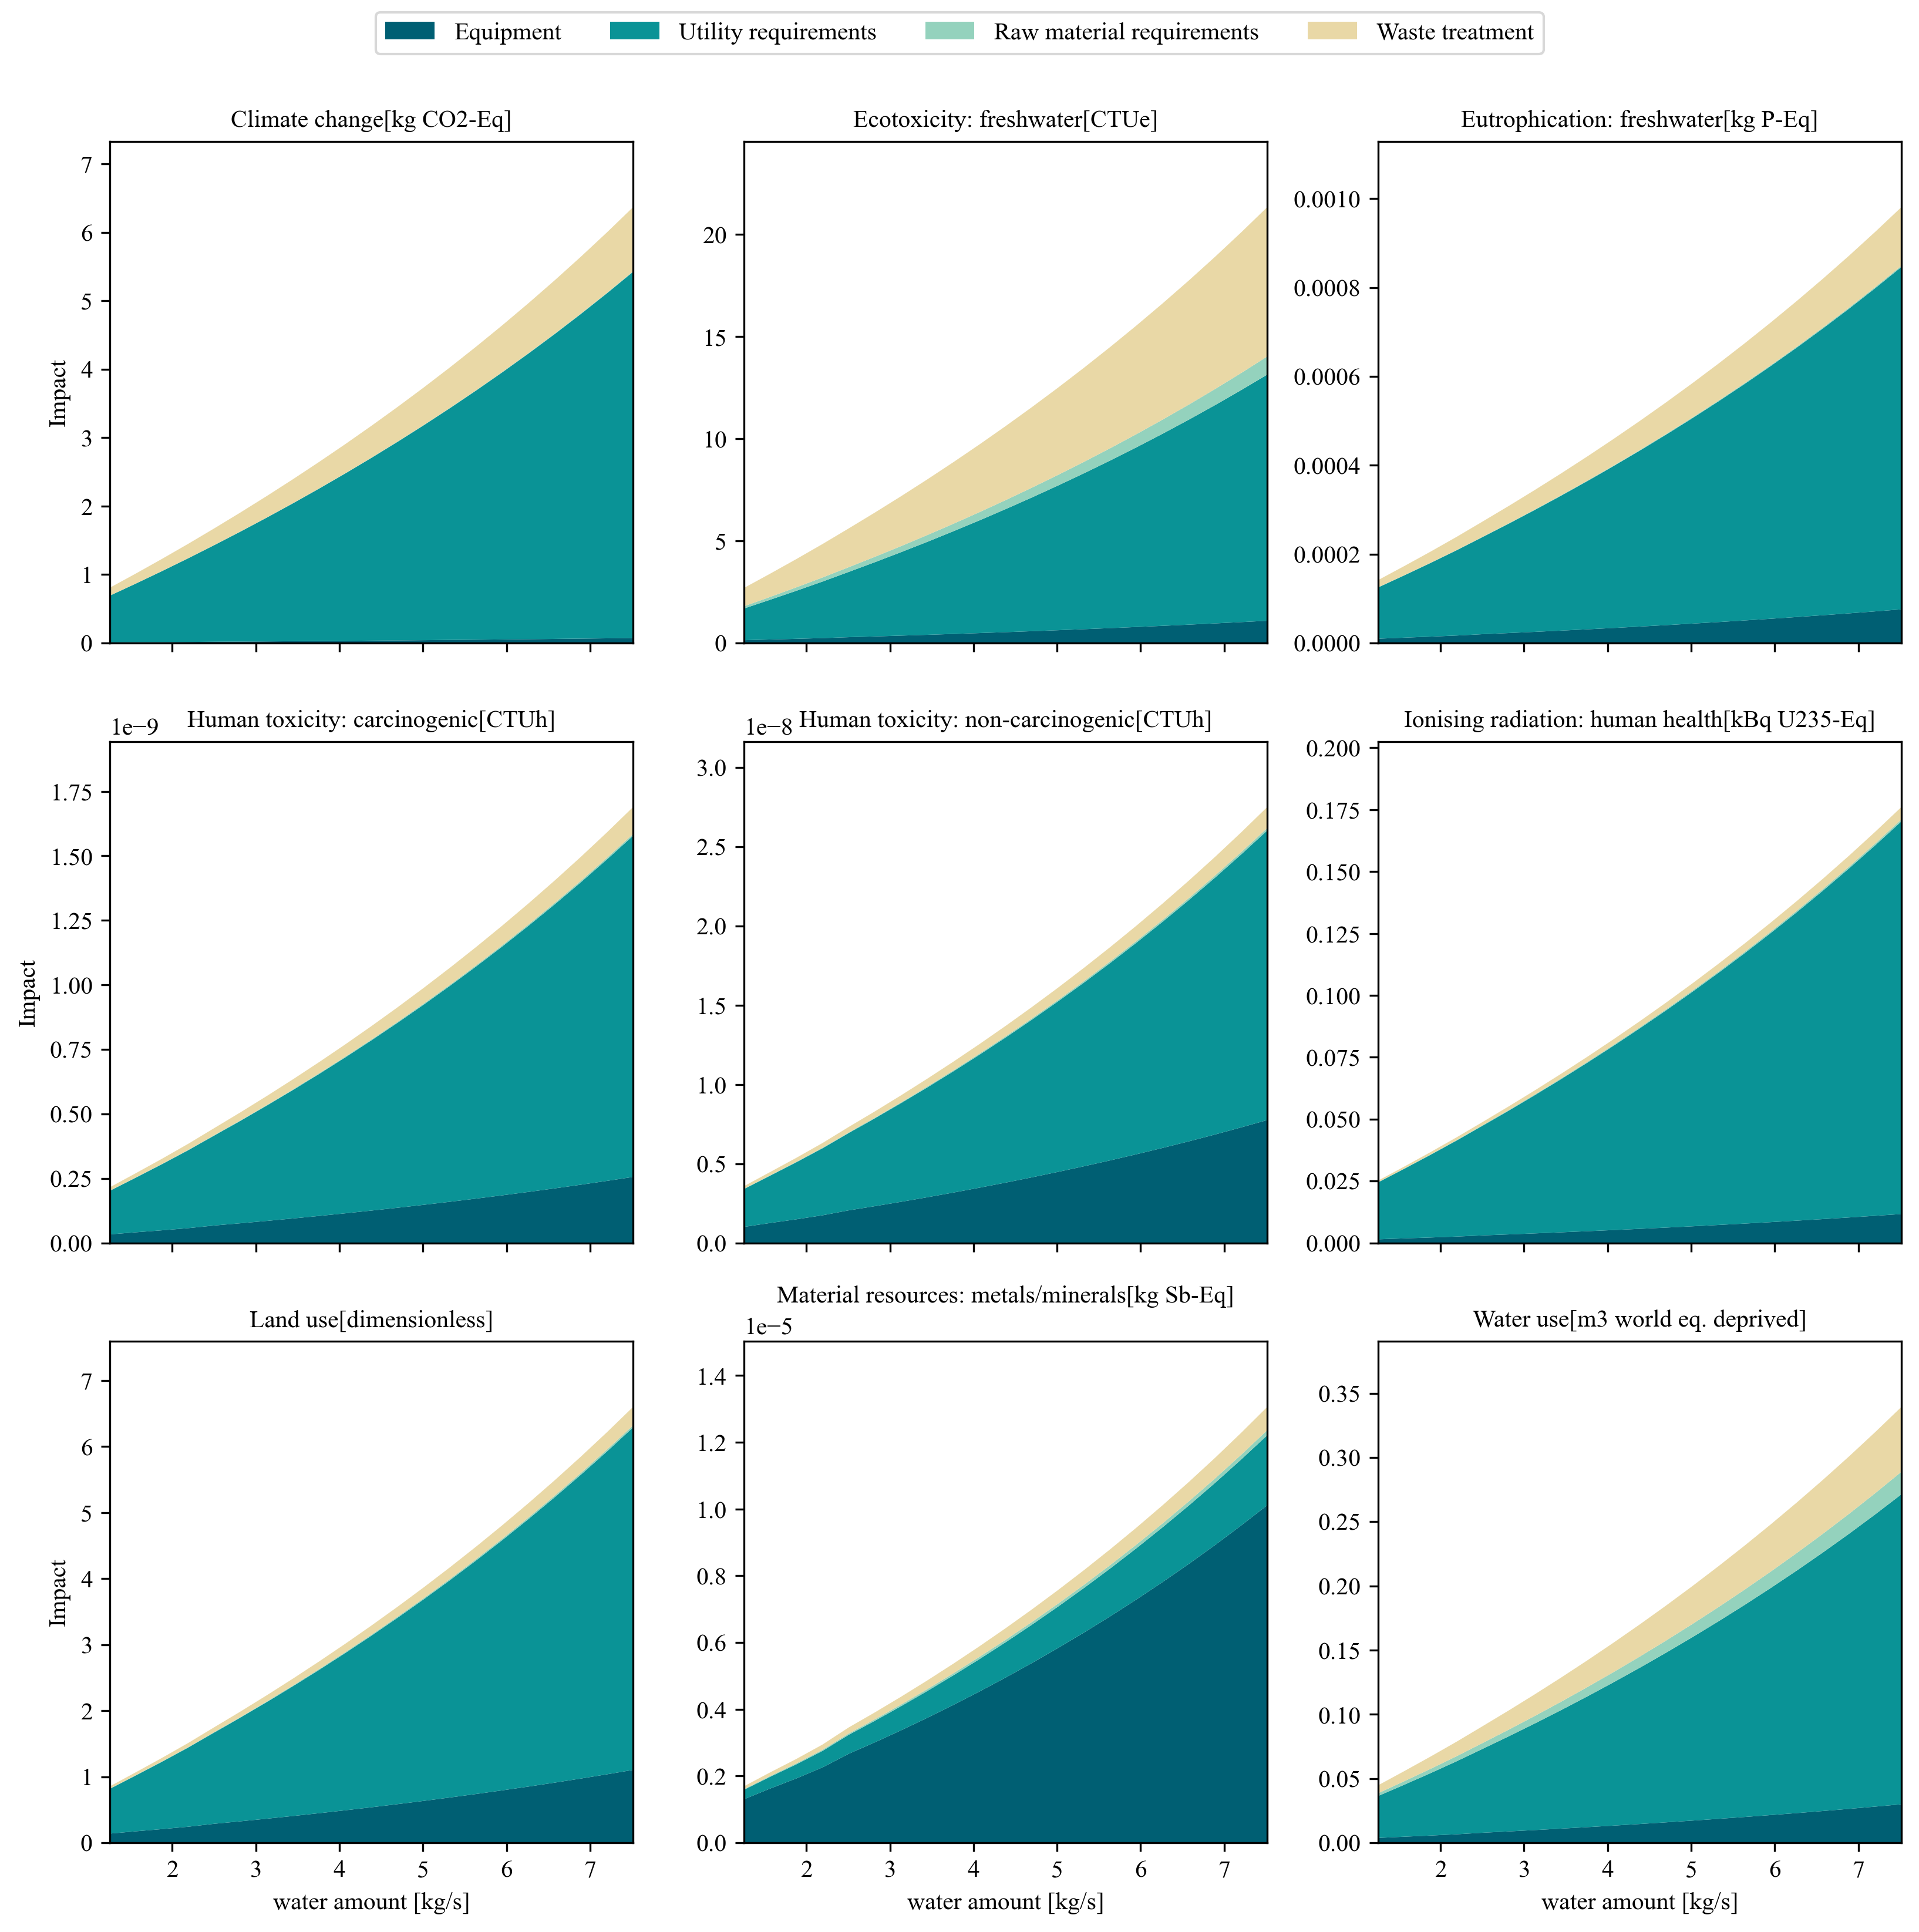

In [106]:
x = np.asarray(water_amount)

bop_df = BOPlca_df.sort_index()
uti_df = Utility_requirementslca_df.sort_index()
raw_df = Raw_materialslca_df.sort_index()
waste_df = wastelca_df.sort_index()

IMPACTS = [
    "Climate change[kg CO2-Eq]",
    "Ecotoxicity: freshwater[CTUe]",
    "Eutrophication: freshwater[kg P-Eq]",
    "Human toxicity: carcinogenic[CTUh]",
    "Human toxicity: non-carcinogenic[CTUh]",
    "Ionising radiation: human health[kBq U235-Eq]",
    "Land use[dimensionless]",
    "Material resources: metals/minerals[kg Sb-Eq]",
    "Water use[m3 world eq. deprived]",
]

labels = ["Equipment", "Utility requirements", "Raw material requirements", "Waste treatment"]

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(11, 11), dpi=150, sharex=True)
axes = axes.ravel()

plt.rcParams.update({
    "font.size": 10,           # base font size
    "axes.titlesize": 10,      # subplot titles
    "axes.labelsize": 10,      # x/y labels
    "xtick.labelsize": 10,     
    "ytick.labelsize": 10,
    "legend.fontsize": 10,     
    "figure.titlesize": 10     # overall figure title (if any)
})

for i, imp in enumerate(IMPACTS):
    ax = axes[i]
    bop = bop_df[imp].to_numpy()
    uti = uti_df[imp].to_numpy()
    raw = raw_df[imp].to_numpy()
    waste = waste_df[imp].to_numpy()
    total = bop + uti + raw + waste

    ax.stackplot(x, bop, uti, raw, waste, labels=labels)
    ax.set_title(imp, fontsize=10)
    ax.set_ylim(0, total.max() * 1.15)
    ax.margins(x=0.0, y=0.02)
    if i % cols == 0:
        ax.set_ylabel("Impact")
    if i // cols == rows - 1:
        ax.set_xlabel("water amount [kg/s]")

# Hide any unused axes (if IMPACTS < 9)
for j in range(len(IMPACTS), rows*cols):
    fig.delaxes(axes[j])

# One shared legend
handles, labs = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, frameon=True, framealpha=0.75)

fig.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()


# **References**

- Baaqel, H. et al. (2022) ‘Sustainability Assessment of Alternative Synthesis Routes to Aprotic Ionic Liquids: The Case of 1-Butyl-3-methylimidazolium Tetrafluoroborate for Fuel Desulfurization’, ACS Sustainable Chemistry & Engineering, 10(1), pp. 323–331. Available at: https://doi.org/10.1021/acssuschemeng.1c06188.
- Gerhardt-Mörsdorf, J. et al. (2024) ‘Life Cycle Assessment of a 5 MW Polymer Exchange Membrane Water Electrolysis Plant’, Advanced Energy and Sustainability Research, n/a(n/a), p. 2300135. Available at: https://doi.org/10.1002/aesr.202300135.
- Blume, N. et al. (2022) ‘Life cycle assessment of an industrial-scale vanadium flow battery’, Journal of Industrial Ecology, 26(5), pp. 1796–1808. Available at: https://doi.org/10.1111/jiec.13328.
- Jolivet, R. (2023) ‘lca_algebraic’. Available at: https://github.com/oie-mines-paristech/lca_algebraic (Accessed: 6 November 2023).
- Jolivet, R. et al. (2021) ‘lca_algebraic: a library bringing symbolic calculus to LCA for comprehensive sensitivity analysis’, The International Journal of Life Cycle Assessment, 26(12), pp. 2457–2471. Available at: https://doi.org/10.1007/s11367-021-01993-z.
- Mutel, C. (2017) ‘Brightway: An open source framework for Life Cycle Assessment’, The Journal of Open Source Software, 2(12), p. 236. Available at: https://doi.org/10.21105/joss.00236.
- Haupt, M., Kägi, T., & Hellweg, S. (2018). Life cycle inventories of waste management processes. Data in Brief, 19, 1441-1457. https://doi.org/10.1016/j.dib.2018.05.067
- Ignacio J. Castellanos-Beltran, Fábio Gonçalves Macêdo de Medeiros, Farid Bensebaa & Bruna Rego De Vasconcelos , Novel bottom-up methodology to build the lifecycle inventory of unit operations: the impact of macroscopic components https://link.springer.com/article/10.1007/s11367-023-02165-x#MOESM1
- Hischier, R., Hellweg, S., Capello, C. et al. Establishing Life Cycle Inventories of Chemicals Based on Differing Data Availability (9 pp). Int J Life Cycle Assessment 10, 59–67 (2005). https://doi.org/10.1065/lca2004.10.181.7
- Seader, J. D., Henley, E. J., & Roper, D. K. (2017). *Product and Process Design Principles.*  
- Turton, R. et al. (2018). *Analysis, Synthesis, and Design of Chemical Processes.*  